# Ransac affine for point cloud alignment
*220806 added simulation by Charlotte

In this tutorial we will learn to align several point clouds from the ROI using two variants of the ransac affine and ICP algorithm

Prerequistes:
1. starfinity for finding ROI
2. ### Inspect invalid ROIs, extract ROI_SPOTS after bigstream registration

Steps
1. import spots location if using RS-FISH, checked with Napari images
2. load spot location of ROI (FISHSPOTS,RS-FISH, or starfish), perform
ransac affine, ICP affine for each channels of two rounds
4. ### perform affine, export spots location of every ROIs. 
5. Visualization of spots of multiple channels and rounds
6. Decode spots with knn neighbor or other 3d seqFISH methods.

For later:Trying to implement other better non-rigid methods, local descriptor methods.

bash
1. for each channel, rounds, and # numbers of ROI (e.g., every 50)

We begin with loading the required modules.

In [5]:
# import pools
import os
import sys
import itertools
from math import pi, sin, cos, sqrt
import numpy as np
import matplotlib.pyplot as plt

import cv2
from matplotlib import cm
from scipy import ndimage
import scipy.io
from skimage import data
from skimage.io import imread, imsave
import pandas as pd
from scipy.spatial import cKDTree
from cv2 import estimateTranslation3D
import tifffile
import seaborn as sns

# import bigstream library
import zarr
import z5py
from bigstream import features
#from bigstream import features1
from bigstream import ransac
from bigstream import affine
#from bigstream import affine1
from bigstream import transform
from fishspot.filter import white_tophat
from fishspot.detect import detect_spots_log

# napari
%gui qt5
import napari
# viewer = napari.view_image(data.astronaut(), rgb=True)
# napari.run()

We begin with loading the required modules for ransac.

### Colocalization filter 

In [2]:
def eucldist(coords1, coords2):
    """ Calculates the euclidean distance between 2 lists of coordinates. """
    dist = np.zeros(len(coords1))
    i = 0
    for (x, y) in zip(coords1, coords2):
        p1 = x
        p2 = y
        squared_dist = (p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2
        dist[i] = np.sqrt(squared_dist)
        i = i+1
    return dist

def cloud_distance(spot_fix,spot_mov):
    """compute distance of nearest spot cloud by KNN.
    """
    c0=spot_fix[:,:3].copy()
    c1=spot_mov[:,:3].copy()
    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True)  
    return dist2[:,0]

def colocalization(spot_c0,spot_c1,neighbor_radius):
    #vox=[0.23,0.23,0.38]
    c0=spot_c0[:,:3].copy()
    c1=spot_c1[:,:3].copy()

    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    neighbors = kdtree_c0.query_ball_tree(kdtree_c1, neighbor_radius)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True) 
    ## find the smallest repeated value location, and delete the others
    for i in range(Idx_unique.shape[0]):  # should repeat for only once
    #     print(Idx_unique[i])
        Loc_rep=np.where(idx2==Idx_unique[i])    
    #     print(Loc_rep[0])
        A=dist2[Loc_rep[0],Loc_rep[1]]
        minposition = min(A)
        Loc_min = np.where(A==minposition)[0]
    #     print(Loc_min)
    #     Loc_rep_min=Loc_rep[0][Loc_min[0]]    
        Loc_rep_nouse=np.delete(range(len(Loc_rep[0])),Loc_min)
        dist2[Loc_rep[0][Loc_rep_nouse],Loc_rep[1][Loc_rep_nouse]]=neighbor_radius*2 
    ## find the results that are less than radius; used later column data 
    # when only first row is not exist use latter column, or just dispose it. 
    co_loc=np.where(dist2>neighbor_radius)

    for j in range(dist2.shape[0]):
         if dist2[j,0] < neighbor_radius:
                dist2[j,1] = neighbor_radius*2
    for j in range(dist2.shape[0]):            
         if dist2[j,0] <neighbor_radius or dist2[j,1] <neighbor_radius:
                dist2[j,2] = neighbor_radius*2       
    row_c1 = np.where(dist2<neighbor_radius)
#     print(len(row_c1[0]))

    # lipo spot_c1 is row_c1
    pBind = row_c1[0]
    # print(idx2)
    # lipo spot_c1 is idx2
    pAind = [(idx2[row_c1[0][x], row_c1[1][x]]) for x in range(len(row_c1[0]))]
    lipo_c0 = spot_c0[pAind]
    lipo_c1 = spot_c1[pBind]

#     print(np.unique(pAind).shape) 
    true_pos_c0 = np.delete(spot_c0, pAind, axis=0)
    true_pos_c1 = np.delete(spot_c1, pBind, axis=0) #true

    if spot_c0.shape[0]>0:
        P1 = (lipo_c0.shape[0] / spot_c0.shape[0])*100   # % mov spots from  previous images  /spot_c0.shape
    else:
        P1 = 0
        
    if spot_c1.shape[0]>0:
        P2 = (lipo_c1.shape[0] / spot_c1.shape[0])*100  # % fixed spots can be found in later mov images  /spot_c0.shape
    else:
        P2 = 0
#     print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
    Dist = np.mean(eucldist(lipo_c0,lipo_c1))

    return lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,Dist,P1,P2

def get_spot_inside(all_spots,segmentation_mini,fix_spacing,ROI_fixed,cc):
    """remove spots outside of a segmenation mask
       change spot location back to segmentation mask in pixels
    """
    fix_spots_mini = all_spots[:,:3] / fix_spacing * [0.5,0.25,0.25] + cc
    spot_mini = np.zeros(len(fix_spots_mini))
    rounded_spot = fix_spots_mini.astype('int') 
    for i in range(0, len(fix_spots_mini)):          
        Coord = rounded_spot[i]
        if Coord[0]<0: Coord[0] = 0
        if Coord[1]<0: Coord[1] = 0
        if Coord[2]<0: Coord[2] = 0
        if Coord[0]>segmentation_mini.shape[0]: Coord[0] = segmentation_mini.shape[0]
        if Coord[1]>segmentation_mini.shape[1]: Coord[1] = segmentation_mini.shape[1]            
        if Coord[2]>segmentation_mini.shape[2]: Coord[2] = segmentation_mini.shape[2]
        idx = segmentation_mini[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
        if idx == ROI_fixed:
            spot_mini[i] = idx  # add ROI number  
    spots_in = all_spots[np.where(spot_mini==ROI_fixed)]
    spots_out = all_spots[np.where(spot_mini==0)]
    
    spots_in_index = np.where(spot_mini==ROI_fixed)
    ns = spots_in.shape[0]
#     print(f'Image: found {ns} key points inside ROI')
    print(f'Image: found {spots_out.shape[0]} key points outside ROI')
    return spots_in,spots_in_index

## ICP
def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nx3 array of points
        dst: Nx3 array of points
    Output:
        distances: Euclidean distances (errors) of the nearest neighbor
        indecies: dst indecies of the nearest neighbor
    '''
    indecies = np.zeros(src.shape[0], dtype=np.int)
    distances = np.zeros(src.shape[0])
    for i, s in enumerate(src):
        min_dist = np.inf
        for j, d in enumerate(dst):
            dist = np.linalg.norm(s-d)
            # find Nearest dst[j] to src[i]
            if dist < min_dist:
                min_dist = dist
                indecies[i] = j
                distances[i] = dist
    return distances, indecies  

def get_scale(A,B):
    dis_A=get_all_side_length(np.array(A))
    dis_B=get_all_side_length(np.array(B))
    scale = np.abs(dis_B/dis_A)
    mask=np.abs(scale)>0.0001
    scale_sort=np.sort(scale[mask].reshape(-1))
    d_n=len(scale_sort)
    s_mean=scale_sort[int(d_n/4):int(d_n*3/4)].mean() #only use medium data
    return s_mean

def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform between corresponding 3D points A->B
    Input:
      A: Nx3 numpy array of corresponding 3D points
      B: Nx3 numpy array of corresponding 3D points
    Returns:
      T: 4x4 homogeneous transformation matrix
      R: 3x3 rotation matrix
      t: 3x1 column vector
    '''
    assert len(A) == len(B)

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0) 
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    W = np.dot(BB.T, AA)
    U, s, VT = np.linalg.svd(W, full_matrices=True, compute_uv=True)
    R = np.dot(U, VT)

    # special reflection case
    if np.linalg.det(R) < 0:
        VT[2,:] *= -1
        R = np.dot(U, VT)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    #scale 
#     s_mean=get_scale(A,B)
    s_mean=1
    
    # homogeneous transformation
    T = np.identity(4)
#     T[0:3, 0:3] = s_mean * R
    T[0:3, 0:3] = R
    T[0:3, 3] = t
    
    return T, R, t, s_mean
       
def icp(A0, B0,distance_forICP,init_pose = None, max_iterations=200, tolerance=0.0001):
    '''
    The Iterative Closest Point method
    Input:
        A: Nx3 numpy array of source 3D points
        B: Nx3 numpy array of destination 3D point
        init_pose: 4x4 homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation
        distances: Euclidean distances (errors) of the nearest neighbor
    '''
    #  select points
#     distance_forICP = 3

    A,B,_,_,dist,_,_ = colocalization(A0,B0,distance_forICP)
    
    # make points homogeneous, copy them so as to maintain the originals
    src = np.ones((4,A.shape[0]))  #(4, A.shape[0])
    dst = np.ones((4,B.shape[0]))
    src[0:3,:] = np.copy(A.T)  # A.T shape (3,20)
    dst[0:3,:] = np.copy(B.T) # FIX
    
    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0
    distances_iter = np.zeros((max_iterations,1))
    for i in range(max_iterations):
        # find the nearest neighbours between the current source and destination points
        distances, indices = nearest_neighbor(src[0:3,:].T, dst[0:3,:].T)
        # compute the transformation between the current source and nearest destination points
        T,R,t,s_mean = best_fit_transform(src[0:3,:].T, dst[0:3,indices].T)  #Sort dst[] by indices
        src = np.dot(T, src)
        # check error
        mean_error = np.sum(distances) / distances.size
        if abs(prev_error-mean_error) < tolerance:
            break
        prev_error = mean_error
        distances_iter[i] = mean_error
    T,R,t,s_mean = best_fit_transform(A, src[0:3,:].T)
    
    src_1 = np.ones((4,A0.shape[0]))  #(4, A.shape[0])
    src_1[0:3,:] = np.copy(A0.T)  # A.T shape (3,20)    
    C = np.dot(T, src_1) # A transform
    C =  C[0:3,:].T      # save file as the same order 
    
    return T, distances, C 

def get_all_side_length(points):
    all_dis=[]
    for i in range(len(points)-1):
        for j in range(i+1,len(points)):
            all_dis.append(points[i]-points[j])
    all_dis=np.array(all_dis)
    return np.linalg.norm(all_dis,axis=1)

def estimate_similarity_transform_3D(A, B):
                 
    assert len(A) == len(B)
    N = A.shape[0];
    mu_A = mean(A, axis=0)
    mu_B = mean(B, axis=0)

    AA = A - tile(mu_A, (N, 1))
    BB = B - tile(mu_B, (N, 1))
    H = transpose(AA) * BB
    U, S, Vt = linalg.svd(H)
    R = Vt.T * U.T
                 
    if linalg.det(R) < 0:
        print ("Reflection detected")
        Vt[2, :] *= -1
        R = Vt.T * U.T
    s_mean=get_scale(A,B)
    t = -s_mean * R * mu_A.T + mu_B.T

    return R, t	,s_mean

In [1]:
##RANSAC-ICP modules #c

In [60]:
# read coordinates
def read_coords(path):
    with open(path, 'r') as f:
        offset = np.array(f.readline().split(' ')).astype(np.float64)
        extent = np.array(f.readline().split(' ')).astype(np.float64)
        index  = np.array(f.readline().split(' ')).astype(np.uint16)
    return offset, extent, index

def position_grid(sh, dtype=np.uint16):
    """Return a position array in physical coordinates with shape sh"""
    coords = np.array(np.meshgrid(*[range(x) for x in sh], indexing='ij'), dtype=dtype)
    return np.ascontiguousarray(np.moveaxis(coords, 0, -1))

#Edges evaluation
def ROI_edge(moving_image, b1,b2,b3,b4,b5,b6):        
    if b1 <0:
        b1 = 0
    if b3 <0:
        b3 = 0  
    if b5 <0:
        b5 = 0 
    if b2 >= moving_image.shape[0]:
        b2 = moving_image.shape[0] -1
    if b4 >= moving_image.shape[1]:
        b4 = moving_image.shape[1] -1 
    if b6 >= moving_image.shape[2]:
        b6 = moving_image.shape[2] -1     
    return b1,b2,b3,b4,b5,b6

def violin_distance(A, B):    
    fig=plt.figure(dpi=120,figsize=(2,3))
    plt.violinplot(cloud_distance(A,B))
    sns.despine() 
    plt.xlabel('Spots:'+ str(cloud_distance(A,B).shape[0]))
    plt.ylabel('Distance')
    ave=np.average(cloud_distance(A,B))
    plt.title(str(float('%.2f' % ave)))
    plt.show()
    plt.tight_layout()
    return ave

def assign_roi(ROI_assign,ROI_all,roi_inc,i,out_dir,segmentation1):
    """
    image tile:1024*1024*512
    mask tile: 1024*1024*512/(4*4*2) = 256*256*256

    for ROI in multiple tiles, locate it into tile where first come first used.
    or 
    randomly split it into multiple tiles.
    """
    ROI_assign = 0 # 0 is random tiling or 1 isnot
    ROI_intersect = []
    ROI_current = []
    if ROI_assign == 0:
        ROI_id = ROI_all[roi_inc*i:(i+1)*roi_inc]
    else:    
        # assign ROIs to directory by each czi tile
        offset, extent, index = read_coords(out_dir + str(i) + '/coords.txt')
        grid0 = np.round(offset/vox/scale).astype(np.uint16)
        grid = np.round(extent/vox/scale).astype(np.uint16)
        segmentation_tile = segmentation1[grid0[2]:grid0[2]+grid[2],
                  grid0[1]:grid0[1]+grid[1],grid0[0]:grid0[0]+grid[0]]
        ROI_id = np.unique(segmentation_tile[segmentation_tile != 0])
        ROI_intersect = list(set(ROI_current).intersection(set(ROI_id)))
        if len(ROI_intersect) == 0: # no replicate
            ROI_id = ROI_id
        elif np.array(ROI_id).shape[0] > len(ROI_intersect): # has replicate
            ROI_id = np.array(list(set(list(ROI_id,)).difference(set(ROI_intersect))))
        else: # all replicates
            ROI_id = []         

    if len(ROI_id)>0:
        ROI_current = list(set(ROI_current).union(set(ROI_id)))  

def assign_roi_images(tile_number,fix3_path,out_dir,seg_dir,roi_dir,segmentation1,segmentation2,En_pixels):
    """
    save images of different channels of every roi
    """
    from scipy import ndimage
    
    if not os.path.exists(fix3_path): os.mkdir(fix3_path)
    zoom=[2,4,4] # when extract s0
    zoom=[1,1,1] # when extract s2 
    fix_spacing=np.array([0.42,0.23,0.23])
    vox=[0.23,0.23,0.42]
    
    fixed = []
    moving = []
    tile_number = 1
    i = 0
    R_dir = 'Z:/sternsonlab/Zhenggang/Gary_analysis/LHA_5_R2_R10_0725/' 
    subpath2='/s2'
 
    ## save images of different channel
    for Chn in ["c0","c1","c2","c3"]: ## ["C0","C1","C2","C3"]
        subpath1=Chn
        R_n = 'LHA_5_R2_4x4'
        path= R_dir + R_n + '/stitching/export.n5'
        fixed = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1+subpath2]
        
        R_n = 'LHA_5_R10_4x4'
        path= R_dir + R_n + '/stitching/export.n5'
        path= R_dir + R_n + '/registration/LHA_5_R10_4x4-to-LHA_5_R2_4x4/warped'  
        moving = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1+subpath2]
        
        if i == 0:
            print("tile: #" + str(i+1))
            j=0
            ROI_id = np.unique(segmentation1[segmentation1!=0])
            if not os.path.exists(fix3_path + 's2' + '/'): os.mkdir(fix3_path + 's2' + '/')

            for aa in ROI_id:     
                # for each roi, save fixed_ROI images, moving_ROI images(name after subdirectory). 
                AA=np.where(segmentation1==aa)
                # enlarge the moving image ROI view
#                 ROI_moving = aa
#                 BB=np.where(segmentation2==ROI_moving)
#                 En_pixels = 0 # Enlarged pixels 
#                 b1 = min(BB[0])*zoom[0] - En_pixels
#                 b2 = max(BB[0])*zoom[0] + En_pixels
#                 b3 = min(BB[1])*zoom[1] - En_pixels
#                 b4 = max(BB[1])*zoom[1] + En_pixels
#                 b5 = min(BB[2])*zoom[2] - En_pixels
#                 b6 = max(BB[2])*zoom[2] + En_pixels
#                 b1,b2,b3,b4,b5,b6 = ROI_edge(moving,b1,b2,b3,b4,b5,b6)
                
                #save ROI_id into the directory of specific tiles
                fixed_ROI = fixed[min(AA[0])*zoom[0]:max(AA[0])*zoom[0],
                  min(AA[1])*zoom[1]:max(AA[1])*zoom[1],
                  min(AA[2])*zoom[2]:max(AA[2])*zoom[2]].astype('float16')
                print(fixed_ROI.shape)
                
                moving_ROI = moving[min(AA[0])*zoom[0]:max(AA[0])*zoom[0],
                  min(AA[1])*zoom[1]:max(AA[1])*zoom[1],
                  min(AA[2])*zoom[2]:max(AA[2])*zoom[2]].astype('float16')

                print(moving_ROI.shape)
                roi_dir = fix3_path + 's2' + '/R2_' + str(aa) + '_'+ Chn + '.tif'
                imsave(roi_dir, fixed_ROI)
                roi_dir = fix3_path + 's2' + '/R10_' + str(aa) + '_'+ Chn + '.tif'
                imsave(roi_dir, moving_ROI)
                j = j + 1        
        
def assign_roi_images_fix(tile_number,fix3_path,out_dir,seg_dir,roi_dir,segmentation1,segmentation2,En_pixels):
    """
    save images of different channels of every FIX roi
    """
    from scipy import ndimage
    
    if not os.path.exists(fix3_path): os.mkdir(fix3_path)
    zoom=[2,4,4]    
    fix_spacing=np.array([0.42,0.23,0.23])
    vox=[0.23,0.23,0.42]
    
    fixed = []
    moving = []
    tile_number = 1
    i = 0
    R_dir = 'Z:/sternsonlab/Zhenggang/Gary_analysis/outputs/' 
    subpath2='/s0'
 
    ## save images of different channel
    for Chn in ["c0","c1","c3"]: ## ["C0","C1","C2","C3"]
        subpath1=Chn
        R_n = 'LHA_5_R2_4x4' 
        path= R_dir + R_n + '/stitching/export.n5'  
        fixed = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1+subpath2]
#         R_n = 'LHA_5_R10_4x4' 
#         path= R_dir + R_n + '/stitching/export.n5'
#         path= R_dir + R_n + '/registration/LHA_5_R10_4x4-to-LHA_5_R2_4x4/warped'  
#         moving = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1+subpath2]
        if i == 0:
            print("tile: #" + str(i+1))
            j=0
            ROI_id = np.unique(segmentation1[segmentation1!=0])
            if not os.path.exists(fix3_path + str(i) + '/'): os.mkdir(fix3_path + str(i) + '/')

            for aa in ROI_id:     
                # for each roi, save fixed_ROI images, moving_ROI images(name after subdirectory). 
                AA=np.where(segmentation1==aa)
                # enlarge the moving image ROI view
#                 ROI_moving = aa
#                 BB=np.where(segmentation2==ROI_moving)
#                 En_pixels = 0 # Enlarged pixels 
#                 b1 = min(BB[0])*zoom[0] - En_pixels
#                 b2 = max(BB[0])*zoom[0] + En_pixels
#                 b3 = min(BB[1])*zoom[1] - En_pixels
#                 b4 = max(BB[1])*zoom[1] + En_pixels
#                 b5 = min(BB[2])*zoom[2] - En_pixels
#                 b6 = max(BB[2])*zoom[2] + En_pixels
#                 b1,b2,b3,b4,b5,b6 = ROI_edge(moving,b1,b2,b3,b4,b5,b6)
                
                #save ROI_id into the directory of specific tiles
                fixed_ROI = fixed[min(AA[0])*zoom[0]:max(AA[0])*zoom[0],
                  min(AA[1])*zoom[1]:max(AA[1])*zoom[1],
                  min(AA[2])*zoom[2]:max(AA[2])*zoom[2]].astype('float16')
                
#                 moving_ROI = moving[b1:b2,b3:b4,b5:b6].astype('float16')

                print(fixed_ROI.shape)
                roi_dir = fix3_path + str(i) + '/R2_' + str(aa) + '_'+ Chn + '.tif'
                imsave(roi_dir, fixed_ROI)
#                 roi_dir = fix3_path + str(i) + '/R1_' + str(ROI_moving) + '_'+ Chn + '.tif'
#                 imsave(roi_dir, moving_ROI)
                
                j = j + 1

In [5]:
# ===========calculate FPFH for pcd==========
def FPFH_Compute(pcd,r1,r2):
    
    import open3d as o3d
    radius_normal = r1  # kdtree estimate radius 0.01
#     print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=100)) ## 30
    radius_feature = r2  # kdtree estimate FPFH feature radius 0.02
#     print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature( pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=200)) 
    return pcd_fpfh

#===============global_registration===================
def execute_global_registration(source, target, source_fpfh,target_fpfh,distance_threshold):  # pcd and fpfh
    import open3d as o3d
    #     distance_threshold = 1  # radius 
    print("we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source, target, source_fpfh, target_fpfh,True,distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(True),4, 
        [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.90),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
        o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500))
    # o3d.pipelines.registration.TransformationEstimationPointToPoint(False),4,mutual_filter: True, 
    return result

#=================visualization.draw_geometries=================   
# visualization
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)       #
    target_temp = copy.deepcopy(target)       #
    source_temp.paint_uniform_color([1, 0, 0])#
    target_temp.paint_uniform_color([0, 1, 0])
    source_temp.transform(transformation)
    #o3d.io.write_point_cloud("trans_of_source1.pcd", source_temp)#
    o3d.visualization.draw_geometries([source_temp, target_temp],width=600,height=600)

def ransac_fpfh_registration(A,B,dist_raw): 
    #FPFH_Compute kdtree estimate radius: dist_raw, kdtree FPFH dist_raw*2, dist_raw/4 as ransac distance
    # read points of # point cloud
    # xyz = np.asarray(result.points)    
    #====================pcd===============
    # Pass points xyz to Open3D.o3d.geometry.PointCloud and visualize
    # pcd = o3.geometry.PointCloud()
    import time
    import open3d as o3d
    import copy
    from probreg import cpd
    import transforms3d as t3d
    
    source = o3d.io.read_point_cloud('D:/0_software/github/probreg/examples/bunny.pcd')
    source.remove_non_finite_points()
    target = copy.deepcopy(source)
    target.points = o3d.utility.Vector3dVector(A)
    source.points = o3d.utility.Vector3dVector(B)
    
    source_fpfh=FPFH_Compute(source,dist_raw*1.5,dist_raw*3) # 0.01,0.02
    target_fpfh=FPFH_Compute(target,dist_raw*1.5,dist_raw*3)
    #==============global_registration==============
#     start = time.time()
    result_ransac = execute_global_registration(source, target,source_fpfh,target_fpfh, dist_raw/4) # 1
#     print("Global registration took %.3f sec.\n" % (time.time() - start))
    print(result_ransac)
#     print(result_ransac.transformation)
    #======================ICP registration======================
#     start = time.time()
    GICP = 0
    if GICP == 0:
        icp_p2p = o3d.pipelines.registration.registration_icp(
                source, target, dist_raw/6, result_ransac.transformation,
                o3d.pipelines.registration.TransformationEstimationPointToPoint(True),
                o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1.000000e-08, 
                relative_rmse=1.000000e-08,max_iteration=500))
    else:
        icp_p2p = o3d.pipelines.registration.registration_generalized_icp(
                source, target, dist_raw/8, result_ransac.transformation,
                o3d.pipelines.registration.TransformationEstimationForGeneralizedICP(epsilon=0.01),
                o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1.000000e-04, 
                relative_rmse=1.000000e-04,max_iteration=100))
    
    # TransformationEstimationPointToPoint(), TransformationEstimationPointToPlane(), 
    # TransformationEstimationForGeneralizedICP, TransformationEstimationForColoredICP
#     print("ICP registration took %.3f sec.\n" % (time.time() - start))
    print(icp_p2p)#output icp
#     print("Transformation is:")
#     print(icp_p2p.transformation)

#     draw_registration_result(source, target, result_ransac.transformation) # 
#     draw_registration_result(source, target, icp_p2p.transformation)
    
    result = copy.deepcopy(source)
    result.transform(result_ransac.transformation)
    s1=np.asarray(result.points)[:,:3] #convert spot physical coordinates to pixel coordin
    
    result = copy.deepcopy(source)
    result.transform(icp_p2p.transformation)
    s2=np.asarray(result.points)[:,:3] #convert spot physical coordinates to pixel coordinates

    return result_ransac,icp_p2p,s1,s2

In [6]:
from skimage.measure import regionprops
def ROI_area(segmentation,lb_id):
    lb = segmentation.astype(int)
    lb_stat = regionprops(lb)
    df = lb_stat[0].area
    return df

def seg_cyto(moving_ROI_c2,segmentation2,BB,ROI_moving,mov_spots,dd):

    # find DAPI images without nucleus  cytoplasm binarization
    from skimage import (filters, measure, morphology, segmentation)
    from scipy import ndimage as ndi

    smooth = filters.gaussian(moving_ROI_c2, sigma=3)
    thresh_value = filters.threshold_otsu(smooth)
    thresh = smooth > thresh_value
    fill = ndi.binary_fill_holes(thresh)
#     clear = segmentation.clear_border(fill)
    clear = fill

    mask = moving_ROI_c2*0
    mask = np.where(clear == False,1,mask)  # 
    mask = ndimage.zoom(clear, np.array([0.5,0.25,0.25]), order=0)
    segmentation4 = segmentation2*0
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    b1 = dd[0]
    b2 = dd[0] + mask.shape[0]
    b3 = dd[1]
    b4 = dd[1] + mask.shape[1]
    b5 = dd[2] 
    b6 = dd[2] + mask.shape[2]
    segmentation4[b1:b2,b3:b4,b5:b6] = mask # new aa#, which is only has cytoplasm
    segmentation3 = np.where(segmentation2 == ROI_moving,0,segmentation2) # segmentation3 remove aa# 
    segmentation3 = segmentation2 - segmentation3   # segmentation3 remain aa# all cell 
    segmentation3 = np.where(segmentation4 == 0,0,segmentation3) # keep cytoplasm
    D,_ = get_spot_inside(mov_spots,segmentation3,fix_spacing,ROI_moving,dd) 
    if mov_spots.shape[0] == 0:
        E = 0
    else:
        E = 100*(mov_spots.shape[0] - D.shape[0])/mov_spots.shape[0] # % spots of nuclues in all
    return D, E,segmentation3

def spots_random_shuffled(moving_ROI_c2,segmentation2,BB,ROI_moving,mov_spots,Shuffle_spots):
    
    # generate point clouds with a new DAPI segmentation without nucleus
    # find DAPI images without nucleus cytoplasm binarization
    from skimage import (filters, measure, morphology, segmentation)
    from scipy import ndimage as ndi
    smooth = filters.gaussian(moving_ROI_c2, sigma=3)
    thresh_value = filters.threshold_otsu(smooth)
    thresh = smooth > thresh_value
    fill = ndi.binary_fill_holes(thresh)
#   clear = segmentation.clear_border(fill)
    clear = fill

    mask = moving_ROI_c2*0
    mask = np.where(clear == False,1,mask)  # 
    mask = ndimage.zoom(clear, np.array([0.5,0.25,0.25]), order=0)
    segmentation4 = segmentation2*0

    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    b1 = dd[0]
    b2 = dd[0] + mask.shape[0]
    b3 = dd[1]
    b4 = dd[1] + mask.shape[1]
    b5 = dd[2] 
    b6 = dd[2] + mask.shape[2]
    segmentation4[b1:b2,b3:b4,b5:b6] = mask # same with new mask 
    segmentation_aa = np.where(segmentation2 == ROI_moving,0,segmentation2) # segmentation3 remove aa
    segmentation_aa = segmentation2 - segmentation_aa   # segmentation_aa: cyto and nucleus              
    segmentation_cyto = np.where(segmentation4 == 0,0,segmentation_aa) # cytoplasm
    segmentation_nuc =  segmentation_aa - segmentation_cyto            # nucleus
    _,E,_ = seg_cyto(fixed_ROI_c2,segmentation2,BB,ROI_moving,mov_spots,dd)
    print(E) # % spots of nuclues in all
    
    if Shuffle_spots > 0 and mov_spots.shape[0] > 4:
        
        # assign spots according to the spatial distribution of spots
        import random      
        points = set()
        rms = mov_spots
        # critiria for how spots can be close 2 pixels
        kdtree_c0 = cKDTree(mov_spots)
        kdtree_c1 = cKDTree(mov_spots)
        dist1,idx1 = kdtree_c1.query(mov_spots, k = 2) 
        
        kdtree_c0 = cKDTree(mov_spots)
        kdtree_c1 = cKDTree(mov_spots)
        dist1,_ = kdtree_c1.query(mov_spots, k = 2)
        distance_pcd = dist1[:,1]
        threshold_distance = np.min(distance_pcd)
        # fig=plt.figure(dpi=120,figsize=(2,3))
        # plt.plot(np.sort(distance_pcd))
        kk = 0
        num_points = len(rms)

        ##################### cytoplasm
        while len(points) < num_points * (E)/100:

            p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                  random.uniform(min(rms[:,2]), max(rms[:,2])))
            
            # inside the masks
            spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
            Coord = spots_mask.astype('int')
            segmentation3 = segmentation_cyto
            
            if Coord[0]<0: Coord[0] = 0
            if Coord[1]<0: Coord[1] = 0
            if Coord[2]<0: Coord[2] = 0
            if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
            if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
            if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
            idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
#             print(idx)
            
            if idx == ROI_moving and p not in points:
               
                if kk < 1:
                    points.add(p)
                    kk = kk + 1
                else:
                    # find nearest neighbor for current spots
                    i_loc = p
                    all_loc = np.array(list(points))
                    neb = 1
    #                 kdtree_c0 = cKDTree(i_loc)
                    kdtree_c1 = cKDTree(all_loc)
                    dist1,_= kdtree_c1.query(i_loc, k = neb)
#                     print(dist1)
                    dist2 = dist1
                    if dist2 > threshold_distance:
                        points.add(p)
                        kk = kk + 1
           
        ##################### nucleus
        while len(points) < num_points:

            p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                  random.uniform(min(rms[:,2]), max(rms[:,2])))
            
            # inside the masks
            spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
            Coord = spots_mask.astype('int')
            segmentation3 = segmentation_nuc
            
            if Coord[0]<0: Coord[0] = 0
            if Coord[1]<0: Coord[1] = 0
            if Coord[2]<0: Coord[2] = 0
            if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
            if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
            if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
            idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
#             print(idx)
            
            if idx == ROI_moving and p not in points:
               
                if kk < 1:
                    points.add(p)
                    kk = kk + 1
                else:
                    # find nearest neighbor for current spots
                    i_loc = p
                    all_loc = np.array(list(points))
                    neb = 1
    #                 kdtree_c0 = cKDTree(i_loc)
                    kdtree_c1 = cKDTree(all_loc)
                    dist1,_= kdtree_c1.query(i_loc, k = neb)
#                     print(dist1)
                    dist2 = dist1
                    if dist2 > threshold_distance:
                        points.add(p)
                        kk = kk + 1
       
        
#         return smooth,thresh_value,thresh,fill,clear,mask,segmentation2,segmentation3 
        segmentation3 = []
        segmentation4 = []
        shuffle_points = np.array(list(points))
#         mov_spots = shuffle_points  ## not shuffle spots
    else:
        shuffle_points = mov_spots
        segmentation3 = []
    return shuffle_points,segmentation3,segmentation_nuc,segmentation_cyto

        
def spots_celllocation(spots,segmentation_nuc,segmentation_cyto,fix_spacing,cc):
    
    # spots now is in global, and in um. Need transfer to pixel of all mask images.
    spots_mask = spots[:, :3] / fix_spacing * [0.5,0.25,0.25] + cc
    rounded_spot = np.round(spots_mask[:, :3]).astype('int') 
    # find where idx1 != 0, add 1 to [:5,:]
    located_points=np.append(spots, np.zeros((len(spots),1)), axis=1) ############ every spot location in um ## add last column    
    col = located_points.shape[1]
    n = len(spots)
    for i in range(0, n): 
        Coord = rounded_spot[i]
#         idx1 = segmentation_nuc[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # nuc roi id
        idx2 = segmentation_cyto[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # cyto roi id
        if idx2 == 0: 
            located_points[i,col-1]= 0 # spots in nucleus and outside
        else:
            located_points[i,col-1]= 1 # spots in cyto
    
    spots_cyto = spots[located_points[:,col-1] == 1,:]
    spots_nuc = spots[located_points[:,col-1] == 0,:]
    
#     print(str(100*spots_nuc.shape[0]/(spots_nuc.shape[0]+spots_cyto.shape[0])))
    
    return spots_cyto,spots_nuc

**Generating simulated spots_Charlotte(220809)**

#### Generate point cloud

In [91]:
%%time
from skimage import (filters, measure, morphology, segmentation)
from scipy import ndimage as ndi

def spots_simulated_code_assign(SpotNum,GeneNum,GeneCode):
    """
    -----Input-----
    SpotNum: Spot numbers per gene, 1 x N matrix recoding spot of each gene
    GeneNum: N genes in total
    GeneCode: N genes x r round matrix
    -----Output-----
    GeneID: indicate which gene the fix spots should be decoded to
    """
  
    allspots=np.sum(SpotNum)
    GeneID = np.zeros((allspots,1),dtype=int)
    IsAssign = np.zeros((allspots,1))
    for i in range(GeneNum):
        findaval=np.where(IsAssign==0)
        aval=list(findaval[0])
        idx= np.random.choice(aval,SpotNum[i])
        for j in idx:
            IsAssign[j,0]=1
            GeneID[j,0]=i
    return GeneID
    
def spots_simulated(ref_ROI_c2,mov_spots,ROI_moving,SpotNum,GeneCode,GeneID,segmentation2,realsimulate,SpotAssign):
    """
    Generate simulated spots_fixing
    generate point clouds with a new DAPI segmentation without nucleus;find DAPI images without nucleus cytoplasm binarization
    -----Input-----
    moving_ROI_c2: dapi channel mask
    mov_spots: real spots that current simulation is based on
    SpotNum: Spot numbers per gene, 1 x N matrix recoding spot of each gene
    GeneCode: N genes x r round matrix
    GeneID: Nx1 array indicating spots gene
    segmentation2: cell mask
    ROI_moving: cell id 
    realsimulate: 0- set threshold_distance, 1-get threshold_distance from data
    SpotAssign: 0-Random in whole cell, 1-Cyto-Nucleus ratio
    -----Other variable-----
    dd: zero point of the current cell mask
    current_round=0
    -----Output-----
    simulate_fix_spots: Nx4 numpy array of simulate fix 3D points
    """
    fix_spacing=np.array([0.42,0.23,0.23])
    vox=[0.23,0.23,0.42]
    current=0
    
    smooth = filters.gaussian(ref_ROI_c2, sigma=3)
    thresh_value = filters.threshold_otsu(smooth)
    thresh = smooth > thresh_value
    fill = ndi.binary_fill_holes(thresh)
#   clear = segmentation.clear_border(fill)
    clear = fill

    #Obtain cell mask
    mask = ref_ROI_c2*0 # initialize mask (Keep the same size as the dapi cell mask)
    mask = np.where(clear == False,1,mask)  # 
    mask = ndimage.zoom(clear, np.array([0.5,0.25,0.25]), order=0)
    segmentation4 = segmentation2*0

    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    b1 = dd[0]
    b2 = dd[0] + mask.shape[0]
    b3 = dd[1]
    b4 = dd[1] + mask.shape[1]
    b5 = dd[2] 
    b6 = dd[2] + mask.shape[2]
    segmentation4[b1:b2,b3:b4,b5:b6] = mask # same with new mask

    segmentation_aa = np.where(segmentation2 == ROI_moving,0,segmentation2) # segmentation3 remove aa
    segmentation_aa = segmentation2 - segmentation_aa   # segmentation_aa: cyto and nucleus              
    if SpotAssign == 1:
        segmentation_cyto = np.where(segmentation4 == 0,0,segmentation_aa) # cytoplasm
        segmentation_nuc =  segmentation_aa - segmentation_cyto            # nucleus
        _,E,_ = seg_cyto(ref_ROI_c2,segmentation2,BB,ROI_moving,mov_spots,dd)
        print(E) # % spots of nuclues in all
    
    ######## Generate Spots
    import random      
    points = set()
    
    if realsimulate==1:
        
        rms = mov_spots
        # critiria for how spots can be close 2 pixels
        kdtree_c0 = cKDTree(mov_spots)
        kdtree_c1 = cKDTree(mov_spots)
        dist1,idx1 = kdtree_c1.query(mov_spots, k = 2) 
        
        kdtree_c0 = cKDTree(mov_spots)
        kdtree_c1 = cKDTree(mov_spots)
        dist1,_ = kdtree_c1.query(mov_spots, k = 2)
        distance_pcd = dist1[:,1]
        threshold_distance = np.min(distance_pcd)
        # fig=plt.figure(dpi=120,figsize=(2,3))
        # plt.plot(np.sort(distance_pcd))
        #if mov_spots.shape[0] <= 4:
    else:
        threshold_distance = 0.5 #um, can be changed
        #cell mask boundary transfer to spot scale
        zoom=[2,4,4]
        rms=np.zeros((2,3))
        rms[1,0]=mask.shape[0]*fix_spacing[0]*zoom[0]
        rms[1,1]=mask.shape[1]*fix_spacing[1]*zoom[1]
        rms[1,2]=mask.shape[2]*fix_spacing[2]*zoom[2]
                   
    kk = 0
    num_points = np.sum(SpotNum)
    
    if mov_spots.size>0:
        num_points=len(rms)

    simulate_fix_points=np.zeros((num_points,4))
   #WholeCellMask:segmentation_aa ##just for indication
    if SpotAssign == 0 : #TODO:check second condition
        #generate spots in the whole cell randomly
        segmentation_nuc=None
        segmentation_cyto=None
        while len(points) < num_points:
            p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                random.uniform(min(rms[:,2]), max(rms[:,2])))
           #inside the masks
            spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
            Coord = spots_mask.astype('int')
            segmentation3=segmentation_aa #set to whole cell mode

            if Coord[0]<0: Coord[0] = 0
            if Coord[1]<0: Coord[1] = 0
            if Coord[2]<0: Coord[2] = 0
            if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
            if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
            if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
            idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
#             print(idx)

            ### Check if spots are in the cell and not overlapped with another
            if idx == ROI_moving and p not in points:
                if kk < 1:
                    points.add(p)
                    kk = kk + 1
                else:
                    # find nearest neighbor for current spots
                    i_loc = p
                    all_loc = np.array(list(points))
                    neb = 1
    #                 kdtree_c0 = cKDTree(i_loc)
                    kdtree_c1 = cKDTree(all_loc)
                    dist1,_= kdtree_c1.query(i_loc, k = neb)
#                     print(dist1)
                    dist2 = dist1
                    if dist2 > threshold_distance:
                        points.add(p)
                        kk = kk + 1
    else:
        if SpotAssign == 1: #Assign based on cytoplasm-nucleus ratio
            ##################### cytoplasm
        
            while len(points) < num_points * (E)/100:

                p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                    random.uniform(min(rms[:,2]), max(rms[:,2])))
                
                # inside the masks
                spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
                Coord = spots_mask.astype('int')
                segmentation3 = segmentation_cyto
                
                if Coord[0]<0: Coord[0] = 0
                if Coord[1]<0: Coord[1] = 0
                if Coord[2]<0: Coord[2] = 0
                if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
                if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
                if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
                idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
    #             print(idx)
    
                if idx == ROI_moving and p not in points:
                
                    if kk < 1:
                        points.add(p)
                        kk = kk + 1
                    else:
                        # find nearest neighbor for current spots
                        i_loc = p
                        all_loc = np.array(list(points))
                        neb = 1
        #                 kdtree_c0 = cKDTree(i_loc)
                        kdtree_c1 = cKDTree(all_loc)
                        dist1,_= kdtree_c1.query(i_loc, k = neb)
    #                     print(dist1)
                        dist2 = dist1
                        if dist2 > threshold_distance:
                            points.add(p)
                            kk = kk + 1
            
            ##################### nucleus
            while len(points) < num_points:

                p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                    random.uniform(min(rms[:,2]), max(rms[:,2])))
                
                # inside the masks
                spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
                Coord = spots_mask.astype('int')
                segmentation3 = segmentation_nuc
                
                if Coord[0]<0: Coord[0] = 0
                if Coord[1]<0: Coord[1] = 0
                if Coord[2]<0: Coord[2] = 0
                if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
                if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
                if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
                idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
    #             print(idx)
                
                if idx == ROI_moving and p not in points:
                
                    if kk < 1:
                        points.add(p)
                        kk = kk + 1
                    else:
                        # find nearest neighbor for current spots
                        i_loc = p
                        all_loc = np.array(list(points))
                        neb = 1
        #                 kdtree_c0 = cKDTree(i_loc)
                        kdtree_c1 = cKDTree(all_loc)
                        dist1,_= kdtree_c1.query(i_loc, k = neb)
    #                     print(dist1)
                        dist2 = dist1
                        if dist2 > threshold_distance:
                            points.add(p)
                            kk = kk + 1       
        
    #return smooth,thresh_value,thresh,fill,clear,mask,segmentation2,segmentation3,threshold_distance 
    segmentation3 = []
    segmentation4 = []
    simulate_fix_points[:,0:3] = np.array(list(points))
    for i in range(num_points):
        gid=GeneID[i,0]
        simulate_fix_points[i,3]=GeneCode[gid,current]
    #mov_spots = shuffle_points  ## not shuffle spots

    return simulate_fix_points,segmentation_aa,segmentation_nuc,segmentation_cyto,threshold_distance

def spots_shift(simulate_fix_spots,mu,sigma,ROI_moving,segmentation,segmentation_aa,GeneID,GeneCode,current,threshold_distance):
    """
    -----Input-----
    sigma: um, shift distribution for creating dst point cloud(mean=0)
    round: register for r rounds
    -----Output-----
    simulate_mov_points
    """
    fix_spacing=np.array([0.42,0.23,0.23])
    vox=[0.23,0.23,0.42]

    kk=0
    num_points=len(simulate_fix_spots)
    i=0
    ######## Generate Spots
    import random      
    points = set()
    simulate_mov_points=np.zeros((num_points,4))
    BB=np.where(segmentation==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]

    while len(points) < num_points:
        
        [x,y,z]=simulate_fix_spots[i,0:3]

        p = (x+random.gauss(mu, sigma) ,y+random.gauss(mu, sigma),
            z+random.gauss(mu,sigma))
        
        # inside the masks
        spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
        Coord = spots_mask.astype('int')
        segmentation3 = segmentation_aa
        
        if Coord[0]<0: Coord[0] = 0
        if Coord[1]<0: Coord[1] = 0
        if Coord[2]<0: Coord[2] = 0
        if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
        if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
        if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
        idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
#             print(idx)
        
        if idx == ROI_moving and p not in points:
        
            if kk < 1:
                points.add(p)
                kk = kk + 1
                i=i+1
            else:
                # find nearest neighbor for current spots
                i_loc = p
                all_loc = np.array(list(points))
                neb = 1
#                 kdtree_c0 = cKDTree(i_loc)
                kdtree_c1 = cKDTree(all_loc)
                dist1,_= kdtree_c1.query(i_loc, k = neb)
#                     print(dist1)
                dist2 = dist1
                if dist2 > threshold_distance:
                    points.add(p)
                    kk = kk + 1 
                    i=i+1   
    simulate_mov_points [:,0:3]= np.array(list(points)) 
    for ii in range(num_points):
        gid=GeneID[ii,0]
        simulate_mov_points[ii,3]=GeneCode[gid,current]
    return simulate_mov_points

def separate_channel(spots,cc):
    '''cc=channel code'''
    findcc=np.where(spots[:,3]==cc)
    idx=list(findcc[0])
    separate_spots=np.array([])
    separate_spots=spots[idx,:]
    return separate_spots
       
def spots_celllocation(spots,segmentation_nuc,segmentation_cyto,fix_spacing,cc):
    
    # spots now is in global, and in um. Need transfer to pixel of all mask images.
    spots_mask = spots[:, :3] / fix_spacing * [0.5,0.25,0.25] + cc
    rounded_spot = np.round(spots_mask[:, :3]).astype('int') 
    # find where idx1 != 0, add 1 to [:5,:]
    located_points=np.append(spots, np.zeros((len(spots),1)), axis=1) ############ every spot location in um ## add last column    
    col = located_points.shape[1]
    n = len(spots)
    for i in range(0, n): 
        Coord = rounded_spot[i]
#         idx1 = segmentation_nuc[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # nuc roi id
        idx2 = segmentation_cyto[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # cyto roi id
        if idx2 == 0: 
            located_points[i,col-1]= 0 # spots in nucleus and outside
        else:
            located_points[i,col-1]= 1 # spots in cyto
    
    spots_cyto = spots[located_points[:,col-1] == 1,:]
    spots_nuc = spots[located_points[:,col-1] == 0,:]
    
#     print(str(100*spots_nuc.shape[0]/(spots_nuc.shape[0]+spots_cyto.shape[0])))

    return spots_cyto,spots_nuc

Wall time: 0 ns


In [96]:
%%time
##Read cell mask
fix_spacing=np.array([0.42,0.23,0.23])
vox=[0.23,0.23,0.42]

seg_dir='D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/' # Analyze the below images ## image is in zyx or
spots_dir=seg_dir+'simulated_spots/'
segmentation1=imread(seg_dir + 'R2_filtered_mask.tif')
# # Registered and enlarged ROI
segmentation2=segmentation1
createVars=locals()
########## Main Code for generating simulated spots #########
Chn = ["c0","c1","c3"]
### Initialization
SpotNum = [100,100]
GeneNum = 2
code=seg_dir + 'GeneCode.csv'
ReadCode = pd.read_csv(code,sep=',',dtype=int,header=None,index_col=None)  #N genes x r round matrix
GeneCode = np.array((ReadCode))
SpotAssign = 0 #0-Random, 1-Cyto-Nucleus ratio
realsimulate = 0 #0- set threshold_distance, 1-get threshold_distance from data

#Generate simulated Gene info
GeneID=spots_simulated_code_assign(SpotNum,GeneNum,GeneCode)
CellID=[8] #TODO:create many cell
#Generate simulated fix spots
for cid in CellID:
    ref_cellid= cid
    roi_dir = seg_dir + 'R2_' + str(ref_cellid) + '_C2.tif'      
    ref_ROI_c2 = imread(roi_dir)  #DAPI
    ref_spots = np.array([])
    if SpotAssign==0:
        simulate_fix_spots,segmentation_aa,_,_,threshold_distance=spots_simulated(ref_ROI_c2,ref_spots,ref_cellid,SpotNum,GeneCode,GeneID,segmentation2,realsimulate,SpotAssign)
        createVars['spot_fix_mix_all'+str(ref_cellid)]=simulate_fix_spots
        np.savetxt(spots_dir + 'spot_fix_mix_all'+str(ref_cellid)+'.txt', locals()['spot_fix_mix_all'+str(ref_cellid)], delimiter=',') 

        for n in [0,1,3]:
                createVars['spot_fix_c'+str(n)+'_all'+str(ref_cellid)]=separate_channel(simulate_fix_spots,n)
                np.savetxt(spots_dir + 'spot_fix_c'+str(n)+'_all'+str(ref_cellid)+'.txt', locals()['spot_fix_c'+str(n)+'_all'+str(ref_cellid)], delimiter=',')

        #gaussian shift
        mu=0
        sigma=0.5

        #Generate moving round
        RoundNum=2
        generate_rounds=RoundNum-1

        for rr in range(generate_rounds):
            current=rr+1
            spots_mov=spots_shift(simulate_fix_spots,mu,sigma,ref_cellid,segmentation2,segmentation_aa,GeneID,GeneCode,current,threshold_distance)
            createVars['spot_mov'+str(current)+'_mix_all'+str(ref_cellid)]=spots_mov
            np.savetxt(spots_dir + 'spot_mov'+str(current)+'_mix_all'+str(ref_cellid)+'.txt', locals()['spot_mov'+str(current)+'_mix_all'+str(ref_cellid)], delimiter=',') 
            #exec(f'simulate_mov_points_{current}= spots_shift(simulate_fix_spots,mu,sigma,segmentation_aa,GeneID,GeneCode,current)')
            for n in [0,1,3]:
                createVars['spot_mov'+str(current)+'_c'+str(n)+'_all'+str(ref_cellid)]=separate_channel(spots_mov,n)
                np.savetxt(spots_dir + 'spot_mov'+str(current)+'_c'+str(n)+'_all'+str(ref_cellid)+'.txt', locals()['spot_mov'+str(current)+'_c'+str(n)+'_all'+str(ref_cellid)], delimiter=',') 


Wall time: 3.37 s


####  Simulated point cloud visualization

In [101]:
# napari
%gui qt5
import napari
viewer = napari.view_image(data.astronaut(), rgb=True)
napari.run()

viewer.add_image(segmentation_aa,colormap='blue',blending='additive') #load image data into napari
#viewer.add_image(moving_ROI_c0,colormap='green',blending='additive') #load image data into napari
#viewer.add_image(transform_ROI_c0,colormap='green',blending='additive') #load image data into napari
BB=np.where(segmentation2==8)
dd = [min(BB[0]),min(BB[1]),min(BB[2])]
s=spot_fix_c0_all8[:,:3]/fix_spacing* [0.5,0.25,0.25] + dd#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0', size=5,
                  face_color='green',edge_color='green',blending='opaque')

s=spot_fix_c1_all8[:,:3]/fix_spacing* [0.5,0.25,0.25] + dd#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_mov', size=5,
                  face_color='magenta',edge_color='magenta',blending='opaque')

# s=warp_spots_new_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_warp', size=5,
#                   face_color='magenta',edge_color='magenta',blending='opaque')

<Points layer 'c0_mov' at 0x231e5274430>

### END Charlotte(220809)

### Other

In [194]:
def ROI_trackaffine_cca_grouping_fpfh_bash(seg_dir,segmentation1,segmentation2,ROI_fixed,ROI_moving,fixed_ROI_c2,Chn,global_detection,
                         image_ransac,hAir,neighbor_radius0,Shuffle_spots,fixed_ROI_c0,moving_ROI_c0,fixed_ROI_c1,moving_ROI_c1):
    """
    1.extract fix mov spots, adjust coordinates
    2. apply cca for c0c1
    3. merge c0c1c3, add 0 1 3 to the xyz.
    4. apply dapi affine.icp affine
    5. export xyz with 0 1 3 
    
    """
#     seg_dir = 'E:/Maxprobe_analysis/LHA_R2_R10/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
#     neighbor_radius0 = 12  # 12 : used to find nearest match spots for later local affine
    neighbor_radius1 = 1    # 3 used to find nearest match spots in the validation 
    neighbor_radius2 = neighbor_radius1/3  # /3 used to for ICP
#     image_ransac = 1 # >0 is to get point correspondences from image; or o is to find nearest neighbors
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    #   Chn_all = ["c0","c1","c3"]
    Chn_all = Chn
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize(um) or RS-FISH(pixel).
    if global_detection > 0:
        zoom=[2,4,4]
        ##RS-FISH
        print(f'RS-FISH points from cluster')
        spotdir2_0 = seg_dir + 'RS-FISH/R2_' + Chn_all[0] + '_ROI.txt' #fix
#         spotdir1_0 = seg_dir + 'RS-FISH/R10_' + Chn_all[0] + '_ROI.txt' #moving
        spotdir1_0 = seg_dir + 'RS-FISH/R10_' + Chn_all[0] + '_warped_ROI.txt' #moving
#         spotdir2_1 = seg_dir + 'RS-FISH/R2_' + Chn_all[1] + '_ROI.txt'
        spotdir2_1 = seg_dir + 'RS-FISH/R2_' + Chn_all[1] + '_cca_ROI.txt'
#         spotdir1_1 = seg_dir + 'RS-FISH/R10_' + Chn_all[1] + '_ROI.txt' 
        spotdir1_1 = seg_dir + 'RS-FISH/R10_' + Chn_all[1] + '_warped_ROI.txt'
#         spotdir1_1 = seg_dir + 'RS-FISH/R10_' + Chn_all[1] + '_warped_cca_ROI.txt'
    
        spotdir2_2 = seg_dir + 'RS-FISH/R2_' + Chn_all[2] + '_ROI.txt'
#         spotdir1_2 = seg_dir + 'RS-FISH/R10_' + Chn_all[2] + '_ROI.txt'
        spotdir1_2 = seg_dir + 'RS-FISH/R10_' + Chn_all[2] + '_warped_ROI.txt'
    
        # read all spots and add color label to the spots. 
        ############################################################### channel ["c0"]
        spot_fix2_0 = np.loadtxt(spotdir2_0, delimiter=',')
        fixed_spots2_0 = spot_fix2_0[spot_fix2_0[:,4] == ROI_fixed][:,:3]
        spot_mov1_0=np.loadtxt(spotdir1_0, delimiter=',')
        moving_spots1_0 = spot_mov1_0[spot_mov1_0[:,4] == ROI_moving][:,:3]
        
        fixed_spots2_0 = np.column_stack((fixed_spots2_0,0 * np.ones(fixed_spots2_0.shape[0])))
        moving_spots1_0 = np.column_stack((moving_spots1_0,0 * np.ones(moving_spots1_0.shape[0])))
        
        ############################################################### channel ["c1"]
        spot_fix2_1 = np.loadtxt(spotdir2_1, delimiter=',')
        fixed_spots2_1 = spot_fix2_1[spot_fix2_1[:,4] == ROI_fixed][:,:3]
        spot_mov1_1=np.loadtxt(spotdir1_1, delimiter=',')
        moving_spots1_1 = spot_mov1_1[spot_mov1_1[:,4] == ROI_moving][:,:3] 
        fixed_spots2_1 = np.column_stack((fixed_spots2_1,1 * np.ones(fixed_spots2_1.shape[0])))
        moving_spots1_1 = np.column_stack((moving_spots1_1,1 * np.ones(moving_spots1_1.shape[0])))
        
#         fixed_spots1 = fixed_spots2_0
#         moving_spots1 = moving_spots1_0
        ############################################################### channel ["c0","c1"]
        fixed_spots1 = np.vstack([fixed_spots2_0,fixed_spots2_1])
        moving_spots1 = np.vstack([moving_spots1_0,moving_spots1_1])
        
        
        #### cca/DAPI affine and then add label channel ["c0","c1"]
        ##############################################################
        fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
        moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
        # convert to physical units
        ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
        fix_spots = (fixed_spots11 - ccc * fix_spacing)
        ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
        mov_spots = (moving_spots11 - ddd * mov_spacing)
        
#         ## apply cca affine for fix spots        
#         points1 = np.append(fix_spots, np.ones((fix_spots.shape[0],1)), axis=1)
#         inv_Transform = np.row_stack((global_affine_fix,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_1 = points1.dot(np.linalg.inv(inv_Transform).T)[:,:3]
#         points2 = np.append(warp_spots_1, np.ones((warp_spots_1.shape[0],1)), axis=1)
#         fix_spots = points2.dot(np.linalg.inv(Transform_fix).T)
#         ## apply cca affine for mov spots
#         points2 = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
#         inv_Transform = np.row_stack((global_affine_mov,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_2 = points2.dot(np.linalg.inv(inv_Transform).T)[:,:3]
#         points2 = np.append(warp_spots_2, np.ones((warp_spots_2.shape[0],1)), axis=1)
#         mov_spots_x = points2.dot(np.linalg.inv(Transform_mov).T)
#         mov_spots = mov_spots_x[:,:3]
        
        fix_spots01 = np.column_stack((fix_spots[:,:3],fixed_spots1[:,3]))
        mov_spots01 = np.column_stack((mov_spots[:,:3],moving_spots1[:,3])) 
        
#         ############################################################### channel ["c3"]
#         spot_fix2_2 = np.loadtxt(spotdir2_2, delimiter=',')
#         fixed_spots2_2 = spot_fix2_2[spot_fix2_2[:,4] == ROI_fixed][:,:3]
#         spot_mov1_2=np.loadtxt(spotdir1_2, delimiter=',')
#         moving_spots1_2 = spot_mov1_2[spot_mov1_2[:,4] == ROI_moving][:,:3]         
#         fixed_spots2_2 = np.column_stack((fixed_spots2_2,2 * np.ones(fixed_spots2_2.shape[0])))
#         moving_spots1_2 = np.column_stack((moving_spots1_2,2 * np.ones(moving_spots1_2.shape[0])))
#         fixed_spots1 = fixed_spots2_2
#         moving_spots1 = moving_spots1_2        
#         #### DAPI affine and then add label
#         ##############################################################
#         fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
#         moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
#         # convert to physical units
#         ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
#         fix_spots = (fixed_spots11 - ccc * fix_spacing)
#         ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
#         mov_spots = (moving_spots11 - ddd * mov_spacing)
        
#         ## apply dapi affine for mov 
#         mov_spots_x = mov_spots
#         points3 = np.append(mov_spots_x, np.ones((mov_spots_x.shape[0],1)), axis=1)
#         inv_Transform = np.row_stack((global_affine_0,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_3 = points3.dot(np.linalg.inv(inv_Transform).T)[:,:3]
#         points3 = np.append(warp_spots_3, np.ones((warp_spots_3.shape[0],1)), axis=1)
#         mov_spots = points3.dot(np.linalg.inv(Transform_0.T))     
#         fix_spots013 = np.column_stack((fix_spots[:,:3],fixed_spots1[:,3]))
#         mov_spots013 = np.column_stack((mov_spots[:,:3],moving_spots1[:,3])) 
#           fixed_spots1 = np.vstack([fix_spots01,fix_spots013])
#           moving_spots1 = np.vstack([mov_spots01,mov_spots013])
        
        # save all labels 
        fixed_spots1 = fix_spots01
        moving_spots1 = mov_spots01
        
        fixed_spots = fixed_spots1[:,:3]
        mov_spots = moving_spots1[:,:3]
          
        ns1 = fix_spots.shape[0]
        ns2 = mov_spots.shape[0]
        print(f'FIXED: found {ns1} key points; MOVING: found {ns2} key points')  
    else: 
        # get spots in pixels
        print('Getting FISH spots from image: disabled now')

    ########################## shuffle    
    mov_spots,_,segmentation_nuc,segmentation_cyto = spots_random_shuffled(fixed_ROI_c2,segmentation1,AA,ROI_fixed,mov_spots,Shuffle_spots)
    
    # remove spots outside of segmenation_mini
    # change spot location back to segmentation mask in pixels
    fix_spots_new,fix_include = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
    
    #new labels
    spots_fix_include = fixed_spots1[:,3][fix_include]
    
    spot_fix = fix_spots_new
    mov_spots_new = mov_spots
    # print('colocalization of all spots before ransac affine') 
    lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
    print(f'pre-ransac_Distance: {np.mean(dist1)}')
    
    ######################### if no spot detected.
    if ns1 >= 10 and ns2 >= 10:
        fix_spots1,mov_spots1,_,_,_,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius0)  # return in pixel
        print(f'Found {fix_spots1.shape[0]} matched fixed points')
        print(f'Found {mov_spots1.shape[0]} matched moving points')

        #fpfh
        result_ransac,icp_p2p,mov_spots1,BB = ransac_fpfh_registration(fix_spots_new,mov_spots,neighbor_radius0) # return in um 
        if np.isnan(BB[0][0]):
            icp_p2p.transformation = result_ransac.transformation
            BB = mov_spots1

        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,BB,neighbor_radius1)  # return in pixel
        distances3 = eucldist(lipo_c0,lipo_c1)
        print(f'ransac_Distance: {np.mean(distances3)}')
        #     print('registration of all inside spots with ICP')
    #         # functions for applying transforms are in bigstream.transform. apply the ICP affine to the moved image        
        global_affine = icp_p2p.transformation
        
        A = fix_spots_new[:,:3]
        B = BB[:,:3]
        Transform,_,_ = icp(A, B,neighbor_radius2)  # A->B 
        p = np.append(B, np.ones((B.shape[0],1)), axis=1)        
        D = p.dot(np.linalg.inv(Transform).T)        ## B->A spots (right) with B->A transform (right)
        C = D[:,:3]
    
        # Test ICP distance change. Minor increased performance
        warp_spots_new,mov_include = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        
        #new labels
        spots_mov_include = moving_spots1[:,3][mov_include]
        
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2))
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
               
    else:
        print(f'Not found enough matched fixed points')
        global_affine = np.eye(4)[:3]    
        inv_affine = np.eye(4)[:3]
        Transform = np.eye(4)[:3]
        warp_spots = mov_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,warp_spots,neighbor_radius1)  # return in pixel
        C = warp_spots[:,:3]
        warp_spots_new,mov_include = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spots_mov_include = moving_spots1[:,3][mov_include]
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')

    # save registered s2 images
#     fix_spacing1 = np.array([0.84,0.92,0.92])
    fix_spacing1 = np.array([0.42,0.23,0.23])
    fixed_ROI_c0 =  ndimage.zoom(fixed_ROI_c0.astype(np.uint16), np.array([2,4,4]), order=0)
    moving_ROI_c0 =  ndimage.zoom(moving_ROI_c0.astype(np.uint16), np.array([2,4,4]), order=0)
    fixed_ROI_c1 =  ndimage.zoom(fixed_ROI_c1.astype(np.uint16), np.array([2,4,4]), order=0)
    moving_ROI_c1 =  ndimage.zoom(moving_ROI_c1.astype(np.uint16), np.array([2,4,4]), order=0)
    
    mov_affine = transform.apply_global_affine(fixed_ROI_c0, moving_ROI_c0, fix_spacing1,fix_spacing1,global_affine,)
    transform_ROI_c0 = transform.apply_global_affine(fixed_ROI_c0, mov_affine, fix_spacing1, fix_spacing1,Transform,)
    mov_affine = transform.apply_global_affine(fixed_ROI_c1, moving_ROI_c1, fix_spacing1,fix_spacing1,global_affine,)
    transform_ROI_c1 = transform.apply_global_affine(fixed_ROI_c1, mov_affine, fix_spacing1, fix_spacing1,Transform,)

    a_rgb = np.zeros(fixed_ROI_c0.shape + (4,))
    a_rgb[..., 0] = fixed_ROI_c0.astype(np.uint16)
    a_rgb[..., 1] = transform_ROI_c0.astype(np.uint16)
    a_rgb[..., 2] = fixed_ROI_c1.astype(np.uint16)
    a_rgb[..., 3] = transform_ROI_c1.astype(np.uint16)
    roi_dir = seg_dir + 'ROI/' + str(aa) + '_' + 'C0C1.tif'
    imsave(roi_dir, a_rgb)
    a_rgb = []
    
    # save labels
    spot_fix = np.column_stack((spot_fix,spots_fix_include)) 
    warp_spots_new = np.column_stack((warp_spots_new, spots_mov_include)) 
    
    # export spots according to their cell location
    spot_fix_cyto,spot_fix_nuc = spots_celllocation(spot_fix,segmentation_nuc,segmentation_cyto,fix_spacing,cc)
    warp_spots_new_cyto, warp_spots_new_nuc = spots_celllocation(warp_spots_new,segmentation_nuc,segmentation_cyto,fix_spacing,cc)     
    
    return fixed_ROI_c0,transform_ROI_c0,moving_ROI_c0,P1,P2,dist1,dist2,pair_dist,spot_fix,mov_spots,warp_spots_new,cc,spot_fix_cyto,spot_fix_nuc,warp_spots_new_cyto,warp_spots_new_nuc 

In [9]:
def colocalization_grouping(fix_c0,fix_c1,warp_c0,warp_c1,neighbor_radius):
    #Green channel
    # R1 c0 with R2C3 R2CO. overlap_all = lipo_c0 vs lipo_c1(R2C3 or R2CO), TP = R1CO vs R2CO, FP = R1CO vs R2C3;
    # R2 c0 with R1C3 R1CO. overlap_all = lipo_c0 vs lipo_c1(R1C3 or R1CO), TP = R2CO vs R1CO, FP = R2CO vs R1C3;
    #Red channel
    # R1 c3 with R2C3 R2CO. overlap_all = lipo_c3 vs lipo_c1(R2C3 or R2CO), TP = R1C3 vs R2C3, FP = R1C3 vs R2C0;
    # R2 c3 with R1C3 R1CO. overlap_all = lipo_c3 vs lipo_c1(R1C3 or R1CO), TP = R2C3 vs R1C3, FP = R2C3 vs R1C0;    
    
    # c0 as 0; c1 as 1
    fix_c0 = np.column_stack((fix_c0[:,:3],0 * np.ones(fix_c0.shape[0]))) #c0 R2
    fix_c1 = np.column_stack((fix_c1[:,:3],1 * np.ones(fix_c1.shape[0])))
    warp_c0 = np.column_stack((warp_c0[:,:3],0 * np.ones(warp_c0.shape[0]))) #c0 R10
    warp_c1 = np.column_stack((warp_c1[:,:3],1 * np.ones(warp_c1.shape[0])))
    
    spot_R0 = np.vstack([fix_c0,fix_c1])  #R0
    spot_R1 = np.vstack([warp_c0,warp_c1]) #R1
    print(spot_R0.shape)
    print(spot_R1.shape)
    
    c0=spot_R0[:,:3].copy()
    c1=spot_R1[:,:3].copy()

    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    neighbors = kdtree_c0.query_ball_tree(kdtree_c1, neighbor_radius)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True) 
    ## find the smallest repeated value location, and delete the others
    for i in range(Idx_unique.shape[0]):  # should repeat for only once
    #     print(Idx_unique[i])
        Loc_rep=np.where(idx2==Idx_unique[i])    
    #     print(Loc_rep[0])
        A=dist2[Loc_rep[0],Loc_rep[1]]
        minposition = min(A)
        Loc_min = np.where(A==minposition)[0]
    #     print(Loc_min)
    #     Loc_rep_min=Loc_rep[0][Loc_min[0]]    
        Loc_rep_nouse=np.delete(range(len(Loc_rep[0])),Loc_min)
        dist2[Loc_rep[0][Loc_rep_nouse],Loc_rep[1][Loc_rep_nouse]]=neighbor_radius*2 
    ## find the results that are less than radius; used later column data 
    # when only first row is not exist use latter column, or just dispose it. 
    co_loc=np.where(dist2>neighbor_radius)

    for j in range(dist2.shape[0]):
         if dist2[j,0] < neighbor_radius:
                dist2[j,1] = neighbor_radius*2
    for j in range(dist2.shape[0]):            
         if dist2[j,0] <neighbor_radius or dist2[j,1] <neighbor_radius:
                dist2[j,2] = neighbor_radius*2       
    row_c1 = np.where(dist2<neighbor_radius)
#     print(len(row_c1[0]))

    # lipo spot_c1 is row_c1
    pBind = row_c1[0]
    # print(idx2)
    # lipo spot_c1 is idx2
    pAind = [(idx2[row_c1[0][x], row_c1[1][x]]) for x in range(len(row_c1[0]))]
    
    lipo_c0 = spot_R0[pAind]
    lipo_c1 = spot_R1[pBind]
    
#     print(np.unique(pAind).shape) 
    true_pos_c0 = np.delete(spot_R0, pAind, axis=0)
    true_pos_c1 = np.delete(spot_R1, pBind, axis=0) #true

    if spot_R0.shape[0]>0:
        P1 = (lipo_c0.shape[0] / spot_R0.shape[0])*100   # % mov spots from  previous images  /spot_c0.shape
    else:
        P1 = 0
        
    if spot_R1.shape[0]>0:
        P2 = (lipo_c1.shape[0] / spot_R1.shape[0])*100  # % fixed spots can be found in later mov images  /spot_c0.shape
    else:
        P2 = 0
    print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
    Dist = np.mean(eucldist(lipo_c0,lipo_c1))

    return lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,Dist,P1,P2
#     return lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,Dist,P1,P2

In [125]:
def ransac_linearplot(x,y):
    ## Robust linear model estimation using RANSAC
    from sklearn import linear_model, datasets
    from sklearn.metrics import r2_score

    X = x.reshape(-1, 1)
    y = y
    # Fit line using all data
    lr = linear_model.LinearRegression()
    lr.fit(X, y)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X,y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    # Predict data of estimated models
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y = lr.predict(line_X)
    line_y_ransac = ransac.predict(line_X)

    # Compare estimated coefficients
    print("Estimated coefficients (true, linear regression, RANSAC):")
    #     print(coef, lr.coef_, ransac.estimator_.coef_)

    fig,ax=plt.subplots(dpi=120,figsize=(3,3))
    lw = 1
    plt.scatter(X[outlier_mask], y[outlier_mask], alpha=0.5, color='gray', marker='o',
                label='Outliers')
    plt.scatter(X[inlier_mask], y[inlier_mask], alpha=0.3, color='gray', marker='o',
                label='Inliers')
    sns.despine() 
    plt.plot(line_X, line_y, color='black', linewidth=lw, label='Linear')
#     plt.plot(line_X, line_y_ransac, color='red', linewidth=lw,
#              label='RANSAC')
#     plt.legend(loc='upper left', fontsize = 5)

#     plt.ylim([-1,1])
#     y_ticks = np.arange(-1, 2, 2)
#     x_ticks = np.arange(-200, 2, 400)
#     plt.xticks(x_ticks)
#     plt.yticks(y_ticks)

    X1 = np.reshape(X[inlier_mask],y[inlier_mask].shape[0])
    m, b = np.polyfit(X1, y[inlier_mask], 1)
    # plt.plot(X1, m*X1 + b, color='cyan')  

    plt.title(("y = {:.4f} * x + {:.3f} ; r2 = {:.2f} ".format(
        m, b, r2_score(y[inlier_mask], m*X1 + b))),fontsize = 8)

#     plt.show()
#     plt.tight_layout()

## Preparing the raw images and segmented ROIs (registered)
We load the images of 2 channels of two rounds

In [10]:
%%time
seg_dir='E:/Maxprobe_analysis/LHA_R2_R10/' # Analyze the below images ## image is in zyx or
segmentation1=imread(seg_dir + 'R2_filtered_mask.tif')
# # Registered and enlarged ROI
segmentation2=segmentation1

CPU times: total: 234 ms
Wall time: 2.25 s


### save DAPI image and generate shuffle spots

In [61]:
%%time 
En_pixels = 0
tile_number = 1
out_dir = seg_dir +'R1_3tm50_1920/registration/python/tiles/'
fix_path = seg_dir + 'ROI/'
roi_dir = seg_dir + 'allroi_matched.csv'   # directory to file containing the ROI metadata (neuron volume, etc.)
assign_roi_images(tile_number,fix_path,out_dir,seg_dir,roi_dir,segmentation1,segmentation1,En_pixels)
# assign_roi_images_fix(tile_number,fix_path,out_dir,seg_dir,roi_dir,segmentation1,segmentation1,En_pixels)

tile: #1
(33, 31, 49)
(33, 31, 49)
(37, 31, 60)
(37, 31, 60)
(49, 42, 44)
(49, 42, 44)
(35, 29, 50)
(35, 29, 50)
(36, 38, 47)
(36, 38, 47)
(31, 27, 45)
(31, 27, 45)
(28, 32, 53)
(28, 32, 53)
(42, 41, 36)
(42, 41, 36)
(53, 38, 43)
(53, 38, 43)
(38, 28, 59)
(38, 28, 59)
(34, 31, 33)
(34, 31, 33)
(33, 23, 47)
(33, 23, 47)
(36, 31, 35)
(36, 31, 35)
(31, 32, 45)
(31, 32, 45)
(28, 25, 54)
(28, 25, 54)
(31, 31, 65)
(31, 31, 65)
(34, 39, 41)
(34, 39, 41)
(43, 37, 45)
(43, 37, 45)
(35, 32, 38)
(35, 32, 38)
(41, 29, 37)
(41, 29, 37)
(37, 36, 31)
(37, 36, 31)
(38, 25, 47)
(38, 25, 47)
(33, 24, 41)
(33, 24, 41)
(27, 23, 34)
(27, 23, 34)
(30, 33, 38)
(30, 33, 38)
(39, 27, 45)
(39, 27, 45)
(28, 27, 34)
(28, 27, 34)
(29, 34, 39)
(29, 34, 39)
(34, 26, 36)
(34, 26, 36)
(31, 27, 38)
(31, 27, 38)
(34, 25, 37)
(34, 25, 37)
(25, 30, 32)
(25, 30, 32)
(37, 27, 46)
(37, 27, 46)
(37, 24, 35)
(37, 24, 35)
(35, 28, 38)
(35, 28, 38)
(33, 31, 56)
(33, 31, 56)
(31, 30, 37)
(31, 30, 37)
(30, 26, 37)
(30, 26, 37)
(37

(36, 27, 47)
(36, 27, 47)
(43, 22, 45)
(43, 22, 45)
(25, 32, 45)
(25, 32, 45)
(37, 30, 39)
(37, 30, 39)
(38, 28, 42)
(38, 28, 42)
(30, 24, 59)
(30, 24, 59)
(41, 22, 59)
(41, 22, 59)
(46, 29, 84)
(46, 29, 84)
(39, 21, 29)
(39, 21, 29)
(73, 30, 45)
(73, 30, 45)
(28, 39, 51)
(28, 39, 51)
(53, 25, 41)
(53, 25, 41)
(45, 38, 59)
(45, 38, 59)
tile: #1
(33, 31, 49)
(33, 31, 49)
(37, 31, 60)
(37, 31, 60)
(49, 42, 44)
(49, 42, 44)
(35, 29, 50)
(35, 29, 50)
(36, 38, 47)
(36, 38, 47)
(31, 27, 45)
(31, 27, 45)
(28, 32, 53)
(28, 32, 53)
(42, 41, 36)
(42, 41, 36)
(53, 38, 43)
(53, 38, 43)
(38, 28, 59)
(38, 28, 59)
(34, 31, 33)
(34, 31, 33)
(33, 23, 47)
(33, 23, 47)
(36, 31, 35)
(36, 31, 35)
(31, 32, 45)
(31, 32, 45)
(28, 25, 54)
(28, 25, 54)
(31, 31, 65)
(31, 31, 65)
(34, 39, 41)
(34, 39, 41)
(43, 37, 45)
(43, 37, 45)
(35, 32, 38)
(35, 32, 38)
(41, 29, 37)
(41, 29, 37)
(37, 36, 31)
(37, 36, 31)
(38, 25, 47)
(38, 25, 47)
(33, 24, 41)
(33, 24, 41)
(27, 23, 34)
(27, 23, 34)
(30, 33, 38)
(30, 33, 38)
(39

(25, 38, 42)
(25, 38, 42)
(27, 23, 41)
(27, 23, 41)
(40, 30, 34)
(40, 30, 34)
(24, 21, 54)
(24, 21, 54)
(41, 31, 30)
(41, 31, 30)
(40, 28, 42)
(40, 28, 42)
(31, 21, 41)
(31, 21, 41)
(30, 26, 37)
(30, 26, 37)
(33, 23, 34)
(33, 23, 34)
(35, 34, 25)
(35, 34, 25)
(45, 24, 37)
(45, 24, 37)
(36, 23, 33)
(36, 23, 33)
(30, 28, 32)
(30, 28, 32)
(36, 27, 47)
(36, 27, 47)
(43, 22, 45)
(43, 22, 45)
(25, 32, 45)
(25, 32, 45)
(37, 30, 39)
(37, 30, 39)
(38, 28, 42)
(38, 28, 42)
(30, 24, 59)
(30, 24, 59)
(41, 22, 59)
(41, 22, 59)
(46, 29, 84)
(46, 29, 84)
(39, 21, 29)
(39, 21, 29)
(73, 30, 45)
(73, 30, 45)
(28, 39, 51)
(28, 39, 51)
(53, 25, 41)
(53, 25, 41)
(45, 38, 59)
(45, 38, 59)
CPU times: total: 5min 20s
Wall time: 6min 25s


### Detection of lipofuscin

#### 1) find the lipofuscin by test the colocalization of c0 and c1 FISH spots (neighbor_radius1)

####  2) add a filter (intensity is similar: 0.75-1.5)

#### 3) may also check if these spots also appeared in DAPI/c3 colocalization in the same round, or appreared in the other rounds?

#### 4) visualization, do the registration, save new cca spots

In [12]:
%%time
## 13 min
# 1) find the lipofuscin by test the colocalization of c0 and c1 FISH spots 
# Int_threshold = 600/500

# fix round
Chn = ["c0","c1","c3"]
neighbor_radius1 = 1 #1 um
Int_threshold = 0

spotdir1 = seg_dir + 'RS-FISH/spots_' + Chn[0] + '.txt'
spotdir2 = seg_dir + 'RS-FISH/spots_' + Chn[1] + '.txt'
fix_spots = np.loadtxt(spotdir1, delimiter=',')
mov_spots = np.loadtxt(spotdir2, delimiter=',')

fix_spots = fix_spots[fix_spots[:,3]>Int_threshold,:]
mov_spots = mov_spots[mov_spots[:,3]>Int_threshold,:]

lipo_c0,lipo_c1,_,_,dist1,_,_ = colocalization(fix_spots,mov_spots,neighbor_radius1)  # return in pixel
print(lipo_c0.shape,lipo_c1.shape,fix_spots.shape,mov_spots.shape)

Int_threshold = 0
spotdir1 = seg_dir + 'RS-FISH/spots_' + Chn[0] + '_warped.txt'
spotdir2 = seg_dir + 'RS-FISH/spots_' + Chn[1] + '_warped.txt'
fix_spots0 =np.loadtxt(spotdir1, delimiter=',')
mov_spots0 = np.loadtxt(spotdir2, delimiter=',')

fix_spots1 = fix_spots0[fix_spots0[:,3]>Int_threshold,:]
mov_spots1 = mov_spots0[mov_spots0[:,3]>Int_threshold,:]

lipo_c00,lipo_c11,_,_,dist1,_,_ = colocalization(fix_spots1,mov_spots1,neighbor_radius1)  # return in pixel
print(lipo_c00.shape,lipo_c11.shape,fix_spots1.shape,mov_spots1.shape)

# add filters
# a) calculate the intensity ratio (intensity is similar: 0.75-1.25)
# b) intensity > 500
# c) volume > 300 (not export volume) 
# d) volume ratio is similar (0.75-1.25) (not export) 

# Int_ratio = lipo_c0[:,3]/lipo_c1[:,3]
# lipo_c0 = lipo_c0[(Int_ratio>0.75) & (Int_ratio<1.25),:]
# lipo_c1 = lipo_c1[(Int_ratio>0.75) & (Int_ratio<1.25),:]
# print(lipo_c0.shape,lipo_c1.shape)

# Int_ratio = lipo_c00[:,3]/lipo_c11[:,3]
# lipo_c00 = lipo_c00[(Int_ratio>0.75) & (Int_ratio<1.25),:]
# lipo_c11 = lipo_c11[(Int_ratio>0.75) & (Int_ratio<1.25),:]
# print(lipo_c00.shape,lipo_c11.shape)

# filter for multiple rounds
lipo_c0,lipo_c00,_,_,_,_,_ = colocalization(lipo_c0,lipo_c00,neighbor_radius1*3) 
lipo_c1,lipo_c11,_,_,_,_,_ = colocalization(lipo_c1,lipo_c11,neighbor_radius1*3)
print(lipo_c0.shape,lipo_c1.shape)
print(lipo_c00.shape,lipo_c11.shape)

(14092, 4) (14092, 4) (820193, 4) (289660, 4)
(7818, 4) (7818, 4) (1322515, 4) (495418, 4)
CPU times: total: 38min 49s
Wall time: 38min 50s


#### Visualization

In [15]:
viewer = napari.view_image(data.astronaut(), rgb=True)
napari.run()

R_dir = 'Z:/sternsonlab/Zhenggang/Gary_analysis/outputs/LHA_5_R2_R10_0725/'
R_n = 'LHA_5_R2_4x4'
path= R_dir + R_n + '/stitching/export.n5'
subpath1=['c0','c1','c2','c3']
subpath2='/s3'
im_0 = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1[0]+subpath2]
im_1 = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1[1]+subpath2]
viewer.add_image(im_0,colormap='green',blending='additive') #load image data into napari
viewer.add_image(im_1,colormap='magenta',blending='additive') #load image data into napari

R_dir = 'Z:/sternsonlab/Zhenggang/Gary_analysis/outputs/LHA_5_R2_R10_0725/'
R_n = 'LHA_5_R10_4x4'
path= R_dir + R_n + '/registration/LHA_5_R10_4x4-to-LHA_5_R2_4x4/warped'
subpath1=['c0','c1','c2','c3']
subpath2='/s2'
im_00 = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1[0]+subpath2]
im_11 = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1[1]+subpath2]
viewer.add_image(im_00,colormap='green',blending='additive') #load image data into napari
viewer.add_image(im_11,colormap='magenta',blending='additive') #load image data into napari

C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'im_1' at 0x2ad6e508a00>

In [135]:
# # load fix point
# fix_spacing = np.array([0.23,0.23,0.42])
# # zoom = np.array([8, 8, 4])
# zoom = np.array([4, 4, 2])
# s=lipo_c0[:,:3]/fix_spacing/zoom#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,2],s[:,1],s[:,0]])),name ='c0', size=3,
#                   face_color='magenta',edge_color='magenta',blending='opaque')

# s=lipo_c1[:,:3]/fix_spacing/zoom#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,2],s[:,1],s[:,0]])),name ='c1', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

# # load moving point
# fix_spacing = np.array([0.23,0.23,0.42])
# zoom = np.array([4, 4, 2])
# s=lipo_c00[:,:3]/fix_spacing/zoom#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,2],s[:,1],s[:,0]])),name ='c00', size=3,
#                   face_color='magenta',edge_color='magenta',blending='opaque')

# s=lipo_c11[:,:3]/fix_spacing/zoom#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,2],s[:,1],s[:,0]])),name ='c11', size=3,
#                   face_color='green',edge_color='green',blending='opaque')

C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'c1 [1]' at 0x23d95c8f0d0>

#### manually find the lipofuscin of fixed rounds

In [210]:
# pixels for fixed round
points1 = np.array([
    [68,118,50],[101,107,50],[166,84,50],[171,308,50],[263,272,50],[287,160,50],[308,296,50],
    [231,387,70],[291,264,70],[289,116,70],[270,69,70],[277,88,70],[433,59,70],
    [44,268,100],[50,76,100],[100,64,100],[297,187,100],[372,350,100],[226,319,220],
    [112,350,220],[220,325,220],[331,144,220],[423,449,220],[442,381,220],
    [375,171,260],[92,361,284],[281,111,284],[278,439,284],[221,437,292],
    [181,397,292],[337,156,292],[35,282,328],[171,69,328],[210,352,328],[431,61,328],[74,249,352],
    [183,145,352],[194,244,352],[297,153,352],[401,91,352],[360,270,352],
    [198,190,410],[87,417,410],[147,387,410],[251,165,410],[294,83,410],
    [411,201,260],[146,126,292],[149,6,328],[218,352,328],[309,406,328],[204,332,410],
    [346,406,410],[312,335,50],[192,288,70],[253,317,70],[347,242,70],[344,174,100],
    [220,180,220],[218,188,220],])

# pixels for moving round
# points1 = np.array([
#     [164,83,50],[234,75,50],[250,257,50],[33,101,100],[50,76,100],[61,407,100],
#     [415,121,100],[366,337,100],[361,350,100],[161,97,220],
#     [151,101,220],[111,349,220],[194,229,220],[289,108,292]
#     ]) # pixels
# pixel to micron
fix_spacing = np.array([0.23,0.23,0.42])
points = points1*np.array([4,4,2])*fix_spacing # points pixels(s2) to s0, then transfer to um   

Distance_lipo = np.zeros((points.shape[0], 10)) 
for i in range(points.shape[0]):
#     if i > 3:
        print(i)
        x,y,z = points[i][0],points[i][1],points[i][2]
        dist_1 = 3
        lipo_c0x = lipo_c00
#         lipo_c0x = lipo_c0
        x0 = lipo_c0x[((lipo_c0x[:,0]>x-dist_1) & (lipo_c0x[:,0]<x+dist_1) & (lipo_c0x[:,1]>y-dist_1) & (lipo_c0x[:,1]<y+dist_1) 
                 & (lipo_c0x[:,2]>z-dist_1) & (lipo_c0x[:,2]<z+dist_1)),:]

        lipo_c0x = lipo_c11
#         lipo_c0x = lipo_c1
        x1 = lipo_c0x[((lipo_c0x[:,0]>x-dist_1) & (lipo_c0x[:,0]<x+dist_1) & (lipo_c0x[:,1]>y-dist_1) & (lipo_c0x[:,1]<y+dist_1) 
                 & (lipo_c0x[:,2]>z-dist_1) & (lipo_c0x[:,2]<z+dist_1)),:]
        
        print(x0.shape[0],x1.shape[0])
        dist_lipo = eucldist(x0[:,:3],x1[:,:3])
        j = np.where(dist_lipo == dist_lipo.min())[0][0]
        Distance_lipo[i,0] = dist_lipo.min()
        Distance_lipo[i,1] = x1[j,0] - x0[j,0]
        Distance_lipo[i,2] = x1[j,1] - x0[j,1]
        Distance_lipo[i,3] = x1[j,2] - x0[j,2]
        Distance_lipo[i,4:7] = x0[j,:3]
        Distance_lipo[i,7:10] = x1[j,:3]
        
        print(Distance_lipo[i,:])
        
x_x = Distance_lipo[:,4]
x_y = Distance_lipo[:,5]
x_z = Distance_lipo[:,6]
y_x = Distance_lipo[:,1]
y_y = Distance_lipo[:,2]
y_z = Distance_lipo[:,3]

0
1 1
[ 7.64132291e-01 -6.31635267e-01 -7.56483726e-04  4.30040084e-01
  6.22861137e+01  1.07075890e+02  4.00026512e+01  6.16544785e+01
  1.07075133e+02  4.04326913e+01]
1
0 0


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
# moving round lipofuscins

In [183]:
# # filter for multiple rounds
# lipo_c0x,lipo_c000,_,_,_,_,_ = colocalization(fix_spots_new,lipo_c00,neighbor_radius1*10) 
# lipo_c1x,lipo_c111,_,_,_,_,_ = colocalization(spot_mov,lipo_c11,neighbor_radius1*10)
# print(lipo_c0x.shape,lipo_c1x.shape)
# print(lipo_c000.shape,lipo_c111.shape)

dup = [1,2,3,5,6,7,9,12,13] #[0,4,8,10,11]  # manually find which replicate 
lipo_c0000 = np.vstack([lipo_c000[:,:3],Distance_lipo[dup,4:7]])
lipo_c0000 = lipo_c0000[lipo_c0000[:,0]!= 289.6764221191406,:]
lipo_c0000 = lipo_c0000[lipo_c0000[:,0]!= 284.76873779296875,:]
lipo_c1111 = np.vstack([lipo_c111[:,:3],Distance_lipo[dup,7:10]])
lipo_c1111 = lipo_c1111[lipo_c1111[:,0]!= 296.7407531738281,:]
lipo_x = lipo_c1111 - lipo_c0000

x_x = lipo_c0000[:,0]
x_y = lipo_c0000[:,1]
x_z = lipo_c0000[:,2]
y_x = lipo_x[:,0]
y_y = lipo_x[:,1]
y_z = lipo_x[:,2]

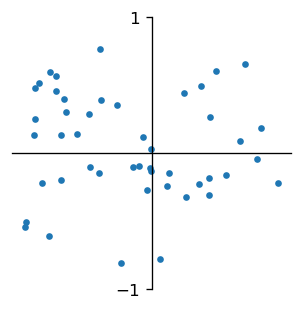

<Figure size 432x288 with 0 Axes>

In [186]:
fig=plt.figure(dpi=120,figsize=(3,3))

# plot1=plt.plot(x_x, y_x, '.',label='original values')
# plt.xlabel('X-position/um')
# plt.ylabel('delta X/um')
plot1=plt.plot(x_y, y_y, '.',label='original values')
# plt.xlabel('Y-position/um')
# plt.ylabel('delta Y/um')
# plot1=plt.plot(x_z, y_z, '.',label='original values')
# plt.xlabel('Z-position/um')
# plt.ylabel('delta Z/um')

# z1 = np.polyfit(x, y, 1) 
# p1 = np.poly1d(z1)
# yvals=p1(x) 
# plot2=plt.plot(x, yvals, 'r',label='polyfit values')

# plt.ylim([-1,1])
y_ticks = np.arange(-1, 2, 2)
x_ticks = np.arange(-200, 2, 400)
plt.xticks(x_ticks)
plt.yticks(y_ticks)

sns.despine() 
ax=plt.gca()  #gca:get current axis
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))  # set x-axis y=0
ax.spines['left'].set_position(('axes',0.5))  # axes 50% means in the x middle


# plt.title('Lipofuscin distance vs X position')
plt.show()
plt.tight_layout()

Estimated coefficients (true, linear regression, RANSAC):


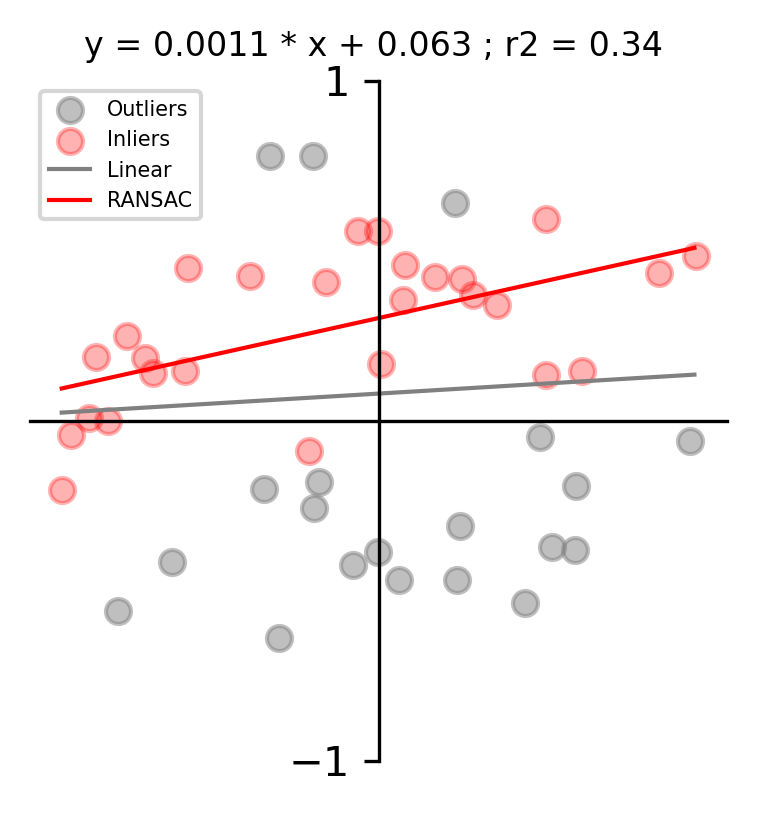

<Figure size 432x288 with 0 Axes>

In [188]:
## Robust linear model estimation using RANSAC
from sklearn import linear_model, datasets
from sklearn.metrics import r2_score

X = x_x.reshape(-1, 1)
y = y_x
# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X,y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
#     print(coef, lr.coef_, ransac.estimator_.coef_)

fig,ax=plt.subplots(dpi=120,figsize=(3,3))
lw = 1
plt.scatter(X[outlier_mask], y[outlier_mask], alpha=0.5, color='gray', marker='o',
            label='Outliers')
plt.scatter(X[inlier_mask], y[inlier_mask], alpha=0.3, color='red', marker='o',
            label='Inliers')
sns.despine() 
plt.plot(line_X, line_y, color='gray', linewidth=lw, label='Linear')
plt.plot(line_X, line_y_ransac, color='red', linewidth=lw,
         label='RANSAC')
plt.legend(loc='upper left', fontsize = 5)

plt.ylim([-1,1])
y_ticks = np.arange(-1, 2, 2)
x_ticks = np.arange(-200, 2, 400)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
# DD

X1 = np.reshape(X[inlier_mask],y[inlier_mask].shape[0])
m, b = np.polyfit(X1, y[inlier_mask], 1)
# plt.plot(X1, m*X1 + b, color='cyan')  

plt.title(("y = {:.4f} * x + {:.3f} ; r2 = {:.2f} ".format(
    m, b, r2_score(y[inlier_mask], m*X1 + b))),fontsize = 8)

ax=plt.gca()  #gca:get current axis
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data',0))  # set x-axis y=0
ax.spines['left'].set_position(('axes',0.5))  # axes 50% means in the x middle

plt.show()
plt.tight_layout()

#### Register lipofuscin for multiple channels, export tranformation matrix

In [213]:
#fpfh registration for fixed round
neighbor_radius2 = 1 #1 um
neighbor_radius1 = 3 #3 um
neighbor_radius0 = 3 #6 um
# fix_spots_new = lipo_c0[:,:3]
# spot_mov = lipo_c1[:,:3]

# fix_spots_new = Distance_lipo[:,4:7]
# spot_mov = Distance_lipo[:,7:10]

fix_spots_new = np.loadtxt(seg_dir + 'RS-FISH/lipospots_R2_c0.txt', delimiter=',')
spot_mov = np.loadtxt(seg_dir + 'RS-FISH/lipospots_R2_c1.txt', delimiter=',')

lipo_c0,lipo_c1,_,_,dist2,P1,P2 = colocalization(fix_spots_new,spot_mov,neighbor_radius1)  # return in pixel
distances1 = eucldist(lipo_c0,lipo_c1)
print('% P1: ',str(P1) + ';  % P2: ',str(P2))
print(f'Pre_ransac_Distance: {np.mean(distances1)}')

result_ransac,icp_p2p,mov_spots1,BB = ransac_fpfh_registration(fix_spots_new,spot_mov,neighbor_radius0) # return in um 
if np.isnan(BB[0][0]):
    icp_p2p.transformation = result_ransac.transformation
    BB = mov_spots1

lipo_c0,lipo_c1,_,_,dist2,P1,P2 = colocalization(fix_spots_new,BB,neighbor_radius1)  # return in pixel
distances2 = eucldist(lipo_c0,lipo_c1)
print('% P1: ',str(P1) + ';  % P2: ',str(P2))
print(f'ransac_Distance: {np.mean(distances2)}')
global_affine = icp_p2p.transformation

A = fix_spots_new[:,:3]
B = BB[:,:3]
Transform,_,_ = icp(A, B,neighbor_radius2) 
p = np.append(B, np.ones((B.shape[0],1)), axis=1)        
D = p.dot(np.linalg.inv(Transform).T)        ## B->A spots (right) with B->A transform (right)
C = D[:,:3]

# Test ICP distance change. Minor increased performance
lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(fix_spots_new,C,neighbor_radius1)  # return in pixel
print('% P1: ',str(P1) + ';  % P2: ',str(P2))
pair_dist = eucldist(lipo_c0,lipo_c1)
print(f'ICP_Distance: {np.mean(pair_dist)}')

# transform orginal points

## apply cca affine for mov spots
points2 = np.append(mov_spots[:,:3], np.ones((mov_spots.shape[0],1)), axis=1)
# inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg
inv_Transform = global_affine
warp_spots_2 = points2.dot(np.linalg.inv(inv_Transform).T)[:,:3]
points2 = np.append(warp_spots_2[:,:3], np.ones((warp_spots_2.shape[0],1)), axis=1)
mov_spots_new = points2.dot(np.linalg.inv(Transform).T)

fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(distances1,distances2,pair_dist)
plt.violinplot(distances1)
plt.violinplot(pair_dist)
plt.ylabel('Distance/um')
sns.despine() 
plt.show()
plt.tight_layout()

% P1:  100.0;  % P2:  100.0
Pre_ransac_Distance: 0.5233758262681101
we use a liberal distance threshold 0.750.
RegistrationResult with fitness=6.333333e-01, inlier_rmse=5.003898e-01, and correspondence_set size of 38
Access transformation to get result.
RegistrationResult with fitness=7.833333e-01, inlier_rmse=2.267688e-01, and correspondence_set size of 47
Access transformation to get result.
% P1:  100.0;  % P2:  100.0
ransac_Distance: 0.3660052899283516
% P1:  100.0;  % P2:  100.0
ICP_Distance: 0.3742296621234779


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_7500\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


### Apply transformation to the raw_image

In [ ]:
R_dir = 'Z:/sternsonlab/Zhenggang/Gary_analysis/outputs/LHA_5_R2_R10_0725/'
R_n = 'LHA_5_R2_4x4'
path= R_dir + R_n + '/stitching/export.n5'
subpath1=['c0','c1','c2','c3']
subpath2='/s3'
im_0 = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1[0]+subpath2]
im_1 = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1[1]+subpath2]
viewer.add_image(im_0,colormap='green',blending='additive') #load image data into napari
viewer.add_image(im_1,colormap='magenta',blending='additive') #load image data into napari

fix_ds = 
moving_ROI_new = 
mov_affine_0 = transform.apply_global_affine(fix_ds, moving_ROI_new,fix_spacing,fix_spacing,global_affine,)
mov_ds = transform.apply_global_affine(fix_ds,mov_affine_0,fix_spacing,fix_spacing,Transform,)

#### save txt

In [211]:
seg_dir='E:/Maxprobe_analysis/LHA_R2_R10/'
np.savetxt(seg_dir + 'RS-FISH/lipospots_R2_c0.txt', fix_spots_new, delimiter=',')   # X is an array
np.savetxt(seg_dir + 'RS-FISH/lipospots_R2_c1.txt', spot_mov, delimiter=',')   # X is an array
np.savetxt(seg_dir + 'RS-FISH/spots_c1_cca.txt', mov_spots_new, delimiter=',')   # X is an array

% P1:  100.0;  % P2:  100.0
Pre_ransac_Distance: 0.709736332099515
we use a liberal distance threshold 2.250.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=8.323006e-01, and correspondence_set size of 47
Access transformation to get result.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=7.205084e-01, and correspondence_set size of 47
Access transformation to get result.
% P1:  100.0;  % P2:  100.0
ransac_Distance: 0.6917814946121338
% P1:  100.0;  % P2:  100.0
ICP_Distance: 0.6928487957876945


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_7500\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


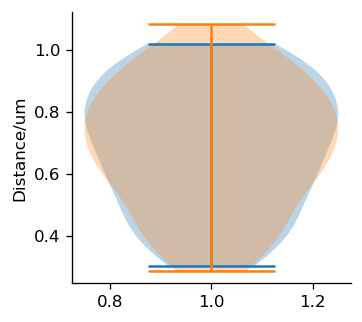

<Figure size 432x288 with 0 Axes>

In [224]:
#fpfh for moving round
neighbor_radius2 = 1 #1 um
neighbor_radius1 = 3 #3 um
neighbor_radius0 = 9 #6 um
fix_spots_new = lipo_c0000
spot_mov = lipo_c1111

fix_spots_new = np.loadtxt(seg_dir + 'RS-FISH/lipospots_R10_c0.txt', delimiter=',')
spot_mov = np.loadtxt(seg_dir + 'RS-FISH/lipospots_R10_c1.txt', delimiter=',')
lipo_c0,lipo_c1,_,_,dist2,P1,P2 = colocalization(fix_spots_new,spot_mov,neighbor_radius1)  # return in pixel
distances1 = eucldist(lipo_c0,lipo_c1)
print('% P1: ',str(P1) + ';  % P2: ',str(P2))
print(f'Pre_ransac_Distance: {np.mean(distances1)}')

result_ransac,icp_p2p,mov_spots1,BB = ransac_fpfh_registration(fix_spots_new,spot_mov,neighbor_radius0) # return in um 
if np.isnan(BB[0][0]):
    icp_p2p.transformation = result_ransac.transformation
    BB = mov_spots1

lipo_c0,lipo_c1,_,_,dist2,P1,P2 = colocalization(fix_spots_new,BB,neighbor_radius1)  # return in pixel
distances2 = eucldist(lipo_c0,lipo_c1)
print('% P1: ',str(P1) + ';  % P2: ',str(P2))
print(f'ransac_Distance: {np.mean(distances2)}')
global_affine = icp_p2p.transformation

A = fix_spots_new[:,:3]
B = BB[:,:3]
Transform,_,_ = icp(A, B,neighbor_radius2) 
p = np.append(B, np.ones((B.shape[0],1)), axis=1)        
D = p.dot(np.linalg.inv(Transform).T)        ## B->A spots (right) with B->A transform (right)
C = D[:,:3]

# Test ICP distance change. Minor increased performance
lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(fix_spots_new,C,neighbor_radius1)  # return in pixel
print('% P1: ',str(P1) + ';  % P2: ',str(P2))
pair_dist = eucldist(lipo_c0,lipo_c1)
print(f'ICP_Distance: {np.mean(pair_dist)}')

## apply cca affine for mov spots
points2 = np.append(mov_spots0[:,:3], np.ones((mov_spots0.shape[0],1)), axis=1)
# inv_Transform = np.row_stack((global_affine,np.array([[0,0,0,1]]))) #FIX->FIX_reg
inv_Transform = global_affine
warp_spots_2 = points2.dot(np.linalg.inv(inv_Transform).T)[:,:3]
points2 = np.append(warp_spots_2[:,:3], np.ones((warp_spots_2.shape[0],1)), axis=1)
mov_spots0_new = points2.dot(np.linalg.inv(Transform).T)

fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(distances1,distances2,pair_dist)
plt.violinplot(distances2)
plt.violinplot(pair_dist)
plt.ylabel('Distance/um')
sns.despine() 
plt.show()
plt.tight_layout()

#### save txt

In [225]:
seg_dir='E:/Maxprobe_analysis/LHA_R2_R10/'
np.savetxt(seg_dir + 'RS-FISH/lipospots_R10_c0.txt', fix_spots_new, delimiter=',')   # X is an array
np.savetxt(seg_dir + 'RS-FISH/lipospots_R10_c1.txt', spot_mov, delimiter=',')   # X is an array
np.savetxt(seg_dir + 'RS-FISH/spots_c1_warped_cca.txt', mov_spots0_new, delimiter=',')   # X is an array

### Grouping registration for true spots of 3 channels 

In [196]:
%%time  
seg_dir='E:/Maxprobe_analysis/LHA_R2_R10/'
spot_fix_c3_all1 = np.zeros((1, 4))
warp_spots_c3_all1 = np.zeros((1, 4))
spot_fix_c1_all1 = np.zeros((1, 4))
warp_spots_c1_all1 = np.zeros((1, 4))
spot_fix_c0_all1 = np.zeros((1, 4))
warp_spots_c0_all1 = np.zeros((1, 4))

spot_fix_c3_cyto1 = np.zeros((1, 4))
warp_spots_c3_cyto1 = np.zeros((1, 4))
spot_fix_c1_cyto1 = np.zeros((1, 4))
warp_spots_c1_cyto1 = np.zeros((1, 4))
spot_fix_c0_cyto1 = np.zeros((1, 4))
warp_spots_c0_cyto1 = np.zeros((1, 4))

spot_fix_c3_nuc1 = np.zeros((1, 4))
warp_spots_c3_nuc1 = np.zeros((1, 4))
spot_fix_c1_nuc1 = np.zeros((1, 4))
warp_spots_c1_nuc1 = np.zeros((1, 4))
spot_fix_c0_nuc1 = np.zeros((1, 4))
warp_spots_c0_nuc1 = np.zeros((1, 4))

fix_spacing=np.array([0.42,0.23,0.23])
j=0
Rounds = ["R2","R10"]
Shuffle_spots = 0
ROI_id = np.unique(segmentation1[segmentation1!=0])
Dist_sum_1 = np.zeros((len(ROI_id), 6)) # directory to file containing the registration stats
neighbor_radius0 = 6 #6 um
    
for aa in ROI_id:
#             aa = 43
            ROI_moving = aa
            print('ROI_fix: ' + str(aa) + '; ROI_moving: ' + str(ROI_moving))
            Global_detection = 1
            ransac_affine = 1 ## 1 is to apply local ransac affine (not use image) before ICP,0 is used orginal point cloud for ICP.
            image_ransac = 0 # > 0 is to get point correspondences from image after using nearest neighbors ; or 0 is to use nearest neighbors for local ransac
            hAir = 0 # 0 is RS-FISH; 1 is for hAirlocalize
            ROI_moving = aa
            roi_dir = fix_path + '/0/R2_' + str(aa) + '_C2.tif'
            fixed_ROI_c2 = imread(roi_dir)
            
            # read all images
            Chn = "c0"
            roi_dir = fix_path + '/s2' + '/R2_' + str(aa) + '_'+ Chn + '.tif'
            fixed_ROI_c0 = imread(roi_dir)
            roi_dir = fix_path + '/s2' + '/R10_' + str(aa) + '_'+ Chn + '.tif'
            moving_ROI_c0 = imread(roi_dir)
            
            Chn = "c1"
            roi_dir = fix_path + '/s2' + '/R2_' + str(aa) + '_'+ Chn + '.tif'
            fixed_ROI_c1 = imread(roi_dir)
            roi_dir = fix_path + '/s2' + '/R10_' + str(aa) + '_'+ Chn + '.tif'
            moving_ROI_c1 = imread(roi_dir)
            
#             spotdir = seg_dir + 'R2ROI_points_fix.txt'
#             Rounds = ["R2","R10"]
#             global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,Transform_mov,affine_borrow_idx = cca(
#                 seg_dir,spotdir,aa,Rounds)
            image_ransac = 1 # number is specific distance threshold 
            # save rgb images
            Chn = ["C0","C1","C3"]
            if Chn == ["C0","C1","C3"]:

                fixed_ROI_c0,transform_ROI_c0,moving_ROI_c0,P1_C3,P2_C3,pre_dist_013,mid_dist_013,pair_dist_013,fix_spots_013,mov_spots_013,warp_spots_new_013,cc_3,fix_spots_cyto013,fix_spots_nuc013,warp_spots_new_cyto013,warp_spots_new_nuc013 = ROI_trackaffine_cca_grouping_fpfh_bash(
                seg_dir,segmentation1,segmentation2,aa,ROI_moving,fixed_ROI_c2,Chn,Global_detection,image_ransac,hAir,neighbor_radius0,
                Shuffle_spots,fixed_ROI_c0,moving_ROI_c0,fixed_ROI_c1,moving_ROI_c1)
                distances_1 = np.mean(pre_dist_013)
                distances_2 = np.mean(mid_dist_013)
                distances_3 = np.mean(pair_dist_013)

            # save ALL spots, global affine, warp affine.  
            cc_0 = cc_1 = cc_3
            
            fix_spots_0 = fix_spots_013[fix_spots_013[:,3] == 0]
            fix_spots_1 = fix_spots_013[fix_spots_013[:,3] == 1]
#             fix_spots_3 = fix_spots_013[fix_spots_013[:,3] == 2]
            warp_spots_new_0 = warp_spots_new_013[warp_spots_new_013[:,3] == 0]
            warp_spots_new_1 = warp_spots_new_013[warp_spots_new_013[:,3] == 1]
#             warp_spots_new_3 = warp_spots_new_013[warp_spots_new_013[:,3] == 2]
            STOP
            # save C3 spots, global affine, warp affine.
#             spot_fix3 = fix_spots_3[:,:3] /fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # pre:in um, post: in px[um to px + mask(0, in px)]
#             spot_fix_c3 = np.column_stack((spot_fix3,np.ones(len(spot_fix3)).dot(aa))) # add ROI_ID
#             spot_fix_c3_all1 = np.row_stack((spot_fix_c3_all1,spot_fix_c3))   # for all ROIs
#             warp_spots_3 = warp_spots_new_3[:,:3]/fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # in pixels of S2
#             warp_spots_new_c3 = np.column_stack((warp_spots_3,np.ones(len(warp_spots_new_3)).dot(aa)))
#             warp_spots_c3_all1 = np.row_stack((warp_spots_c3_all1,warp_spots_new_c3))

            # save C1 spots, global affine, warp affine.
            spot_fix1 = fix_spots_1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_all1 = np.row_stack((spot_fix_c1_all1,spot_fix_c1))
            warp_spots_1 = warp_spots_new_1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
            warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_1)).dot(aa)))
            warp_spots_c1_all1 = np.row_stack((warp_spots_c1_all1,warp_spots_new_c1))
            
            # save C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_all1 = np.row_stack((spot_fix_c0_all1,spot_fix_c0))
            warp_spots_0 = warp_spots_new_0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_0)).dot(aa)))
            warp_spots_c0_all1 = np.row_stack((warp_spots_c0_all1,warp_spots_new_c0))
            
            ###########  save cyto C1 spots, global affine, warp affine.
            fix_spots_cyto0 = fix_spots_cyto013[fix_spots_cyto013[:,3] == 0]
            fix_spots_cyto1 = fix_spots_cyto013[fix_spots_cyto013[:,3] == 1]
            #             fix_spots_cyto3 = fix_spots_cyto013[fix_spots_cyto013[:,3] == 2]
            warp_spots_new_cyto0 = warp_spots_new_cyto013[warp_spots_new_cyto013[:,3] == 0]
            warp_spots_new_cyto1 = warp_spots_new_cyto013[warp_spots_new_cyto013[:,3] == 1]
            #             warp_spots_new_cyto3 = warp_spots_new_cyto013[warp_spots_new_cyto013[:,3] == 2]

            spot_fix1 = fix_spots_cyto1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_cyto1 = np.row_stack((spot_fix_c1_cyto1,spot_fix_c1))
            if warp_spots_new_1.shape[0] == 0:
                warp_spots_c1_cyto1 = warp_spots_c1_cyto1
            else:
                warp_spots_1 = warp_spots_new_cyto1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
                warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_cyto1)).dot(aa)))
                warp_spots_c1_cyto1 = np.row_stack((warp_spots_c1_cyto1,warp_spots_new_c1))

            # save cyto C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_cyto0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_cyto1 = np.row_stack((spot_fix_c0_cyto1,spot_fix_c0))
            warp_spots_0 = warp_spots_new_cyto0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_cyto0)).dot(aa)))
            warp_spots_c0_cyto1 = np.row_stack((warp_spots_c0_cyto1,warp_spots_new_c0))            

            ###########  save nuc C1 spots, global affine, warp affine.
            fix_spots_nuc0 = fix_spots_nuc013[fix_spots_nuc013[:,3] == 0]
            fix_spots_nuc1 = fix_spots_nuc013[fix_spots_nuc013[:,3] == 1]
            #             fix_spots_nuc3 = fix_spots_nuc013[fix_spots_nuc013[:,3] == 2]
            warp_spots_new_nuc0 = warp_spots_new_nuc013[warp_spots_new_nuc013[:,3] == 0]
            warp_spots_new_nuc1 = warp_spots_new_nuc013[warp_spots_new_nuc013[:,3] == 1]
            #             warp_spots_new_nuc3 = warp_spots_new_nuc013[warp_spots_new_nuc013[:,3] == 2]


            spot_fix1 = fix_spots_nuc1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_nuc1 = np.row_stack((spot_fix_c1_nuc1,spot_fix_c1))
            if warp_spots_new_1.shape[0] == 0:
                warp_spots_c1_nuc1 = warp_spots_c1_nuc1
            else:
                warp_spots_1 = warp_spots_new_nuc1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
                warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_nuc1)).dot(aa)))
                warp_spots_c1_nuc1 = np.row_stack((warp_spots_c1_nuc1,warp_spots_new_c1))

            # save nuc C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_nuc0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_nuc1 = np.row_stack((spot_fix_c0_nuc1,spot_fix_c0))
            warp_spots_0 = warp_spots_new_nuc0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_nuc0)).dot(aa)))
            warp_spots_c0_nuc1 = np.row_stack((warp_spots_c0_nuc1,warp_spots_new_c0))            


            # affine_borrow[j,:] = affine_borrow_idx
            # remember to remove the first 000 coordinates
            Dist_sum_1[j,:] = [aa,distances_1,distances_2,distances_3,P1_C3,P2_C3]
            j = j + 1

ROI_fix: 8; ROI_moving: 8
RS-FISH points from cluster
FIXED: found 808 key points; MOVING: found 887 key points
Image: found 417 key points outside ROI
47.01240135287486
Image: found 31 key points outside ROI
pre-ransac_Distance: 0.7218770778561769
Found 521 matched fixed points
Found 521 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=8.602029e-01, inlier_rmse=9.042400e-01, and correspondence_set size of 763
Access transformation to get result.
RegistrationResult with fitness=6.144307e-01, inlier_rmse=6.584040e-01, and correspondence_set size of 545
Access transformation to get result.
ransac_Distance: 0.5966069699399961
Image: found 15 key points outside ROI
% P1:  60.74646074646075;  % P2:  54.12844036697248
ICP_Distance: 0.5916048962535464


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12184\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


NameError: name 'STOP' is not defined

In [198]:
# viewer = napari.view_image(data.astronaut(), rgb=True)
# napari.run()

viewer.add_image(fixed_ROI_c0,colormap='magenta',blending='additive') #load image data into napari
viewer.add_image(moving_ROI_c0,colormap='green',blending='additive') #load image data into napari
viewer.add_image(transform_ROI_c0,colormap='green',blending='additive') #load image data into napari

s=fix_spots_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0', size=5,
                  face_color='green',edge_color='green',blending='opaque')

s=mov_spots_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_mov', size=5,
                  face_color='magenta',edge_color='magenta',blending='opaque')

s=warp_spots_new_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_warp', size=5,
                  face_color='magenta',edge_color='magenta',blending='opaque')

C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'c0_warp' at 0x2adb9d9e4c0>

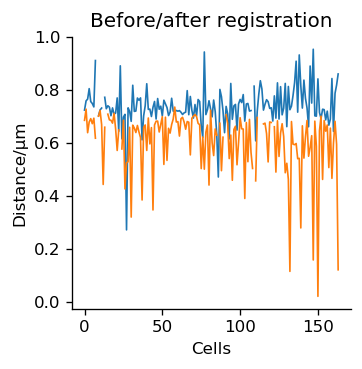

<Figure size 432x288 with 0 Axes>

In [152]:
## plot all distance
fig=plt.figure(dpi=120,figsize=(3,3))
plt.plot(Dist_sum_11[:,1],linewidth=1)
# plt.plot(Dist_sum_1[:,2],linewidth=1)
plt.plot(Dist_sum_11[:,3],linewidth=1)
sns.despine() 
plt.xlabel('Cells')
plt.ylabel('Distance/μm')
plt.title('Before/after registration')
plt.show()
plt.tight_layout()

### cca for three channels
### track shift; open DAPI for green channel，use both bleedthrough for alignment

### Group registration for simulated spots of 3 channels

In [142]:
%%time  
seg_dir='E:/Maxprobe_analysis/LHA_R2_R10/'
spot_fix_c3_all1 = np.zeros((1, 4))
warp_spots_c3_all1 = np.zeros((1, 4))
spot_fix_c1_all1 = np.zeros((1, 4))
warp_spots_c1_all1 = np.zeros((1, 4))
spot_fix_c0_all1 = np.zeros((1, 4))
warp_spots_c0_all1 = np.zeros((1, 4))

spot_fix_c3_cyto1 = np.zeros((1, 4))
warp_spots_c3_cyto1 = np.zeros((1, 4))
spot_fix_c1_cyto1 = np.zeros((1, 4))
warp_spots_c1_cyto1 = np.zeros((1, 4))
spot_fix_c0_cyto1 = np.zeros((1, 4))
warp_spots_c0_cyto1 = np.zeros((1, 4))

spot_fix_c3_nuc1 = np.zeros((1, 4))
warp_spots_c3_nuc1 = np.zeros((1, 4))
spot_fix_c1_nuc1 = np.zeros((1, 4))
warp_spots_c1_nuc1 = np.zeros((1, 4))
spot_fix_c0_nuc1 = np.zeros((1, 4))
warp_spots_c0_nuc1 = np.zeros((1, 4))

fix_spacing=np.array([0.42,0.23,0.23])
j=0
Shuffle_spots = 1
ROI_id = np.unique(segmentation1[segmentation1!=0])
Dist_sum_11 = np.zeros((len(ROI_id), 6)) # directory to file containing the registration stats
neighbor_radius0 = 6 #6 um
    
for aa in ROI_id:
#             aa = 43
            ROI_moving = aa
            print('ROI_fix: ' + str(aa) + '; ROI_moving: ' + str(ROI_moving))
            Global_detection = 1
            ransac_affine = 1 ## 1 is to apply local ransac affine (not use image) before ICP,0 is used orginal point cloud for ICP.
            image_ransac = 0 # > 0 is to get point correspondences from image after using nearest neighbors ; or 0 is to use nearest neighbors for local ransac
            hAir = 0 # 0 is RS-FISH; 1 is for hAirlocalize
            ROI_moving = aa
            roi_dir = fix_path + '/0/R2_' + str(aa) + '_C2.tif'
            fixed_ROI_c2 = imread(roi_dir)
            
            # read all images
            Chn = "c0"
            roi_dir = fix_path + '/s2' + '/R2_' + str(aa) + '_'+ Chn + '.tif'
            fixed_ROI_c0 = imread(roi_dir)
            roi_dir = fix_path + '/s2' + '/R10_' + str(aa) + '_'+ Chn + '.tif'
            moving_ROI_c0 = imread(roi_dir)
            
            Chn = "c1"
            roi_dir = fix_path + '/s2' + '/R2_' + str(aa) + '_'+ Chn + '.tif'
            fixed_ROI_c1 = imread(roi_dir)
            roi_dir = fix_path + '/s2' + '/R10_' + str(aa) + '_'+ Chn + '.tif'
            moving_ROI_c1 = imread(roi_dir)
            
#             spotdir = seg_dir + 'R2ROI_points_fix.txt'
#             Rounds = ["R2","R10"]
#             global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,Transform_mov,affine_borrow_idx = cca(
#                 seg_dir,spotdir,aa,Rounds)
            image_ransac = 1 # number is specific distance threshold 
            # save rgb images
            Chn = ["C0","C1","C3"]
            if Chn == ["C0","C1","C3"]:

                P1_C3,P2_C3,pre_dist_013,mid_dist_013,pair_dist_013,fix_spots_013,mov_spots_013,warp_spots_new_013,cc_3,fix_spots_cyto013,fix_spots_nuc013,warp_spots_new_cyto013,warp_spots_new_nuc013 = ROI_trackaffine_cca_grouping_fpfh_bash(
                seg_dir,segmentation1,segmentation2,aa,ROI_moving,fixed_ROI_c2,Chn,Global_detection,image_ransac,hAir,neighbor_radius0,
                Shuffle_spots,fixed_ROI_c0,moving_ROI_c0,fixed_ROI_c1,moving_ROI_c1)
                distances_1 = np.mean(pre_dist_013)
                distances_2 = np.mean(mid_dist_013)
                distances_3 = np.mean(pair_dist_013)

            # save ALL spots, global affine, warp affine.  
            cc_0 = cc_1 = cc_3
            
            fix_spots_0 = fix_spots_013[fix_spots_013[:,3] == 0]
            fix_spots_1 = fix_spots_013[fix_spots_013[:,3] == 1]
#             fix_spots_3 = fix_spots_013[fix_spots_013[:,3] == 2]
            warp_spots_new_0 = warp_spots_new_013[warp_spots_new_013[:,3] == 0]
            warp_spots_new_1 = warp_spots_new_013[warp_spots_new_013[:,3] == 1]
#             warp_spots_new_3 = warp_spots_new_013[warp_spots_new_013[:,3] == 2]

            # save C3 spots, global affine, warp affine.
#             spot_fix3 = fix_spots_3[:,:3] /fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # pre:in um, post: in px[um to px + mask(0, in px)]
#             spot_fix_c3 = np.column_stack((spot_fix3,np.ones(len(spot_fix3)).dot(aa))) # add ROI_ID
#             spot_fix_c3_all1 = np.row_stack((spot_fix_c3_all1,spot_fix_c3))   # for all ROIs
#             warp_spots_3 = warp_spots_new_3[:,:3]/fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # in pixels of S2
#             warp_spots_new_c3 = np.column_stack((warp_spots_3,np.ones(len(warp_spots_new_3)).dot(aa)))
#             warp_spots_c3_all1 = np.row_stack((warp_spots_c3_all1,warp_spots_new_c3))

            # save C1 spots, global affine, warp affine.
            spot_fix1 = fix_spots_1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_all1 = np.row_stack((spot_fix_c1_all1,spot_fix_c1))
            warp_spots_1 = warp_spots_new_1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
            warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_1)).dot(aa)))
            warp_spots_c1_all1 = np.row_stack((warp_spots_c1_all1,warp_spots_new_c1))
            
            # save C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_all1 = np.row_stack((spot_fix_c0_all1,spot_fix_c0))
            warp_spots_0 = warp_spots_new_0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_0)).dot(aa)))
            warp_spots_c0_all1 = np.row_stack((warp_spots_c0_all1,warp_spots_new_c0))
            
            ###########  save cyto C1 spots, global affine, warp affine.
            fix_spots_cyto0 = fix_spots_cyto013[fix_spots_cyto013[:,3] == 0]
            fix_spots_cyto1 = fix_spots_cyto013[fix_spots_cyto013[:,3] == 1]
            #             fix_spots_cyto3 = fix_spots_cyto013[fix_spots_cyto013[:,3] == 2]
            warp_spots_new_cyto0 = warp_spots_new_cyto013[warp_spots_new_cyto013[:,3] == 0]
            warp_spots_new_cyto1 = warp_spots_new_cyto013[warp_spots_new_cyto013[:,3] == 1]
            #             warp_spots_new_cyto3 = warp_spots_new_cyto013[warp_spots_new_cyto013[:,3] == 2]

            spot_fix1 = fix_spots_cyto1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_cyto1 = np.row_stack((spot_fix_c1_cyto1,spot_fix_c1))
            if warp_spots_new_1.shape[0] == 0:
                warp_spots_c1_cyto1 = warp_spots_c1_cyto1
            else:
                warp_spots_1 = warp_spots_new_cyto1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
                warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_cyto1)).dot(aa)))
                warp_spots_c1_cyto1 = np.row_stack((warp_spots_c1_cyto1,warp_spots_new_c1))

            # save cyto C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_cyto0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_cyto1 = np.row_stack((spot_fix_c0_cyto1,spot_fix_c0))
            warp_spots_0 = warp_spots_new_cyto0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_cyto0)).dot(aa)))
            warp_spots_c0_cyto1 = np.row_stack((warp_spots_c0_cyto1,warp_spots_new_c0))            

            ###########  save nuc C1 spots, global affine, warp affine.
            fix_spots_nuc0 = fix_spots_nuc013[fix_spots_nuc013[:,3] == 0]
            fix_spots_nuc1 = fix_spots_nuc013[fix_spots_nuc013[:,3] == 1]
            #             fix_spots_nuc3 = fix_spots_nuc013[fix_spots_nuc013[:,3] == 2]
            warp_spots_new_nuc0 = warp_spots_new_nuc013[warp_spots_new_nuc013[:,3] == 0]
            warp_spots_new_nuc1 = warp_spots_new_nuc013[warp_spots_new_nuc013[:,3] == 1]
            #             warp_spots_new_nuc3 = warp_spots_new_nuc013[warp_spots_new_nuc013[:,3] == 2]


            spot_fix1 = fix_spots_nuc1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_nuc1 = np.row_stack((spot_fix_c1_nuc1,spot_fix_c1))
            if warp_spots_new_1.shape[0] == 0:
                warp_spots_c1_nuc1 = warp_spots_c1_nuc1
            else:
                warp_spots_1 = warp_spots_new_nuc1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
                warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_nuc1)).dot(aa)))
                warp_spots_c1_nuc1 = np.row_stack((warp_spots_c1_nuc1,warp_spots_new_c1))

            # save nuc C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_nuc0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_nuc1 = np.row_stack((spot_fix_c0_nuc1,spot_fix_c0))
            warp_spots_0 = warp_spots_new_nuc0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_nuc0)).dot(aa)))
            warp_spots_c0_nuc1 = np.row_stack((warp_spots_c0_nuc1,warp_spots_new_c0))            


            # affine_borrow[j,:] = affine_borrow_idx
            # remember to remove the first 000 coordinates
            Dist_sum_11[j,:] = [aa,distances_1,distances_2,distances_3,P1_C3,P2_C3]
            j = j + 1

ROI_fix: 8; ROI_moving: 8
RS-FISH points from cluster
FIXED: found 808 key points; MOVING: found 887 key points
Image: found 417 key points outside ROI
47.01240135287486
Image: found 31 key points outside ROI
pre-ransac_Distance: 0.725026573791327
Found 432 matched fixed points
Found 432 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=4.960541e-01, inlier_rmse=1.082106e+00, and correspondence_set size of 440
Access transformation to get result.
RegistrationResult with fitness=2.096956e-01, inlier_rmse=7.221912e-01, and correspondence_set size of 186
Access transformation to get result.
ransac_Distance: 0.684748560332197
Image: found 82 key points outside ROI
% P1:  21.62162162162162;  % P2:  20.869565217391305
ICP_Distance: 0.6863487560193414
ROI_fix: 10; ROI_moving: 10


C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12184\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


RS-FISH points from cluster
FIXED: found 631 key points; MOVING: found 610 key points
Image: found 299 key points outside ROI
49.01639344262295
Image: found 19 key points outside ROI
pre-ransac_Distance: 0.7598841159779592
Found 317 matched fixed points
Found 317 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=3.655738e-01, inlier_rmse=1.103117e+00, and correspondence_set size of 223
Access transformation to get result.
RegistrationResult with fitness=1.524590e-01, inlier_rmse=7.645250e-01, and correspondence_set size of 93
Access transformation to get result.
ransac_Distance: 0.737323197560328
Image: found 82 key points outside ROI
% P1:  12.745098039215685;  % P2:  14.772727272727273
ICP_Distance: 0.7286770595700962
ROI_fix: 15; ROI_moving: 15
RS-FISH points from cluster
FIXED: found 474 key points; MOVING: found 489 key points
Image: found 145 key points outside ROI
29.652351738241308
Image: found 18 key points outside ROI
pre-ransac_

RS-FISH points from cluster
FIXED: found 68 key points; MOVING: found 91 key points
Image: found 21 key points outside ROI
23.076923076923077
Image: found 0 key points outside ROI
pre-ransac_Distance: nan
Found 40 matched fixed points
Found 40 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.428571e-01, inlier_rmse=9.711118e-01, and correspondence_set size of 13
Access transformation to get result.
RegistrationResult with fitness=6.593407e-02, inlier_rmse=4.419780e-01, and correspondence_set size of 6
Access transformation to get result.
ransac_Distance: 0.34879912587890216
Image: found 33 key points outside ROI
% P1:  5.88235294117647;  % P2:  6.896551724137931
ICP_Distance: 0.4440326831037239
ROI_fix: 58; ROI_moving: 58
RS-FISH points from cluster
FIXED: found 458 key points; MOVING: found 446 key points
Image: found 177 key points outside ROI
39.68609865470852
Image: found 21 key points outside ROI
pre-ransac_Distance: 0.773461029237

C:\Users\zhenggang\AppData\Local\Temp\ipykernel_12184\2236698611.py:227: RuntimeWarning: invalid value encountered in double_scalars
  mean_error = np.sum(distances) / distances.size


RS-FISH points from cluster
FIXED: found 995 key points; MOVING: found 913 key points
Image: found 320 key points outside ROI
35.049288061336256
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.7414550208041982
Found 452 matched fixed points
Found 452 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=4.928806e-01, inlier_rmse=1.056331e+00, and correspondence_set size of 450
Access transformation to get result.
RegistrationResult with fitness=2.311062e-01, inlier_rmse=7.349909e-01, and correspondence_set size of 211
Access transformation to get result.
ransac_Distance: 0.7021815611196393
Image: found 29 key points outside ROI
% P1:  19.22685656154629;  % P2:  21.380090497737555
ICP_Distance: 0.7096690030649528
ROI_fix: 71; ROI_moving: 71
RS-FISH points from cluster
FIXED: found 480 key points; MOVING: found 490 key points
Image: found 228 key points outside ROI
46.53061224489796
Image: found 28 key points outside ROI
pre-ransac

RegistrationResult with fitness=3.922652e-01, inlier_rmse=1.069780e+00, and correspondence_set size of 213
Access transformation to get result.
RegistrationResult with fitness=1.731123e-01, inlier_rmse=7.235452e-01, and correspondence_set size of 94
Access transformation to get result.
ransac_Distance: 0.6917925868178403
Image: found 117 key points outside ROI
% P1:  15.789473684210526;  % P2:  19.718309859154928
ICP_Distance: 0.686725360578507
ROI_fix: 122; ROI_moving: 122
RS-FISH points from cluster
FIXED: found 147 key points; MOVING: found 139 key points
Image: found 45 key points outside ROI
32.37410071942446
Image: found 10 key points outside ROI
pre-ransac_Distance: 0.7089827412538021
Found 70 matched fixed points
Found 70 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=2.302158e-01, inlier_rmse=1.105736e+00, and correspondence_set size of 32
Access transformation to get result.
RegistrationResult with fitness=9.352518e-02, inlier

RS-FISH points from cluster
FIXED: found 332 key points; MOVING: found 325 key points
Image: found 131 key points outside ROI
40.30769230769231
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.7711663335356347
Found 164 matched fixed points
Found 164 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=2.246154e-01, inlier_rmse=1.116350e+00, and correspondence_set size of 73
Access transformation to get result.
RegistrationResult with fitness=9.230769e-02, inlier_rmse=6.346313e-01, and correspondence_set size of 30
Access transformation to get result.
ransac_Distance: 0.5925713794371477
Image: found 66 key points outside ROI
% P1:  8.4375;  % P2:  10.424710424710424
ICP_Distance: 0.6208172571794144
ROI_fix: 161; ROI_moving: 161
RS-FISH points from cluster
FIXED: found 95 key points; MOVING: found 94 key points
Image: found 27 key points outside ROI
28.72340425531915
Image: found 8 key points outside ROI
pre-ransac_Distance: 0.612

RegistrationResult with fitness=5.000000e-01, inlier_rmse=1.066878e+00, and correspondence_set size of 288
Access transformation to get result.
RegistrationResult with fitness=2.343750e-01, inlier_rmse=7.285158e-01, and correspondence_set size of 135
Access transformation to get result.
ransac_Distance: 0.6871459557936497
Image: found 90 key points outside ROI
% P1:  21.099290780141843;  % P2:  24.485596707818928
ICP_Distance: 0.6829578016042918
ROI_fix: 207; ROI_moving: 207
RS-FISH points from cluster
FIXED: found 626 key points; MOVING: found 586 key points
Image: found 294 key points outside ROI
50.170648464163826
Image: found 42 key points outside ROI
pre-ransac_Distance: 0.7687718319779056
Found 309 matched fixed points
Found 309 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=4.863481e-01, inlier_rmse=1.091200e+00, and correspondence_set size of 285
Access transformation to get result.
RegistrationResult with fitness=2.354949e-01, 

RS-FISH points from cluster
FIXED: found 701 key points; MOVING: found 641 key points
Image: found 259 key points outside ROI
40.40561622464899
Image: found 36 key points outside ROI
pre-ransac_Distance: 0.7212477570318122
Found 335 matched fixed points
Found 335 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=4.071763e-01, inlier_rmse=1.097180e+00, and correspondence_set size of 261
Access transformation to get result.
RegistrationResult with fitness=1.918877e-01, inlier_rmse=7.330025e-01, and correspondence_set size of 123
Access transformation to get result.
ransac_Distance: 0.6991446110528461
Image: found 62 key points outside ROI
% P1:  16.2406015037594;  % P2:  18.65284974093264
ICP_Distance: 0.6913615805126381
ROI_fix: 259; ROI_moving: 259
RS-FISH points from cluster
FIXED: found 700 key points; MOVING: found 648 key points
Image: found 367 key points outside ROI
56.635802469135804
Image: found 60 key points outside ROI
pre-ransac

Image: found 7 key points outside ROI
pre-ransac_Distance: 0.7075943938840527
Found 217 matched fixed points
Found 217 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=2.941176e-01, inlier_rmse=1.070654e+00, and correspondence_set size of 135
Access transformation to get result.
RegistrationResult with fitness=1.612200e-01, inlier_rmse=7.231462e-01, and correspondence_set size of 74
Access transformation to get result.
ransac_Distance: 0.7001228255705708
Image: found 41 key points outside ROI
% P1:  16.0857908847185;  % P2:  14.354066985645932
ICP_Distance: 0.6791511996850057
ROI_fix: 297; ROI_moving: 297
RS-FISH points from cluster
FIXED: found 182 key points; MOVING: found 164 key points
Image: found 41 key points outside ROI
25.0
Image: found 16 key points outside ROI
pre-ransac_Distance: 0.7765388535807823
Found 82 matched fixed points
Found 82 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fi

RegistrationResult with fitness=2.100000e-01, inlier_rmse=1.147595e+00, and correspondence_set size of 21
Access transformation to get result.
RegistrationResult with fitness=1.100000e-01, inlier_rmse=6.010011e-01, and correspondence_set size of 11
Access transformation to get result.
ransac_Distance: 0.509284996290192
Image: found 15 key points outside ROI
% P1:  9.900990099009901;  % P2:  11.76470588235294
ICP_Distance: 0.501715350382442
ROI_fix: 366; ROI_moving: 366
RS-FISH points from cluster
FIXED: found 165 key points; MOVING: found 129 key points
Image: found 77 key points outside ROI
59.689922480620154
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.7080319529334566
Found 74 matched fixed points
Found 74 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=3.410853e-01, inlier_rmse=1.028641e+00, and correspondence_set size of 44
Access transformation to get result.
RegistrationResult with fitness=1.937984e-01, inlier_rmse

RS-FISH points from cluster
FIXED: found 125 key points; MOVING: found 122 key points
Image: found 62 key points outside ROI
50.81967213114754
Image: found 3 key points outside ROI
pre-ransac_Distance: 0.7757852618503966
Found 73 matched fixed points
Found 73 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.393443e-01, inlier_rmse=1.067985e+00, and correspondence_set size of 17
Access transformation to get result.
RegistrationResult with fitness=9.836066e-02, inlier_rmse=5.408003e-01, and correspondence_set size of 12
Access transformation to get result.
ransac_Distance: 0.5105232776228661
Image: found 30 key points outside ROI
% P1:  8.19672131147541;  % P2:  10.869565217391305
ICP_Distance: 0.49605122069847296
ROI_fix: 479; ROI_moving: 479
RS-FISH points from cluster
FIXED: found 463 key points; MOVING: found 453 key points
Image: found 184 key points outside ROI
40.618101545253865
Image: found 20 key points outside ROI
pre-ransac_Dis

RegistrationResult with fitness=1.276596e-01, inlier_rmse=1.130942e+00, and correspondence_set size of 18
Access transformation to get result.
RegistrationResult with fitness=4.964539e-02, inlier_rmse=5.220963e-01, and correspondence_set size of 7
Access transformation to get result.
ransac_Distance: 0.444599619177154
Image: found 96 key points outside ROI
% P1:  3.149606299212598;  % P2:  8.88888888888889
ICP_Distance: 0.5183365821355177
ROI_fix: 566; ROI_moving: 566
RS-FISH points from cluster
FIXED: found 501 key points; MOVING: found 447 key points
Image: found 125 key points outside ROI
27.96420581655481
Image: found 29 key points outside ROI
pre-ransac_Distance: 0.7483831870632728
Found 212 matched fixed points
Found 212 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=3.668904e-01, inlier_rmse=1.116658e+00, and correspondence_set size of 164
Access transformation to get result.
RegistrationResult with fitness=1.498881e-01, inlier_r

RS-FISH points from cluster
FIXED: found 150 key points; MOVING: found 147 key points
Image: found 75 key points outside ROI
51.02040816326531
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.81545678507783
Found 81 matched fixed points
Found 81 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=2.585034e-01, inlier_rmse=1.048841e+00, and correspondence_set size of 38
Access transformation to get result.
RegistrationResult with fitness=1.224490e-01, inlier_rmse=6.468142e-01, and correspondence_set size of 18
Access transformation to get result.
ransac_Distance: 0.6239783149845722
Image: found 147 key points outside ROI
% P1:  0.0;  % P2:  0
ICP_Distance: nan
ROI_fix: 678; ROI_moving: 678
RS-FISH points from cluster
FIXED: found 103 key points; MOVING: found 114 key points
Image: found 40 key points outside ROI
35.08771929824562
Image: found 0 key points outside ROI
pre-ransac_Distance: 0.6087696159110195
Found 56 matched fixed p

RegistrationResult with fitness=5.426621e-01, inlier_rmse=1.044159e+00, and correspondence_set size of 318
Access transformation to get result.
RegistrationResult with fitness=2.576792e-01, inlier_rmse=7.110770e-01, and correspondence_set size of 151
Access transformation to get result.
ransac_Distance: 0.6739734628907178
Image: found 33 key points outside ROI
% P1:  20.787401574803148;  % P2:  23.869801084990957
ICP_Distance: 0.68021594250696
ROI_fix: 806; ROI_moving: 806
RS-FISH points from cluster
FIXED: found 418 key points; MOVING: found 425 key points
Image: found 223 key points outside ROI
52.470588235294116
Image: found 24 key points outside ROI
pre-ransac_Distance: 0.7338840125273303
Found 224 matched fixed points
Found 224 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=3.882353e-01, inlier_rmse=1.066044e+00, and correspondence_set size of 165
Access transformation to get result.
RegistrationResult with fitness=1.835294e-01, in

RS-FISH points from cluster
FIXED: found 141 key points; MOVING: found 135 key points
Image: found 35 key points outside ROI
25.925925925925927
Image: found 2 key points outside ROI
pre-ransac_Distance: 0.6623746764831346
Found 69 matched fixed points
Found 69 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.555556e-01, inlier_rmse=1.029152e+00, and correspondence_set size of 21
Access transformation to get result.
RegistrationResult with fitness=9.629630e-02, inlier_rmse=5.383076e-01, and correspondence_set size of 13
Access transformation to get result.
ransac_Distance: 0.49422426327858504
Image: found 55 key points outside ROI
% P1:  8.633093525179856;  % P2:  15.0
ICP_Distance: 0.5241297859659055
ROI_fix: 956; ROI_moving: 956
RS-FISH points from cluster
FIXED: found 90 key points; MOVING: found 78 key points
Image: found 15 key points outside ROI
19.23076923076923
Image: found 5 key points outside ROI
pre-ransac_Distance: 0.81429072

RegistrationResult with fitness=4.429825e-01, inlier_rmse=1.121735e+00, and correspondence_set size of 202
Access transformation to get result.
RegistrationResult with fitness=1.864035e-01, inlier_rmse=7.257062e-01, and correspondence_set size of 85
Access transformation to get result.
ransac_Distance: 0.6868514469335598
Image: found 19 key points outside ROI
% P1:  17.026378896882495;  % P2:  16.247139588100687
ICP_Distance: 0.6656906505040616
ROI_fix: 1112; ROI_moving: 1112
RS-FISH points from cluster
FIXED: found 125 key points; MOVING: found 104 key points
Image: found 71 key points outside ROI
68.26923076923077
Image: found 6 key points outside ROI
pre-ransac_Distance: 0.8384028313376823
Found 55 matched fixed points
Found 55 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.923077e-01, inlier_rmse=9.788983e-01, and correspondence_set size of 20
Access transformation to get result.
RegistrationResult with fitness=1.153846e-01, inlie

RS-FISH points from cluster
FIXED: found 397 key points; MOVING: found 382 key points
Image: found 119 key points outside ROI
31.151832460732983
Image: found 12 key points outside ROI
pre-ransac_Distance: 0.7161818577171368
Found 178 matched fixed points
Found 178 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=2.643979e-01, inlier_rmse=1.067610e+00, and correspondence_set size of 101
Access transformation to get result.
RegistrationResult with fitness=1.125654e-01, inlier_rmse=7.023916e-01, and correspondence_set size of 43
Access transformation to get result.
ransac_Distance: 0.645244289914193
Image: found 120 key points outside ROI
% P1:  9.87012987012987;  % P2:  14.50381679389313
ICP_Distance: 0.647115378767738
ROI_fix: 1397; ROI_moving: 1397
RS-FISH points from cluster
FIXED: found 775 key points; MOVING: found 726 key points
Image: found 476 key points outside ROI
65.56473829201101
Image: found 49 key points outside ROI
pre-ransac

Image: found 17 key points outside ROI
pre-ransac_Distance: 0.7884691009057375
Found 227 matched fixed points
Found 227 matched moving points
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=4.439252e-01, inlier_rmse=1.099801e+00, and correspondence_set size of 190
Access transformation to get result.
RegistrationResult with fitness=2.266355e-01, inlier_rmse=7.321137e-01, and correspondence_set size of 97
Access transformation to get result.
ransac_Distance: 0.6820070282885072
Image: found 35 key points outside ROI
% P1:  18.636363636363637;  % P2:  20.865139949109416
ICP_Distance: 0.6827229622138606
ROI_fix: 2231; ROI_moving: 2231
RS-FISH points from cluster
FIXED: found 228 key points; MOVING: found 226 key points
Image: found 51 key points outside ROI
22.56637168141593
Image: found 4 key points outside ROI
pre-ransac_Distance: 0.819719504662224
Found 106 matched fixed points
Found 106 matched moving points
we use a liberal distance threshold 1.500.
Registra

In [113]:
# #correct wrong R2_c1_cytospots 

# spot_extraction = ['hAir/','RS-FISH/grouping_shuffle_location/'][1]
# a = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[1] + '_spots.txt',delimiter=',')
# b = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[1] + '_nucspots.txt',delimiter=',')
# c = np.vstack([a,b])
# c.shape
# reture_countsarr, uniq_cnt = np.unique(c, axis=0, return_counts=True)
# original_array = a[uniq_cnt==1,:]
# np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c1_cytospots.txt',original_array,delimiter=',') 

### Export fpfh_grouping result with bigstream warped spots 

In [235]:
Dist_sum_pre = pd.DataFrame(Dist_sum_1, columns = ['roi_fix','roi_mov','all_dist','all_p1','all_p2'])

# spot_extraction = ['hAir/','RS-FISH/grouping_shuffle_location/'][1]
spot_extraction = ['hAir/','RS-FISH/cca_grouping_shuffle_location/'][1]
# spot_extraction = ['hAir/','RS-FISH/cca_grouping_location/'][1]

Dist_sum_pre.to_csv(seg_dir + spot_extraction + 'R2R10_colocalization_RS-FISH_affine_cca_fpfh_bigstream.csv', index=False)

spot_fix_c1_all1 = spot_fix_c1_all1[spot_fix_c1_all1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c1_spots.txt',spot_fix_c1_all1,delimiter=',') 
spot_fix_c0_all1 = spot_fix_c0_all1[spot_fix_c0_all1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c0_spots.txt',spot_fix_c0_all1,delimiter=',')

warp_spots_c1_all1 = warp_spots_c1_all1[warp_spots_c1_all1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R10_c1_spots.txt',warp_spots_c1_all1,delimiter=',')
warp_spots_c0_all1 = warp_spots_c0_all1[warp_spots_c0_all1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R10_c0_spots.txt',warp_spots_c0_all1,delimiter=',')

spot_fix_c1_cyto1 = spot_fix_c1_cyto1[spot_fix_c1_cyto1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c1_cytospots.txt',spot_fix_c1_cyto1,delimiter=',') 
spot_fix_c0_cyto1 = spot_fix_c0_cyto1[spot_fix_c0_cyto1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c0_cytospots.txt',spot_fix_c0_cyto1,delimiter=',')

warp_spots_c1_cyto1 = warp_spots_c1_cyto1[warp_spots_c1_cyto1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R10_c1_cytospots.txt',warp_spots_c1_cyto1,delimiter=',')
warp_spots_c0_cyto1 = warp_spots_c0_cyto1[warp_spots_c0_cyto1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R10_c0_cytospots.txt',warp_spots_c0_cyto1,delimiter=',')

spot_fix_c1_nuc1 = spot_fix_c1_nuc1[spot_fix_c1_nuc1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c1_nucspots.txt',spot_fix_c1_nuc1,delimiter=',') 
spot_fix_c0_nuc1 = spot_fix_c0_nuc1[spot_fix_c0_nuc1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c0_nucspots.txt',spot_fix_c0_nuc1,delimiter=',')

warp_spots_c1_nuc1 = warp_spots_c1_nuc1[warp_spots_c1_nuc1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R10_c1_nucspots.txt',warp_spots_c1_nuc1,delimiter=',')
warp_spots_c0_nuc1 = warp_spots_c0_nuc1[warp_spots_c0_nuc1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R10_c0_nucspots.txt',warp_spots_c0_nuc1,delimiter=',')

### Grouping decoding

#### Compare the well-registered cells

In [19]:
# spot_extraction = ['hAir/','RS-FISH/grouping/'][1] # image_seperate_fish
spot_extraction = ['hAir/','RS-FISH/grouping_location/'][1]
roi_dir = seg_dir + spot_extraction + '/R2R10_colocalization_RS-FISH_affine_cca_fpfh_bigstream.csv'   # directory to file containing the ROI correspondence of single tile
Dist_sum_pre = pd.read_csv(roi_dir)

# only compare the well-registered spots (not simulated)
cell_list = Dist_sum_pre.loc[(Dist_sum_pre['all_dist']>0.3) & (Dist_sum_pre['all_dist'] < 1), ['roi_fix']]
cell_list = cell_list.values.flatten().tolist()
cell_list = [int(i) for i in cell_list]
print(len(cell_list))

141


In [128]:
%%time
fix_spacing=np.array([0.42,0.23,0.23])
spot_extraction = ['hAir/','RS-FISH/grouping_location/'][1] # image_seperate_fish
# spot_extraction = ['hAir/','RS-FISH/grouping_shuffle/'][1] # image_seperate_fish
# spot_extraction = ['hAir/','RS-FISH/grouping_shuffle_location/'][1]
# spot_extraction = ['hAir/','RS-FISH/cca_grouping_location/'][1]
# spot_extraction = ['hAir/','RS-FISH/cca_grouping_shuffle_location/'][1]
Rounds = ['R2','R10']
chn = ['c0','c1']
Gene = ['Meis2','Th']

##
spot_fix_c3_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[0] + '_spots.txt',delimiter=',')
spot_fix_c0_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[1] + '_spots.txt',delimiter=',')
warp_spots_c3_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[1] + '_' + chn[0] + '_spots.txt',delimiter=',')
warp_spots_c0_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[1] + '_' + chn[1] + '_spots.txt',delimiter=',')

Decoding_results = np.zeros((len(cell_list), 14))

radius_list = [0,0.2,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.8,2,2.5,3,3.5,4]
Decoding_Efficiency = np.zeros((len(radius_list), 13))
Decoding_YoudenJ_c0 = np.zeros((len(cell_list), len(radius_list)))
Decoding_YoudenJ_c1 = np.zeros((len(cell_list), len(radius_list)))
Decoding_YoudenJ_ALL = np.zeros((len(cell_list), len(radius_list)))   
Count_c0 = np.zeros((len(cell_list), len(radius_list))) 
Count_c1 = np.zeros((len(cell_list), len(radius_list))) 

k = 0
for radius in radius_list:
    j = 0
    for aa in cell_list:
        print('ROI: #' + str(aa))
        fix_c3 = spot_fix_c3_all[spot_fix_c3_all[:,3] == aa][:,:3]*fix_spacing
        fix_c0 = spot_fix_c0_all[spot_fix_c0_all[:,3] == aa][:,:3]*fix_spacing
        warp_c3 = warp_spots_c3_all[warp_spots_c3_all[:,3]== aa][:,:3]*fix_spacing
        warp_c0 = warp_spots_c0_all[warp_spots_c0_all[:,3]== aa][:,:3]*fix_spacing
        
        all_n = len(fix_c3) + len(fix_c0) + len(warp_c3)+ len(warp_c0)
        print(Gene[0] + " Total spots: " + str(len(fix_c3) + len(warp_c3)))
        print(Gene[1] + " Total spots: " + str(len(fix_c0) + len(warp_c0)))
        Num_c0 = len(fix_c3) + len(warp_c3)
        Num_c1 = len(fix_c0) + len(warp_c0)
        Num_All = all_n
        
        # group decoding
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization_grouping(fix_c3,fix_c0,warp_c3,warp_c0,radius) #R2_c0c1;R10_c0c1

        ################# 1.1 False positive when grouping

        #  R2c0 align with R10c1: when lipo_c0[:,3] = 0 and lipo_c1[:,3] = 1
        A = np.where(lipo_c0[:,3] == 0)[0].flatten().tolist()
        B = np.where(lipo_c1[:,3] == 1)[0].flatten().tolist()
        AB = list(np.array(set(A).intersection(set(B))).tolist()) 
        e1 = len(AB)
        #  R10c0 align with R2c1: when lipo_c1[:,3] = 0 and lipo_c2[:,3] = 1
        A = np.where(lipo_c1[:,3] == 0)[0].flatten().tolist()
        B = np.where(lipo_c0[:,3] == 1)[0].flatten().tolist()
        AB = list(np.array(set(A).intersection(set(B))).tolist())
        e2 = len(AB)

        ratio1 = 0
        ratio2 = 0
        if len(fix_c3) != 0:
            ratio1 = 100*(e1)/(2*len(fix_c3))
        if len(warp_c3) != 0:
            ratio2 =  100*(e2)/(2*len(warp_c3))
        FP_c0 = ratio1 + ratio2
        print("% False positive of " + Gene[0] + ": " + str(FP_c0))

        ratio1 = 0
        ratio2 = 0
        if len(warp_c0) != 0:
            ratio1 = 100*(e1)/(2*len(warp_c0))
        if len(fix_c0) != 0:
            ratio2 =  100*(e2)/(2*len(fix_c0))
        FP_c1 = ratio1 + ratio2
        print("% False positive of " + Gene[1] + ": " + str(FP_c1))

        FP_All = 100*2*(e1+e2)/all_n
        print("% False positive for all genes: " + str(FP_All))

        ################# 1.2 True positive when separated
        # R2c0 align with R10c0: when lipo_c0[:,3] = 0 and lipo_c1[:,3] = 0
        A = np.where(lipo_c0[:,3] == 0)[0].flatten().tolist()
        B = np.where(lipo_c1[:,3] == 0)[0].flatten().tolist()
        AB = list(np.array(set(A).intersection(set(B))).tolist()) 
        aaa = len(AB)*2

        # R2c1 align with R10c1: when lipo_c0[:,3] = 1 and lipo_c1[:,3] = 1
        A = np.where(lipo_c0[:,3] == 1)[0].flatten().tolist()
        B = np.where(lipo_c1[:,3] == 1)[0].flatten().tolist()
        AB = list(np.array(set(A).intersection(set(B))).tolist()) 
        bbb = len(AB)*2

        TP_c0 = 100*(aaa)/(len(fix_c3) + len(warp_c3))
        print("% True positive of " + Gene[0] + ": "+ str(TP_c0))    
        if (len(fix_c0) + len(warp_c0)) == 0:
            TP_c1 = 0
        else:
            TP_c1 = 100*(bbb)/(len(fix_c0) + len(warp_c0))
        print("% True positive of " + Gene[1] + ": "+ str(TP_c1))

        ################# 1.2 True positive when grouping
        # R1 GAD1 + lamp5 align with R2 GAD1 + lamp5
        TP_All = 100*(aaa + bbb)/all_n
        print("% Decoding efficiency for all genes: " + str(TP_All))

        ################# 1.3 Dropout when separated
        # R2c0 not aligned with any spots: when true_pos_c0[:,3] = 0 / (lipo_c0[:,3] = 0 + true_pos_c0[:,3] = 0)    
        A = np.where(true_pos_c0[:,3] == 0)[0].flatten().tolist()
        B = np.where(true_pos_c1[:,3] == 0)[0].flatten().tolist()
        e1 = len(A) + len(B)

        #  R10c0 align with R2c1: when lipo_c1[:,3] = 0 and lipo_c2[:,3] = 1
        A = np.where(true_pos_c0[:,3] == 1)[0].flatten().tolist()
        B = np.where(true_pos_c1[:,3] == 1)[0].flatten().tolist()
        e2 = len(A) + len(B)

        # R10c0 not aligned with any spots: when true_pos_c1[:,3] = 0 / (lipo_c1[:,3] = 0 + true_pos_c1[:,3] = 0)    
        FN_c0 = 100*e1/(len(fix_c3) + len(warp_c3))
        print("% Dropout of " + Gene[0] + ": " + str(FN_c0))   

        # R2 lamp5 NOT aligned to R2 lamp5/GAD1 and R1 lamp5 NOT aligned to GAD1 R2 lamp5/GAD1
        if (len(fix_c0) + len(warp_c0)) == 0:
            FN_c1 = 0
        else:
            FN_c1 = 100*e2/(len(fix_c0) + len(warp_c0))
        print("% Dropout of " + Gene[1] + ": "+ str(FN_c1)) 

        FN_All = 100*(e1+e2)/all_n
        print("% Dropout for all genes: " + str(FN_All))                

        Decoding_results[j,:] = [radius,aa,Num_c0,Num_c1,Num_All,FP_c0,FP_c1,FP_All,TP_c0,TP_c1,TP_All,FN_c0,FN_c1,FN_All] #ave1,ave2
        j = j + 1

    Decoding_Efficiency[k,:] = [radius,np.mean(Decoding_results[:,2]),np.mean(Decoding_results[:,5]),
                                np.mean(Decoding_results[:,8]),np.mean(Decoding_results[:,11]),
                               np.mean(Decoding_results[:,3]),np.mean(Decoding_results[:,6]),
                                np.mean(Decoding_results[:,9]),np.mean(Decoding_results[:,12]),
                                np.mean(Decoding_results[:,4]),np.mean(Decoding_results[:,7]),
                                np.mean(Decoding_results[:,10]),np.mean(Decoding_results[:,13]),] 
    #### Youden's J Statistic,  J=sensitivity+specificity−1  is the distance between the ROC curve and the "chance line" -
    #### the ROC curve of a classifier that guesses randomly. The optimal threshold is that which maximises the J Statistic.    
    Decoding_YoudenJ_c0[:,k] = Decoding_results[:,8] - Decoding_results[:,5]
    Decoding_YoudenJ_c1[:,k] = Decoding_results[:,9] - Decoding_results[:,6]
    Decoding_YoudenJ_ALL[:,k] = Decoding_results[:,10] - Decoding_results[:,7]
    Count_c0[:,k] = Num_c0
    Count_c1[:,k] = Num_c1
    k = k + 1  

ROI: #8
Meis2 Total spots: 257
Th Total spots: 1486
(864, 4)
(879, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #10
Meis2 Total spots: 305
Th Total spots: 985
(686, 4)
(604, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #15
Meis2 Total spots: 147
Th Total spots: 890
(551, 4)
(486, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficienc

C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #49
Meis2 Total spots: 192
Th Total spots: 857
(559, 4)
(490, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #50
Meis2 Total spots: 202
Th Total spots: 820
(561, 4)
(461, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes:

% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #202
Meis2 Total spots: 112
Th Total spots: 147
(136, 4)
(123, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #204
Meis2 Total spots: 129
Th Total spots: 880
(507, 4)
(502, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #205
Meis2 Total spots: 179
Th Total spots: 1001
(622, 4)
(558, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all gene

% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #306
Meis2 Total spots: 242
Th Total spots: 1137
(727, 4)
(652, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #317
Meis2 Total spots: 326
Th Total spots: 96
(240, 4)
(182, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.

Meis2 Total spots: 175
Th Total spots: 963
(626, 4)
(512, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #579
Meis2 Total spots: 155
Th Total spots: 857
(558, 4)
(454, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #586
Meis2 Total spots: 227
Th Total spots: 88
(161, 4)
(154, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for al

Meis2 Total spots: 120
Th Total spots: 655
(425, 4)
(350, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #965
Meis2 Total spots: 114
Th Total spots: 579
(374, 4)
(319, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #1009
Meis2 Total spots: 221
Th Total spots: 66
(157, 4)
(130, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for a

% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #2032
Meis2 Total spots: 408
Th Total spots: 395
(458, 4)
(345, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #2212
Meis2 Total spots: 108
Th Total spots: 808
(498, 4)
(418, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #2231
Meis2 Total spots: 345
Th Total spots: 107
(241, 4)
(211, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all ge

% Dropout of Meis2: 97.38562091503267
% Dropout of Th: 93.18885448916409
% Dropout for all genes: 93.76114081996435
ROI: #122
Meis2 Total spots: 149
Th Total spots: 127
(147, 4)
(129, 4)
% P1:  4.761904761904762;  % P2:  5.426356589147287
% False positive of Meis2: 0.7246376811594203
% False positive of Th: 0.746268656716418
% False positive for all genes: 0.7246376811594203
% True positive of Meis2: 4.026845637583893
% True positive of Th: 4.724409448818897
% Decoding efficiency for all genes: 4.3478260869565215
% Dropout of Meis2: 95.30201342281879
% Dropout of Th: 94.48818897637796
% Dropout for all genes: 94.92753623188406
ROI: #128
Meis2 Total spots: 171
Th Total spots: 33
(108, 4)
(96, 4)
% P1:  5.555555555555555;  % P2:  6.25
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 7.017543859649122
% True positive of Th: 0.0
% Decoding efficiency for all genes: 5.882352941176471
% Dropout of Meis2: 92.9824561403508

Meis2 Total spots: 195
Th Total spots: 953
(623, 4)
(525, 4)
% P1:  9.951845906902086;  % P2:  11.80952380952381
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 4.102564102564102
% True positive of Th: 12.17208814270724
% Decoding efficiency for all genes: 10.801393728222996
% Dropout of Meis2: 95.8974358974359
% Dropout of Th: 87.82791185729276
% Dropout for all genes: 89.19860627177701
ROI: #218
Meis2 Total spots: 211
Th Total spots: 870
(573, 4)
(508, 4)
% P1:  12.216404886561955;  % P2:  13.779527559055119
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 10.42654028436019
% True positive of Th: 13.563218390804598
% Decoding efficiency for all genes: 12.950971322849213
% Dropout of Meis2: 89.57345971563981
% Dropout of Th: 86.4367816091954
% Dropout for all genes: 87.04902867715079
ROI: #228
Meis2 Total spots: 123
Th Total spots: 548
(355, 

% P1:  5.226960110041266;  % P2:  5.828220858895705
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 2.479338842975207
% True positive of Th: 6.156552330694811
% Decoding efficiency for all genes: 5.511240029006527
% Dropout of Meis2: 97.52066115702479
% Dropout of Th: 93.84344766930519
% Dropout for all genes: 94.48875997099347
ROI: #317
Meis2 Total spots: 326
Th Total spots: 96
(240, 4)
(182, 4)
% P1:  0.4166666666666667;  % P2:  0.5494505494505495
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 2.0833333333333335
% Decoding efficiency for all genes: 0.47393364928909953
% Dropout of Meis2: 100.0
% Dropout of Th: 97.91666666666667
% Dropout for all genes: 99.5260663507109
ROI: #318
Meis2 Total spots: 182
Th Total spots: 866
(557, 4)
(491, 4)
% P1:  7.360861759425494;  % P2:  8.350305498981669
% False positive of Mei

Meis2 Total spots: 108
Th Total spots: 548
(356, 4)
(300, 4)
% P1:  4.213483146067416;  % P2:  5.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 3.7037037037037037
% True positive of Th: 4.744525547445256
% Decoding efficiency for all genes: 4.573170731707317
% Dropout of Meis2: 96.29629629629629
% Dropout of Th: 95.25547445255475
% Dropout for all genes: 95.42682926829268
ROI: #615
Meis2 Total spots: 203
Th Total spots: 898
(620, 4)
(481, 4)
% P1:  9.67741935483871;  % P2:  12.474012474012476
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 7.8817733990147785
% True positive of Th: 11.58129175946548
% Decoding efficiency for all genes: 10.899182561307901
% Dropout of Meis2: 92.11822660098522
% Dropout of Th: 88.41870824053453
% Dropout for all genes: 89.1008174386921
ROI: #652
Meis2 Total spots: 212
Th Total spots: 174
(203, 4)
(183, 4)
% P

Meis2 Total spots: 179
Th Total spots: 676
(456, 4)
(399, 4)
% P1:  7.236842105263158;  % P2:  8.270676691729323
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 3.35195530726257
% True positive of Th: 8.875739644970414
% Decoding efficiency for all genes: 7.719298245614035
% Dropout of Meis2: 96.64804469273743
% Dropout of Th: 91.12426035502959
% Dropout for all genes: 92.28070175438596
ROI: #1112
Meis2 Total spots: 173
Th Total spots: 39
(121, 4)
(91, 4)
% P1:  8.264462809917356;  % P2:  10.989010989010989
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 11.560693641618498
% True positive of Th: 0.0
% Decoding efficiency for all genes: 9.433962264150944
% Dropout of Meis2: 88.4393063583815
% Dropout of Th: 100.0
% Dropout for all genes: 90.56603773584905
ROI: #1162
Meis2 Total spots: 228
Th Total spots: 221
(218, 4)
(231, 4)
% P1:  4.12844036

% P1:  2.262443438914027;  % P2:  3.205128205128205
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 3.2679738562091503
% True positive of Th: 0.0
% Decoding efficiency for all genes: 2.6525198938992043
% Dropout of Meis2: 96.73202614379085
% Dropout of Th: 100.0
% Dropout for all genes: 97.34748010610079
ROI: #8
Meis2 Total spots: 257
Th Total spots: 1486
(864, 4)
(879, 4)
% P1:  14.930555555555555;  % P2:  14.675767918088736
% False positive of Meis2: 1.5787878787878786
% False positive of Th: 0.27123103013436534
% False positive for all genes: 0.4589787722317843
% True positive of Meis2: 10.894941634241246
% True positive of Th: 14.939434724091521
% Decoding efficiency for all genes: 14.343086632243258
% Dropout of Meis2: 87.54863813229572
% Dropout of Th: 84.79138627187079
% Dropout for all genes: 85.19793459552496
ROI: #10
Meis2 Total spots: 305
Th Total spots: 985
(686, 4)
(604, 4)
% P1:  27.696793002915456; 

Meis2 Total spots: 337
Th Total spots: 1454
(940, 4)
(851, 4)
% P1:  30.106382978723406;  % P2:  33.25499412455934
% False positive of Meis2: 0.5985365160556977
% False positive of Th: 0.1377708039599157
% False positive for all genes: 0.22333891680625348
% True positive of Meis2: 29.673590504451038
% True positive of Th: 31.774415405777166
% Decoding efficiency for all genes: 31.379117811278615
% Dropout of Meis2: 69.73293768545994
% Dropout of Th: 68.08803301237964
% Dropout for all genes: 68.39754327191513
ROI: #97
Meis2 Total spots: 190
Th Total spots: 907
(586, 4)
(511, 4)
% P1:  16.552901023890783;  % P2:  18.98238747553816
% False positive of Meis2: 0.9345794392523364
% False positive of Th: 0.2336448598130841
% False positive for all genes: 0.3646308113035551
% True positive of Meis2: 10.526315789473685
% True positive of Th: 18.74310915104741
% Decoding efficiency for all genes: 17.31996353691887
% Dropout of Meis2: 88.42105263157895
% Dropout of Th: 81.03638368246968
% Dropou

Meis2 Total spots: 233
Th Total spots: 1220
(767, 4)
(686, 4)
% P1:  15.90612777053455;  % P2:  17.784256559766764
% False positive of Meis2: 2.7438564751997587
% False positive of Th: 0.5900621953812326
% False positive for all genes: 0.9635237439779766
% True positive of Meis2: 22.317596566523605
% True positive of Th: 14.59016393442623
% Decoding efficiency for all genes: 15.829318651066759
% Dropout of Meis2: 74.67811158798283
% Dropout of Th: 84.8360655737705
% Dropout for all genes: 83.20715760495527
ROI: #202
Meis2 Total spots: 112
Th Total spots: 147
(136, 4)
(123, 4)
% P1:  22.794117647058822;  % P2:  25.203252032520325
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 23.214285714285715
% True positive of Th: 24.489795918367346
% Decoding efficiency for all genes: 23.93822393822394
% Dropout of Meis2: 76.78571428571429
% Dropout of Th: 75.51020408163265
% Dropout for all genes: 76.06177606177606
ROI: #204


% P1:  36.507936507936506;  % P2:  44.516129032258064
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 32.69230769230769
% True positive of Th: 51.470588235294116
% Decoding efficiency for all genes: 40.116279069767444
% Dropout of Meis2: 67.3076923076923
% Dropout of Th: 48.529411764705884
% Dropout for all genes: 59.883720930232556
ROI: #300
Meis2 Total spots: 128
Th Total spots: 760
(482, 4)
(406, 4)
% P1:  20.95435684647303;  % P2:  24.876847290640395
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 14.0625
% True positive of Th: 24.210526315789473
% Decoding efficiency for all genes: 22.74774774774775
% Dropout of Meis2: 85.9375
% Dropout of Th: 75.78947368421052
% Dropout for all genes: 77.25225225225225
ROI: #301
Meis2 Total spots: 122
Th Total spots: 649
(401, 4)
(370, 4)
% P1:  43.391521197007485;  % P2:  47.02702702702703
% False posi

% P1:  26.368876080691646;  % P2:  27.981651376146786
% False positive of Meis2: 1.446975354742345
% False positive of Th: 0.26623396597865207
% False positive for all genes: 0.44510385756676557
% True positive of Meis2: 23.18840579710145
% True positive of Th: 27.344434706397898
% Decoding efficiency for all genes: 26.706231454005934
% Dropout of Meis2: 75.3623188405797
% Dropout of Th: 72.39263803680981
% Dropout for all genes: 72.8486646884273
ROI: #552
Meis2 Total spots: 181
Th Total spots: 1058
(662, 4)
(577, 4)
% P1:  27.64350453172205;  % P2:  31.715771230502597
% False positive of Meis2: 1.689106487148103
% False positive of Th: 0.27819983692353006
% False positive for all genes: 0.48426150121065376
% True positive of Meis2: 25.414364640883978
% True positive of Th: 29.678638941398866
% Decoding efficiency for all genes: 29.055690072639226
% Dropout of Meis2: 72.92817679558011
% Dropout of Th: 70.03780718336483
% Dropout for all genes: 70.46004842615012
ROI: #560
Meis2 Total sp

% P1:  28.834355828220858;  % P2:  33.33333333333333
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 30.18867924528302
% True positive of Th: 32.608695652173914
% Decoding efficiency for all genes: 30.92105263157895
% Dropout of Meis2: 69.81132075471699
% Dropout of Th: 67.3913043478261
% Dropout for all genes: 69.07894736842105
ROI: #852
Meis2 Total spots: 143
Th Total spots: 29
(96, 4)
(76, 4)
% P1:  29.166666666666668;  % P2:  36.84210526315789
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 37.76223776223776
% True positive of Th: 6.896551724137931
% Decoding efficiency for all genes: 32.55813953488372
% Dropout of Meis2: 62.23776223776224
% Dropout of Th: 93.10344827586206
% Dropout for all genes: 67.44186046511628
ROI: #887
Meis2 Total spots: 173
Th Total spots: 174
(183, 4)
(164, 4)
% P1:  31.693989071038253;  % P2:  35.36585365853659


% P1:  18.17359855334539;  % P2:  19.1793893129771
% False positive of Meis2: 3.463073852295409
% False positive of Th: 0.6003164054068798
% False positive for all genes: 1.021355617455896
% True positive of Meis2: 11.35646687697161
% True positive of Th: 18.726183995645073
% Decoding efficiency for all genes: 17.641597028783657
% Dropout of Meis2: 85.17350157728707
% Dropout of Th: 80.67501360914535
% Dropout for all genes: 81.33704735376044
ROI: #2032
Meis2 Total spots: 408
Th Total spots: 395
(458, 4)
(345, 4)
% P1:  25.76419213973799;  % P2:  34.20289855072463
% False positive of Meis2: 0.5376344086021505
% False positive of Th: 0.423728813559322
% False positive for all genes: 0.49813200498132004
% True positive of Meis2: 28.431372549019606
% True positive of Th: 29.367088607594937
% Decoding efficiency for all genes: 28.89165628891656
% Dropout of Meis2: 71.07843137254902
% Dropout of Th: 70.12658227848101
% Dropout for all genes: 70.61021170610212
ROI: #2212
Meis2 Total spots: 1

Meis2 Total spots: 258
Th Total spots: 1456
(884, 4)
(830, 4)
% P1:  33.3710407239819;  % P2:  35.54216867469879
% False positive of Meis2: 2.2388059701492535
% False positive of Th: 0.42492917847025496
% False positive for all genes: 0.7001166861143524
% True positive of Meis2: 34.883720930232556
% True positive of Th: 33.51648351648352
% Decoding efficiency for all genes: 33.722287047841306
% Dropout of Meis2: 62.7906976744186
% Dropout of Th: 66.07142857142857
% Dropout for all genes: 65.57759626604434
ROI: #79
Meis2 Total spots: 148
Th Total spots: 968
(611, 4)
(505, 4)
% P1:  41.57119476268412;  % P2:  50.2970297029703
% False positive of Meis2: 3.3444198078344423
% False positive of Th: 0.5307215660269301
% False positive for all genes: 0.8960573476702509
% True positive of Meis2: 29.72972972972973
% True positive of Th: 46.900826446280995
% Decoding efficiency for all genes: 44.623655913978496
% Dropout of Meis2: 66.89189189189189
% Dropout of Th: 52.582644628099175
% Dropout fo

% False positive of Th: 0.3054989816700611
% False positive for all genes: 0.4672897196261682
% True positive of Meis2: 24.793388429752067
% True positive of Th: 26.48752399232246
% Decoding efficiency for all genes: 26.16822429906542
% Dropout of Meis2: 73.96694214876032
% Dropout of Th: 73.22456813819578
% Dropout for all genes: 73.3644859813084
ROI: #189
Meis2 Total spots: 199
Th Total spots: 83
(165, 4)
(117, 4)
% P1:  38.18181818181819;  % P2:  53.84615384615385
% False positive of Meis2: 0.6172839506172839
% False positive of Th: 1.0638297872340425
% False positive for all genes: 0.7092198581560284
% True positive of Meis2: 46.231155778894475
% True positive of Th: 38.55421686746988
% Decoding efficiency for all genes: 43.97163120567376
% Dropout of Meis2: 53.266331658291456
% Dropout of Th: 60.24096385542169
% Dropout for all genes: 55.319148936170215
ROI: #191
Meis2 Total spots: 210
Th Total spots: 1063
(686, 4)
(587, 4)
% P1:  38.33819241982507;  % P2:  44.804088586030666
% Fa

Meis2 Total spots: 179
Th Total spots: 892
(598, 4)
(473, 4)
% P1:  32.10702341137124;  % P2:  40.59196617336152
% False positive of Meis2: 4.7756410256410255
% False positive of Th: 0.8829572966044799
% False positive for all genes: 1.4939309056956116
% True positive of Meis2: 29.050279329608937
% True positive of Th: 35.426008968609864
% Decoding efficiency for all genes: 34.360410830999065
% Dropout of Meis2: 66.4804469273743
% Dropout of Th: 63.67713004484305
% Dropout for all genes: 64.14565826330532
ROI: #265
Meis2 Total spots: 193
Th Total spots: 964
(617, 4)
(540, 4)
% P1:  29.17341977309562;  % P2:  33.33333333333333
% False positive of Meis2: 2.5684556407447974
% False positive of Th: 0.5254662298930941
% False positive for all genes: 0.8643042350907519
% True positive of Meis2: 23.83419689119171
% True positive of Th: 31.53526970954357
% Decoding efficiency for all genes: 30.250648228176317
% Dropout of Meis2: 73.57512953367876
% Dropout of Th: 67.9460580912863
% Dropout for

Meis2 Total spots: 204
Th Total spots: 107
(169, 4)
(142, 4)
% P1:  49.112426035502956;  % P2:  58.45070422535211
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 51.96078431372549
% True positive of Th: 56.074766355140184
% Decoding efficiency for all genes: 53.37620578778135
% Dropout of Meis2: 48.03921568627451
% Dropout of Th: 43.925233644859816
% Dropout for all genes: 46.62379421221865
ROI: #420
Meis2 Total spots: 194
Th Total spots: 70
(127, 4)
(137, 4)
% P1:  55.90551181102362;  % P2:  51.82481751824818
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 49.48453608247423
% True positive of Th: 65.71428571428571
% Decoding efficiency for all genes: 53.78787878787879
% Dropout of Meis2: 50.51546391752577
% Dropout of Th: 34.285714285714285
% Dropout for all genes: 46.21212121212121
ROI: #430
Meis2 Total spots: 142
Th Total spots: 86
(128, 4

% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 39.583333333333336
% True positive of Th: 44.44444444444444
% Decoding efficiency for all genes: 43.56060606060606
% Dropout of Meis2: 60.416666666666664
% Dropout of Th: 55.55555555555556
% Dropout for all genes: 56.43939393939394
ROI: #693
Meis2 Total spots: 120
Th Total spots: 67
(104, 4)
(83, 4)
% P1:  28.846153846153843;  % P2:  36.144578313253014
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 33.333333333333336
% True positive of Th: 29.850746268656717
% Decoding efficiency for all genes: 32.0855614973262
% Dropout of Meis2: 66.66666666666667
% Dropout of Th: 70.14925373134328
% Dropout for all genes: 67.9144385026738
ROI: #701
Meis2 Total spots: 181
Th Total spots: 67
(130, 4)
(118, 4)
% P1:  29.230769230769234;  % P2:  32.20338983050847
% False positive of Meis2: 0.0
% False positive of

Meis2 Total spots: 235
Th Total spots: 30
(135, 4)
(130, 4)
% P1:  37.77777777777778;  % P2:  39.23076923076923
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 41.702127659574465
% True positive of Th: 13.333333333333334
% Decoding efficiency for all genes: 38.490566037735846
% Dropout of Meis2: 58.297872340425535
% Dropout of Th: 86.66666666666667
% Dropout for all genes: 61.509433962264154
ROI: #1192
Meis2 Total spots: 151
Th Total spots: 24
(91, 4)
(84, 4)
% P1:  41.75824175824176;  % P2:  45.23809523809524
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 46.35761589403973
% True positive of Th: 25.0
% Decoding efficiency for all genes: 43.42857142857143
% Dropout of Meis2: 53.64238410596027
% Dropout of Th: 75.0
% Dropout for all genes: 56.57142857142857
ROI: #1199
Meis2 Total spots: 145
Th Total spots: 70
(111, 4)
(104, 4)
% P1:  50.45045

% False positive of Meis2: 2.8041751051565664
% False positive of Th: 0.7415909453212179
% False positive for all genes: 1.1730205278592376
% True positive of Meis2: 45.414847161572055
% True positive of Th: 62.21662468513854
% Decoding efficiency for all genes: 58.455522971652
% Dropout of Meis2: 51.96506550218341
% Dropout of Th: 37.02770780856423
% Dropout for all genes: 40.37145650048876
ROI: #24
Meis2 Total spots: 166
Th Total spots: 852
(540, 4)
(478, 4)
% P1:  51.85185185185185;  % P2:  58.57740585774059
% False positive of Meis2: 1.9494047619047619
% False positive of Th: 0.34777424483306835
% False positive for all genes: 0.5893909626719057
% True positive of Meis2: 37.34939759036145
% True positive of Th: 57.74647887323944
% Decoding efficiency for all genes: 54.420432220039295
% Dropout of Meis2: 60.8433734939759
% Dropout of Th: 41.901408450704224
% Dropout for all genes: 44.9901768172888
ROI: #28
Meis2 Total spots: 169
Th Total spots: 277
(208, 4)
(238, 4)
% P1:  23.076923

Meis2 Total spots: 284
Th Total spots: 1409
(912, 4)
(781, 4)
% P1:  50.54824561403509;  % P2:  59.02688860435339
% False positive of Meis2: 2.256628212912366
% False positive of Th: 0.4184117349519474
% False positive for all genes: 0.7088009450679268
% True positive of Meis2: 54.225352112676056
% True positive of Th: 53.655074520936836
% Decoding efficiency for all genes: 53.75073833431778
% Dropout of Meis2: 43.66197183098591
% Dropout of Th: 45.91909155429383
% Dropout for all genes: 45.54046072061429
ROI: #176
Meis2 Total spots: 242
Th Total spots: 1042
(676, 4)
(608, 4)
% P1:  34.023668639053255;  % P2:  37.82894736842105
% False positive of Meis2: 2.0547008547008545
% False positive of Th: 0.4869871849368488
% False positive for all genes: 0.778816199376947
% True positive of Meis2: 31.40495867768595
% True positive of Th: 35.892514395393476
% Decoding efficiency for all genes: 35.046728971962615
% Dropout of Meis2: 66.52892561983471
% Dropout of Th: 63.62763915547025
% Dropout 

% P1:  44.66019417475729;  % P2:  52.52854812398042
% False positive of Meis2: 2.419984387197502
% False positive of Th: 0.4504987834165954
% False positive for all genes: 0.7496251874062968
% True positive of Meis2: 34.95145631067961
% True positive of Th: 49.822695035460995
% Decoding efficiency for all genes: 47.52623688155922
% Dropout of Meis2: 62.62135922330097
% Dropout of Th: 49.734042553191486
% Dropout for all genes: 51.724137931034484
ROI: #259
Meis2 Total spots: 234
Th Total spots: 1050
(711, 4)
(573, 4)
% P1:  40.365682137834035;  % P2:  50.08726003490401
% False positive of Meis2: 4.107744107744107
% False positive of Th: 0.9988132911392404
% False positive for all genes: 1.557632398753894
% True positive of Meis2: 43.58974358974359
% True positive of Th: 43.04761904761905
% Decoding efficiency for all genes: 43.14641744548287
% Dropout of Meis2: 52.136752136752136
% Dropout of Th: 56.0
% Dropout for all genes: 55.29595015576324
ROI: #263
Meis2 Total spots: 179
Th Total s

Meis2 Total spots: 70
Th Total spots: 330
(214, 4)
(186, 4)
% P1:  41.58878504672897;  % P2:  47.8494623655914
% False positive of Meis2: 1.3888888888888888
% False positive of Th: 0.32894736842105265
% False positive for all genes: 0.5
% True positive of Meis2: 34.285714285714285
% True positive of Th: 46.06060606060606
% Decoding efficiency for all genes: 44.0
% Dropout of Meis2: 64.28571428571429
% Dropout of Th: 53.63636363636363
% Dropout for all genes: 55.5
ROI: #337
Meis2 Total spots: 225
Th Total spots: 145
(187, 4)
(183, 4)
% P1:  44.919786096256686;  % P2:  45.90163934426229
% False positive of Meis2: 0.44642857142857145
% False positive of Th: 0.7142857142857143
% False positive for all genes: 0.5405405405405406
% True positive of Meis2: 37.333333333333336
% True positive of Th: 56.55172413793103
% Decoding efficiency for all genes: 44.86486486486486
% Dropout of Meis2: 62.22222222222222
% Dropout of Th: 42.758620689655174
% Dropout for all genes: 54.5945945945946
ROI: #366


Meis2 Total spots: 203
Th Total spots: 898
(620, 4)
(481, 4)
% P1:  47.41935483870968;  % P2:  61.12266112266113
% False positive of Meis2: 2.450980392156863
% False positive of Th: 0.5774345515518082
% False positive for all genes: 0.9082652134423251
% True positive of Meis2: 49.26108374384236
% True positive of Th: 53.229398663697104
% Decoding efficiency for all genes: 52.497729336966394
% Dropout of Meis2: 48.275862068965516
% Dropout of Th: 46.213808463251674
% Dropout for all genes: 46.59400544959128
ROI: #652
Meis2 Total spots: 212
Th Total spots: 174
(203, 4)
(183, 4)
% P1:  57.635467980295566;  % P2:  63.934426229508205
% False positive of Meis2: 0.9009009009009009
% False positive of Th: 1.2195121951219512
% False positive for all genes: 1.0362694300518134
% True positive of Meis2: 51.886792452830186
% True positive of Th: 68.96551724137932
% Decoding efficiency for all genes: 59.58549222797927
% Dropout of Meis2: 47.16981132075472
% Dropout of Th: 29.885057471264368
% Dropou

Meis2 Total spots: 151
Th Total spots: 24
(91, 4)
(84, 4)
% P1:  47.25274725274725;  % P2:  51.19047619047619
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 52.980132450331126
% True positive of Th: 25.0
% Decoding efficiency for all genes: 49.142857142857146
% Dropout of Meis2: 47.019867549668874
% Dropout of Th: 75.0
% Dropout for all genes: 50.857142857142854
ROI: #1199
Meis2 Total spots: 145
Th Total spots: 70
(111, 4)
(104, 4)
% P1:  54.054054054054056;  % P2:  57.692307692307686
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 51.03448275862069
% True positive of Th: 65.71428571428571
% Decoding efficiency for all genes: 55.81395348837209
% Dropout of Meis2: 48.96551724137931
% Dropout of Th: 34.285714285714285
% Dropout for all genes: 44.18604651162791
ROI: #1280
Meis2 Total spots: 138
Th Total spots: 716
(443, 4)
(411, 4)
% P1:  29.57

Meis2 Total spots: 166
Th Total spots: 852
(540, 4)
(478, 4)
% P1:  56.111111111111114;  % P2:  63.38912133891213
% False positive of Meis2: 2.6636904761904763
% False positive of Th: 0.460386857445681
% False positive for all genes: 0.7858546168958742
% True positive of Meis2: 43.373493975903614
% True positive of Th: 61.737089201877936
% Decoding efficiency for all genes: 58.7426326129666
% Dropout of Meis2: 54.21686746987952
% Dropout of Th: 37.79342723004695
% Dropout for all genes: 40.47151277013752
ROI: #28
Meis2 Total spots: 169
Th Total spots: 277
(208, 4)
(238, 4)
% P1:  26.923076923076923;  % P2:  23.52941176470588
% False positive of Meis2: 1.7647058823529411
% False positive of Th: 0.974025974025974
% False positive for all genes: 1.345291479820628
% True positive of Meis2: 9.467455621301776
% True positive of Th: 32.49097472924188
% Decoding efficiency for all genes: 23.766816143497756
% Dropout of Meis2: 88.75739644970415
% Dropout of Th: 66.4259927797834
% Dropout for al

% P1:  55.26315789473685;  % P2:  64.5326504481434
% False positive of Meis2: 2.256628212912366
% False positive of Th: 0.4184117349519474
% False positive for all genes: 0.7088009450679268
% True positive of Meis2: 57.74647887323944
% True positive of Th: 59.048970901348476
% Decoding efficiency for all genes: 58.83047844063792
% Dropout of Meis2: 40.140845070422536
% Dropout of Th: 40.52519517388219
% Dropout for all genes: 40.460720614294154
ROI: #176
Meis2 Total spots: 242
Th Total spots: 1042
(676, 4)
(608, 4)
% P1:  38.46153846153847;  % P2:  42.76315789473684
% False positive of Meis2: 3.309401709401709
% False positive of Th: 0.7703083820936568
% False positive for all genes: 1.2461059190031152
% True positive of Meis2: 36.36363636363637
% True positive of Th: 39.923224568138195
% Decoding efficiency for all genes: 39.25233644859813
% Dropout of Meis2: 60.33057851239669
% Dropout of Th: 59.30902111324376
% Dropout for all genes: 59.50155763239876
ROI: #189
Meis2 Total spots: 19

Meis2 Total spots: 179
Th Total spots: 892
(598, 4)
(473, 4)
% P1:  48.32775919732442;  % P2:  61.09936575052855
% False positive of Meis2: 7.923076923076923
% False positive of Th: 1.4134437369031392
% False positive for all genes: 2.4276377217553686
% True positive of Meis2: 42.45810055865922
% True positive of Th: 53.36322869955157
% Decoding efficiency for all genes: 51.5406162464986
% Dropout of Meis2: 50.279329608938546
% Dropout of Th: 45.17937219730942
% Dropout for all genes: 46.03174603174603
ROI: #265
Meis2 Total spots: 193
Th Total spots: 964
(617, 4)
(540, 4)
% P1:  46.029173419773095;  % P2:  52.59259259259259
% False positive of Meis2: 3.023001095290252
% False positive of Th: 0.6348754202650853
% False positive for all genes: 1.0371650821089022
% True positive of Meis2: 36.26943005181347
% True positive of Th: 50.4149377593361
% Decoding efficiency for all genes: 48.05531547104581
% Dropout of Meis2: 60.62176165803109
% Dropout of Th: 48.96265560165975
% Dropout for all

% P1:  55.02958579881657;  % P2:  65.49295774647888
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 58.8235294117647
% True positive of Th: 61.6822429906542
% Decoding efficiency for all genes: 59.80707395498392
% Dropout of Meis2: 41.1764705882353
% Dropout of Th: 38.3177570093458
% Dropout for all genes: 40.19292604501608
ROI: #420
Meis2 Total spots: 194
Th Total spots: 70
(127, 4)
(137, 4)
% P1:  59.055118110236215;  % P2:  54.74452554744526
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 53.608247422680414
% True positive of Th: 65.71428571428571
% Decoding efficiency for all genes: 56.81818181818182
% Dropout of Meis2: 46.391752577319586
% Dropout of Th: 34.285714285714285
% Dropout for all genes: 43.18181818181818
ROI: #430
Meis2 Total spots: 142
Th Total spots: 86
(128, 4)
(100, 4)
% P1:  52.34375;  % P2:  67.0
% False positive of Meis

(552, 4)
(504, 4)
% P1:  56.52173913043478;  % P2:  61.904761904761905
% False positive of Meis2: 1.048951048951049
% False positive of Th: 0.23179945054945056
% False positive for all genes: 0.3787878787878788
% True positive of Meis2: 54.166666666666664
% True positive of Th: 59.72222222222222
% Decoding efficiency for all genes: 58.71212121212121
% Dropout of Meis2: 44.791666666666664
% Dropout of Th: 40.0462962962963
% Dropout for all genes: 40.90909090909091
ROI: #693
Meis2 Total spots: 120
Th Total spots: 67
(104, 4)
(83, 4)
% P1:  46.15384615384615;  % P2:  57.831325301204814
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 53.333333333333336
% True positive of Th: 47.76119402985075
% Decoding efficiency for all genes: 51.336898395721924
% Dropout of Meis2: 46.666666666666664
% Dropout of Th: 52.23880597014925
% Dropout for all genes: 48.663101604278076
ROI: #701
Meis2 Total spots: 181
Th Total spots: 67
(13

% P1:  51.05882352941177;  % P2:  58.333333333333336
% False positive of Meis2: 4.838709677419355
% False positive of Th: 0.8498583569405099
% False positive for all genes: 1.5056461731493098
% True positive of Meis2: 40.298507462686565
% True positive of Th: 55.5052790346908
% Decoding efficiency for all genes: 52.94855708908406
% Dropout of Meis2: 55.223880597014926
% Dropout of Th: 43.58974358974359
% Dropout for all genes: 45.54579673776662
ROI: #1397
Meis2 Total spots: 220
Th Total spots: 1181
(766, 4)
(635, 4)
% P1:  57.702349869451695;  % P2:  69.60629921259842
% False positive of Meis2: 3.7364130434782608
% False positive of Th: 0.681803749054654
% False positive for all genes: 1.1420413990007139
% True positive of Meis2: 56.36363636363637
% True positive of Th: 62.99745977984759
% Decoding efficiency for all genes: 61.95574589578872
% Dropout of Meis2: 40.0
% Dropout of Th: 36.32514817950889
% Dropout for all genes: 36.902212705210566
ROI: #1457
Meis2 Total spots: 183
Th Total

% Dropout of Meis2: 48.739495798319325
% Dropout of Th: 52.97741273100616
% Dropout for all genes: 52.14521452145215
ROI: #49
Meis2 Total spots: 192
Th Total spots: 857
(559, 4)
(490, 4)
% P1:  58.31842576028623;  % P2:  66.53061224489795
% False positive of Meis2: 2.0944692920257446
% False positive of Th: 0.4686748042175264
% False positive for all genes: 0.7626310772163966
% True positive of Meis2: 63.541666666666664
% True positive of Th: 60.910151691948656
% Decoding efficiency for all genes: 61.391801715919925
% Dropout of Meis2: 34.375
% Dropout of Th: 38.623103850641776
% Dropout for all genes: 37.84556720686368
ROI: #50
Meis2 Total spots: 202
Th Total spots: 820
(561, 4)
(461, 4)
% P1:  54.188948306595364;  % P2:  65.94360086767897
% False positive of Meis2: 1.9071146245059287
% False positive of Th: 0.5173688100517368
% False positive for all genes: 0.7827788649706457
% True positive of Meis2: 64.35643564356435
% True positive of Th: 57.31707317073171
% Decoding efficiency fo

Meis2 Total spots: 156
Th Total spots: 75
(123, 4)
(108, 4)
% P1:  58.536585365853654;  % P2:  66.66666666666666
% False positive of Meis2: 1.2839506172839505
% False positive of Th: 2.7056277056277054
% False positive for all genes: 1.7316017316017316
% True positive of Meis2: 55.12820512820513
% True positive of Th: 72.0
% Decoding efficiency for all genes: 60.60606060606061
% Dropout of Meis2: 43.58974358974359
% Dropout of Th: 25.333333333333332
% Dropout for all genes: 37.66233766233766
ROI: #137
Meis2 Total spots: 217
Th Total spots: 1103
(690, 4)
(630, 4)
% P1:  60.28985507246377;  % P2:  66.03174603174602
% False positive of Meis2: 3.897849462365591
% False positive of Th: 0.7210257220127524
% False positive for all genes: 1.2121212121212122
% True positive of Meis2: 50.69124423963134
% True positive of Th: 64.00725294650952
% Decoding efficiency for all genes: 61.81818181818182
% Dropout of Meis2: 45.6221198156682
% Dropout of Th: 35.26745240253853
% Dropout for all genes: 36.

% False positive of Meis2: 1.9112318840579712
% False positive of Th: 0.46105905795565355
% False positive for all genes: 0.7400555041628122
% True positive of Meis2: 56.872037914691944
% True positive of Th: 66.4367816091954
% Decoding efficiency for all genes: 64.56984273820537
% Dropout of Meis2: 41.23222748815166
% Dropout of Th: 33.10344827586207
% Dropout for all genes: 34.69010175763182
ROI: #228
Meis2 Total spots: 123
Th Total spots: 548
(355, 4)
(316, 4)
% P1:  59.71830985915493;  % P2:  67.08860759493672
% False positive of Meis2: 4.865150713907985
% False positive of Th: 1.0739728962451123
% False positive for all genes: 1.7883755588673622
% True positive of Meis2: 45.52845528455285
% True positive of Th: 64.96350364963503
% Decoding efficiency for all genes: 61.400894187779436
% Dropout of Meis2: 49.59349593495935
% Dropout of Th: 33.941605839416056
% Dropout for all genes: 36.810730253353206
ROI: #229
Meis2 Total spots: 140
Th Total spots: 877
(554, 4)
(463, 4)
% P1:  61.1

% Dropout of Meis2: 53.125
% Dropout of Th: 41.31578947368421
% Dropout for all genes: 43.01801801801802
ROI: #301
Meis2 Total spots: 122
Th Total spots: 649
(401, 4)
(370, 4)
% P1:  64.83790523690773;  % P2:  70.27027027027027
% False positive of Meis2: 2.4156545209176787
% False positive of Th: 0.46829834170089757
% False positive for all genes: 0.7782101167315175
% True positive of Meis2: 49.18032786885246
% True positive of Th: 69.9537750385208
% Decoding efficiency for all genes: 66.66666666666667
% Dropout of Meis2: 48.36065573770492
% Dropout of Th: 29.58397534668721
% Dropout for all genes: 32.555123216601814
ROI: #303
Meis2 Total spots: 213
Th Total spots: 941
(610, 4)
(544, 4)
% P1:  57.540983606557376;  % P2:  64.52205882352942
% False positive of Meis2: 3.72284048754637
% False positive of Th: 0.8662120621333165
% False positive for all genes: 1.3864818024263432
% True positive of Meis2: 46.009389671361504
% True positive of Th: 62.48671625929862
% Decoding efficiency for a

% False positive of Meis2: 4.3595967139656455
% False positive of Th: 0.7747085422498385
% False positive for all genes: 1.3353115727002967
% True positive of Meis2: 43.47826086956522
% True positive of Th: 59.246275197195445
% Decoding efficiency for all genes: 56.824925816023736
% Dropout of Meis2: 52.17391304347826
% Dropout of Th: 39.9649430324277
% Dropout for all genes: 41.839762611275965
ROI: #552
Meis2 Total spots: 181
Th Total spots: 1058
(662, 4)
(577, 4)
% P1:  57.09969788519638;  % P2:  65.51126516464471
% False positive of Meis2: 3.4332925336597304
% False positive of Th: 0.5427501014737945
% False positive for all genes: 0.9685230024213075
% True positive of Meis2: 49.72375690607735
% True positive of Th: 61.81474480151229
% Decoding efficiency for all genes: 60.04842615012107
% Dropout of Meis2: 46.96132596685083
% Dropout of Th: 37.61814744801512
% Dropout for all genes: 38.983050847457626
ROI: #560
Meis2 Total spots: 184
Th Total spots: 76
(133, 4)
(127, 4)
% P1:  57.1

% P1:  42.670537010159656;  % P2:  54.24354243542435
% False positive of Meis2: 10.363247863247864
% False positive of Th: 1.7475904709947263
% False positive for all genes: 2.9244516653127537
% True positive of Meis2: 38.63636363636363
% True positive of Th: 45.87677725118483
% Decoding efficiency for all genes: 44.84159220146223
% Dropout of Meis2: 51.13636363636363
% Dropout of Th: 52.41706161137441
% Dropout for all genes: 52.23395613322502
ROI: #806
Meis2 Total spots: 146
Th Total spots: 683
(448, 4)
(381, 4)
% P1:  55.35714285714286;  % P2:  65.09186351706036
% False positive of Meis2: 4.2050691244239635
% False positive of Th: 0.8823073478245892
% False positive for all genes: 1.4475271411338964
% True positive of Meis2: 46.57534246575342
% True positive of Th: 60.90775988286969
% Decoding efficiency for all genes: 58.383594692400486
% Dropout of Meis2: 49.31506849315068
% Dropout of Th: 38.21376281112738
% Dropout for all genes: 40.168878166465625
ROI: #818
Meis2 Total spots: 1

Meis2 Total spots: 317
Th Total spots: 1837
(1106, 4)
(1048, 4)
% P1:  54.15913200723327;  % P2:  57.156488549618324
% False positive of Meis2: 11.790419161676645
% False positive of Th: 2.0090794595017685
% False positive for all genes: 3.4354688950789227
% True positive of Meis2: 39.74763406940063
% True positive of Th: 54.327708219923785
% Decoding efficiency for all genes: 52.18198700092851
% Dropout of Meis2: 48.58044164037855
% Dropout of Th: 43.65813826891671
% Dropout for all genes: 44.38254410399257
ROI: #2032
Meis2 Total spots: 408
Th Total spots: 395
(458, 4)
(345, 4)
% P1:  48.25327510917031;  % P2:  64.05797101449275
% False positive of Meis2: 1.3440860215053763
% False positive of Th: 1.0593220338983051
% False positive for all genes: 1.2453300124533002
% True positive of Meis2: 53.431372549019606
% True positive of Th: 54.177215189873415
% Decoding efficiency for all genes: 53.79825653798257
% Dropout of Meis2: 45.34313725490196
% Dropout of Th: 44.55696202531646
% Dropo

% False positive of Meis2: 10.06447453255964
% False positive of Th: 1.4954337090751932
% False positive for all genes: 2.5839793281653747
% True positive of Meis2: 50.199203187250994
% True positive of Th: 63.657957244655584
% Decoding efficiency for all genes: 61.912144702842376
% Dropout of Meis2: 39.8406374501992
% Dropout of Th: 34.857482185273156
% Dropout for all genes: 35.50387596899225
ROI: #71
Meis2 Total spots: 177
Th Total spots: 803
(520, 4)
(460, 4)
% P1:  61.53846153846154;  % P2:  69.56521739130434
% False positive of Meis2: 4.312354312354312
% False positive of Th: 1.022870005347527
% False positive for all genes: 1.6326530612244898
% True positive of Meis2: 55.367231638418076
% True positive of Th: 65.50435865504359
% Decoding efficiency for all genes: 63.673469387755105
% Dropout of Meis2: 40.112994350282484
% Dropout of Th: 33.499377334993774
% Dropout for all genes: 34.69387755102041
ROI: #77
Meis2 Total spots: 258
Th Total spots: 1456
(884, 4)
(830, 4)
% P1:  62.2

Meis2 Total spots: 284
Th Total spots: 1409
(912, 4)
(781, 4)
% P1:  61.8421052631579;  % P2:  72.21510883482715
% False positive of Meis2: 4.412062335559603
% False positive of Th: 0.8460293373798685
% False positive for all genes: 1.4176018901358536
% True positive of Meis2: 59.15492957746479
% True positive of Th: 66.43009226401703
% Decoding efficiency for all genes: 65.20968694624926
% Dropout of Meis2: 36.61971830985915
% Dropout of Th: 32.71823988644429
% Dropout for all genes: 33.37271116361489
ROI: #176
Meis2 Total spots: 242
Th Total spots: 1042
(676, 4)
(608, 4)
% P1:  48.22485207100592;  % P2:  53.61842105263158
% False positive of Meis2: 5.791452991452991
% False positive of Th: 1.3480396686638993
% False positive for all genes: 2.1806853582554515
% True positive of Meis2: 47.107438016528924
% True positive of Th: 48.94433781190019
% Decoding efficiency for all genes: 48.598130841121495
% Dropout of Meis2: 47.107438016528924
% Dropout of Th: 49.712092130518236
% Dropout fo

Meis2 Total spots: 234
Th Total spots: 1050
(711, 4)
(573, 4)
% P1:  54.85232067510548;  % P2:  68.06282722513089
% False positive of Meis2: 6.363636363636363
% False positive of Th: 1.4702004219409281
% False positive for all genes: 2.336448598130841
% True positive of Meis2: 51.282051282051285
% True positive of Th: 60.0
% Decoding efficiency for all genes: 58.41121495327103
% Dropout of Meis2: 42.30769230769231
% Dropout of Th: 38.57142857142857
% Dropout for all genes: 39.25233644859813
ROI: #263
Meis2 Total spots: 179
Th Total spots: 892
(598, 4)
(473, 4)
% P1:  54.682274247491634;  % P2:  69.13319238900634
% False positive of Meis2: 10.217948717948717
% False positive of Th: 1.8671291681077453
% False positive for all genes: 3.1746031746031744
% True positive of Meis2: 46.927374301675975
% True positive of Th: 60.08968609865471
% Decoding efficiency for all genes: 57.88982259570495
% Dropout of Meis2: 43.57541899441341
% Dropout of Th: 38.00448430493274
% Dropout for all genes: 3

% False positive of Meis2: 3.8292682926829267
% False positive of Th: 0.8172251261281986
% False positive for all genes: 1.3358778625954197
% True positive of Meis2: 51.64835164835165
% True positive of Th: 66.74364896073904
% Decoding efficiency for all genes: 64.12213740458016
% Dropout of Meis2: 44.505494505494504
% Dropout of Th: 32.44803695150115
% Dropout for all genes: 34.541984732824424
ROI: #329
Meis2 Total spots: 70
Th Total spots: 330
(214, 4)
(186, 4)
% P1:  60.280373831775705;  % P2:  69.35483870967742
% False positive of Meis2: 4.330065359477125
% False positive of Th: 0.8907451212300415
% False positive for all genes: 1.5
% True positive of Meis2: 42.857142857142854
% True positive of Th: 67.27272727272727
% Decoding efficiency for all genes: 63.0
% Dropout of Meis2: 52.857142857142854
% Dropout of Th: 31.818181818181817
% Dropout for all genes: 35.5
ROI: #337
Meis2 Total spots: 225
Th Total spots: 145
(187, 4)
(183, 4)
% P1:  58.82352941176471;  % P2:  60.10928961748634

% Dropout of Meis2: 59.25925925925926
% Dropout of Th: 39.78102189781022
% Dropout for all genes: 42.98780487804878
ROI: #615
Meis2 Total spots: 203
Th Total spots: 898
(620, 4)
(481, 4)
% P1:  55.80645161290323;  % P2:  71.93347193347194
% False positive of Meis2: 4.061624649859944
% False positive of Th: 0.9029799343378734
% False positive for all genes: 1.4532243415077202
% True positive of Meis2: 54.1871921182266
% True positive of Th: 63.02895322939867
% Decoding efficiency for all genes: 61.39872842870118
% Dropout of Meis2: 41.87192118226601
% Dropout of Th: 36.080178173719375
% Dropout for all genes: 37.148047229791096
ROI: #652
Meis2 Total spots: 212
Th Total spots: 174
(203, 4)
(183, 4)
% P1:  64.03940886699507;  % P2:  71.03825136612022
% False positive of Meis2: 1.395950405851396
% False positive of Th: 1.7629904559915164
% False positive for all genes: 1.5544041450777202
% True positive of Meis2: 57.54716981132076
% True positive of Th: 75.86206896551724
% Decoding efficie

% P1:  57.03703703703704;  % P2:  59.23076923076923
% False positive of Meis2: 0.423728813559322
% False positive of Th: 3.8461538461538463
% False positive for all genes: 0.7547169811320755
% True positive of Meis2: 61.276595744680854
% True positive of Th: 26.666666666666668
% Decoding efficiency for all genes: 57.35849056603774
% Dropout of Meis2: 38.297872340425535
% Dropout of Th: 70.0
% Dropout for all genes: 41.886792452830186
ROI: #1192
Meis2 Total spots: 151
Th Total spots: 24
(91, 4)
(84, 4)
% P1:  57.14285714285714;  % P2:  61.904761904761905
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 63.57615894039735
% True positive of Th: 33.333333333333336
% Decoding efficiency for all genes: 59.42857142857143
% Dropout of Meis2: 36.42384105960265
% Dropout of Th: 66.66666666666667
% Dropout for all genes: 40.57142857142857
ROI: #1199
Meis2 Total spots: 145
Th Total spots: 70
(111, 4)
(104, 4)
% P1:  59.4594594

Meis2 Total spots: 166
Th Total spots: 852
(540, 4)
(478, 4)
% P1:  63.70370370370371;  % P2:  71.96652719665272
% False positive of Meis2: 3.1845238095238093
% False positive of Th: 0.5829358770535241
% False positive for all genes: 0.9823182711198428
% True positive of Meis2: 50.602409638554214
% True positive of Th: 69.71830985915493
% Decoding efficiency for all genes: 66.60117878192534
% Dropout of Meis2: 46.3855421686747
% Dropout of Th: 29.694835680751172
% Dropout for all genes: 32.416502946954814
ROI: #28
Meis2 Total spots: 169
Th Total spots: 277
(208, 4)
(238, 4)
% P1:  41.82692307692308;  % P2:  36.554621848739494
% False positive of Meis2: 2.3529411764705883
% False positive of Th: 1.2987012987012987
% False positive for all genes: 1.7937219730941705
% True positive of Meis2: 31.952662721893493
% True positive of Th: 40.43321299638989
% Decoding efficiency for all genes: 37.219730941704036
% Dropout of Meis2: 65.68047337278107
% Dropout of Th: 58.12274368231047
% Dropout f

Meis2 Total spots: 284
Th Total spots: 1409
(912, 4)
(781, 4)
% P1:  63.925438596491226;  % P2:  74.64788732394366
% False positive of Meis2: 4.720704310868245
% False positive of Th: 0.9219018715225089
% False positive for all genes: 1.5357353809805079
% True positive of Meis2: 59.859154929577464
% True positive of Th: 68.84315117104329
% Decoding efficiency for all genes: 67.33608978145304
% Dropout of Meis2: 35.563380281690144
% Dropout of Th: 30.234208658623135
% Dropout for all genes: 31.12817483756645
ROI: #176
Meis2 Total spots: 242
Th Total spots: 1042
(676, 4)
(608, 4)
% P1:  52.95857988165681;  % P2:  58.88157894736842
% False positive of Meis2: 6.591452991452991
% False positive of Th: 1.5517056564439402
% False positive for all genes: 2.4922118380062304
% True positive of Meis2: 52.06611570247934
% True positive of Th: 53.550863723608444
% Decoding efficiency for all genes: 53.271028037383175
% Dropout of Meis2: 41.32231404958678
% Dropout of Th: 44.91362763915547
% Dropout

% False positive of Meis2: 3.302635757383296
% False positive of Th: 0.6185548945565418
% False positive for all genes: 1.0101010101010102
% True positive of Meis2: 50.87719298245614
% True positive of Th: 67.84660766961652
% Decoding efficiency for all genes: 65.4040404040404
% Dropout of Meis2: 45.6140350877193
% Dropout of Th: 31.563421828908556
% Dropout for all genes: 33.58585858585859
ROI: #272
Meis2 Total spots: 212
Th Total spots: 1230
(755, 4)
(687, 4)
% P1:  61.58940397350994;  % P2:  67.68558951965066
% False positive of Meis2: 3.8392857142857144
% False positive of Th: 0.64433911525245
% False positive for all genes: 1.1095700416088765
% True positive of Meis2: 47.16981132075472
% True positive of Th: 66.17886178861788
% Decoding efficiency for all genes: 63.384188626907076
% Dropout of Meis2: 49.056603773584904
% Dropout of Th: 33.170731707317074
% Dropout for all genes: 35.50624133148405
ROI: #276
Meis2 Total spots: 173
Th Total spots: 1023
(639, 4)
(557, 4)
% P1:  57.746

% P1:  56.777996070726914;  % P2:  68.80952380952381
% False positive of Meis2: 8.685491723466408
% False positive of Th: 1.4936128398296757
% False positive for all genes: 2.583423035522067
% True positive of Meis2: 38.888888888888886
% True positive of Th: 63.439490445859875
% Decoding efficiency for all genes: 59.63401506996771
% Dropout of Meis2: 52.77777777777778
% Dropout of Th: 35.031847133757964
% Dropout for all genes: 37.78256189451022
ROI: #494
Meis2 Total spots: 148
Th Total spots: 364
(246, 4)
(266, 4)
% P1:  60.16260162601627;  % P2:  55.639097744360896
% False positive of Meis2: 4.036529680365296
% False positive of Th: 1.6210647516892402
% False positive for all genes: 2.34375
% True positive of Meis2: 51.351351351351354
% True positive of Th: 57.142857142857146
% Decoding efficiency for all genes: 55.46875
% Dropout of Meis2: 44.5945945945946
% Dropout of Th: 41.20879120879121
% Dropout for all genes: 42.1875
ROI: #507
Meis2 Total spots: 298
Th Total spots: 1322
(872, 

% False positive of Meis2: 7.414772727272727
% False positive of Th: 1.2565525747764417
% False positive for all genes: 2.156721782890007
% True positive of Meis2: 54.36893203883495
% True positive of Th: 68.0168776371308
% Decoding efficiency for all genes: 65.99568655643422
% Dropout of Meis2: 38.349514563106794
% Dropout of Th: 30.717299578059073
% Dropout for all genes: 31.84759166067577
ROI: #764
Meis2 Total spots: 171
Th Total spots: 34
(128, 4)
(77, 4)
% P1:  35.9375;  % P2:  59.74025974025974
% False positive of Meis2: 0.4716981132075472
% False positive of Th: 4.166666666666667
% False positive for all genes: 0.975609756097561
% True positive of Meis2: 51.461988304093566
% True positive of Th: 5.882352941176471
% Decoding efficiency for all genes: 43.90243902439025
% Dropout of Meis2: 47.953216374269005
% Dropout of Th: 91.17647058823529
% Dropout for all genes: 55.1219512195122
ROI: #777
Meis2 Total spots: 176
Th Total spots: 1055
(689, 4)
(542, 4)
% P1:  50.943396226415096; 

Meis2 Total spots: 183
Th Total spots: 895
(559, 4)
(519, 4)
% P1:  67.26296958855099;  % P2:  72.44701348747591
% False positive of Meis2: 7.132616487455197
% False positive of Th: 1.4411196814630292
% False positive for all genes: 2.411873840445269
% True positive of Meis2: 56.830601092896174
% True positive of Th: 69.49720670391062
% Decoding efficiency for all genes: 67.34693877551021
% Dropout of Meis2: 36.0655737704918
% Dropout of Th: 29.050279329608937
% Dropout for all genes: 30.241187384044526
ROI: #1488
Meis2 Total spots: 385
Th Total spots: 218
(317, 4)
(286, 4)
% P1:  61.198738170347;  % P2:  67.83216783216784
% False positive of Meis2: 2.347924650510066
% False positive of Th: 3.898160034231921
% False positive for all genes: 2.985074626865672
% True positive of Meis2: 61.298701298701296
% True positive of Th: 61.46788990825688
% Decoding efficiency for all genes: 61.359867330016584
% Dropout of Meis2: 36.36363636363637
% Dropout of Th: 34.403669724770644
% Dropout for al

Meis2 Total spots: 202
Th Total spots: 820
(561, 4)
(461, 4)
% P1:  59.35828877005348;  % P2:  72.23427331887203
% False positive of Meis2: 3.4486166007905137
% False positive of Th: 0.87459965508746
% False positive for all genes: 1.36986301369863
% True positive of Meis2: 64.35643564356435
% True positive of Th: 63.65853658536585
% Decoding efficiency for all genes: 63.79647749510763
% Dropout of Meis2: 32.17821782178218
% Dropout of Th: 35.48780487804878
% Dropout for all genes: 34.833659491193735
ROI: #58
Meis2 Total spots: 182
Th Total spots: 750
(505, 4)
(427, 4)
% P1:  60.198019801980195;  % P2:  71.19437939110071
% False positive of Meis2: 6.753246753246753
% False positive of Th: 1.6071428571428572
% False positive for all genes: 2.575107296137339
% True positive of Meis2: 49.45054945054945
% True positive of Th: 65.86666666666666
% Decoding efficiency for all genes: 62.66094420600859
% Dropout of Meis2: 43.956043956043956
% Dropout of Th: 32.53333333333333
% Dropout for all g

Meis2 Total spots: 209
Th Total spots: 1201
(777, 4)
(633, 4)
% P1:  59.45945945945946;  % P2:  72.98578199052133
% False positive of Meis2: 10.403667990168273
% False positive of Th: 1.6337375397637377
% False positive for all genes: 2.8368794326241136
% True positive of Meis2: 46.889952153110045
% True positive of Th: 65.44546211490425
% Decoding efficiency for all genes: 62.695035460992905
% Dropout of Meis2: 43.54066985645933
% Dropout of Th: 32.88925895087427
% Dropout for all genes: 34.46808510638298
ROI: #149
Meis2 Total spots: 210
Th Total spots: 906
(616, 4)
(500, 4)
% P1:  60.22727272727273;  % P2:  74.2
% False positive of Meis2: 6.377551020408164
% False positive of Th: 1.3903695806680882
% False positive for all genes: 2.3297491039426523
% True positive of Meis2: 53.333333333333336
% True positive of Th: 66.66666666666667
% Decoding efficiency for all genes: 64.15770609318996
% Dropout of Meis2: 40.476190476190474
% Dropout of Th: 31.898454746136867
% Dropout for all genes

% False positive of Meis2: 9.197626418988648
% False positive of Th: 1.5648148148148147
% False positive for all genes: 2.676273803396809
% True positive of Meis2: 45.669291338582674
% True positive of Th: 65.24570751924216
% Decoding efficiency for all genes: 62.6865671641791
% Dropout of Meis2: 44.09448818897638
% Dropout of Th: 33.214920071047956
% Dropout for all genes: 34.63715903242409
ROI: #242
Meis2 Total spots: 181
Th Total spots: 641
(458, 4)
(364, 4)
% P1:  59.1703056768559;  % P2:  74.45054945054946
% False positive of Meis2: 3.220125786163522
% False positive of Th: 0.9761324315822586
% False positive for all genes: 1.4598540145985401
% True positive of Meis2: 49.72375690607735
% True positive of Th: 68.64274570982839
% Decoding efficiency for all genes: 64.47688564476886
% Dropout of Meis2: 46.96132596685083
% Dropout of Th: 30.421216848673946
% Dropout for all genes: 34.0632603406326
ROI: #248
Meis2 Total spots: 108
Th Total spots: 544
(363, 4)
(289, 4)
% P1:  58.9531680

% False positive of Meis2: 6.136363636363637
% False positive of Th: 1.3344599832552948
% False positive for all genes: 2.1754894851341553
% True positive of Meis2: 45.45454545454545
% True positive of Th: 66.31486367634125
% Decoding efficiency for all genes: 62.65409717186367
% Dropout of Meis2: 48.34710743801653
% Dropout of Th: 32.365875109938436
% Dropout for all genes: 35.170413343002174
ROI: #317
Meis2 Total spots: 326
Th Total spots: 96
(240, 4)
(182, 4)
% P1:  49.166666666666664;  % P2:  64.83516483516483
% False positive of Meis2: 1.2565525747764417
% False positive of Th: 4.195804195804196
% False positive for all genes: 1.8957345971563981
% True positive of Meis2: 58.282208588957054
% True positive of Th: 39.583333333333336
% Decoding efficiency for all genes: 54.02843601895734
% Dropout of Meis2: 40.49079754601227
% Dropout of Th: 56.25
% Dropout for all genes: 44.07582938388626
ROI: #318
Meis2 Total spots: 182
Th Total spots: 866
(557, 4)
(491, 4)
% P1:  64.99102333931778

Meis2 Total spots: 219
Th Total spots: 110
(169, 4)
(160, 4)
% P1:  62.1301775147929;  % P2:  65.625
% False positive of Meis2: 0.45045045045045046
% False positive of Th: 0.9615384615384616
% False positive for all genes: 0.60790273556231
% True positive of Meis2: 62.10045662100457
% True positive of Th: 65.45454545454545
% Decoding efficiency for all genes: 63.22188449848024
% Dropout of Meis2: 37.44292237442922
% Dropout of Th: 33.63636363636363
% Dropout for all genes: 36.170212765957444
ROI: #524
Meis2 Total spots: 172
Th Total spots: 78
(136, 4)
(114, 4)
% P1:  56.61764705882353;  % P2:  67.54385964912281
% False positive of Meis2: 0.6578947368421053
% False positive of Th: 1.25
% False positive for all genes: 0.8
% True positive of Meis2: 61.627906976744185
% True positive of Th: 58.97435897435897
% Decoding efficiency for all genes: 60.8
% Dropout of Meis2: 37.7906976744186
% Dropout of Th: 39.743589743589745
% Dropout for all genes: 38.4
ROI: #533
Meis2 Total spots: 207
Th Tot

% False positive of Meis2: 6.624423963133641
% False positive of Th: 1.2943952599125013
% False positive for all genes: 2.1712907117008444
% True positive of Meis2: 53.42465753424658
% True positive of Th: 69.39970717423134
% Decoding efficiency for all genes: 66.58624849215923
% Dropout of Meis2: 40.41095890410959
% Dropout of Th: 29.282576866764277
% Dropout for all genes: 31.242460796139927
ROI: #818
Meis2 Total spots: 147
Th Total spots: 619
(393, 4)
(373, 4)
% P1:  66.41221374045801;  % P2:  69.97319034852548
% False positive of Meis2: 1.3611111111111112
% False positive of Th: 0.32334566121314695
% False positive for all genes: 0.5221932114882507
% True positive of Meis2: 50.34013605442177
% True positive of Th: 71.72859450726979
% Decoding efficiency for all genes: 67.62402088772846
% Dropout of Meis2: 48.29931972789116
% Dropout of Th: 27.948303715670438
% Dropout for all genes: 31.85378590078329
ROI: #843
Meis2 Total spots: 212
Th Total spots: 92
(163, 4)
(141, 4)
% P1:  59.50

% False positive of Meis2: 7.297968885047537
% False positive of Th: 1.2639497288277013
% False positive for all genes: 2.1521906225980016
% True positive of Meis2: 52.84974093264249
% True positive of Th: 68.59205776173285
% Decoding efficiency for all genes: 66.25672559569561
% Dropout of Meis2: 39.89637305699482
% Dropout of Th: 30.144404332129962
% Dropout for all genes: 31.59108378170638
ROI: #1186
Meis2 Total spots: 235
Th Total spots: 30
(135, 4)
(130, 4)
% P1:  57.77777777777777;  % P2:  60.0
% False positive of Meis2: 0.423728813559322
% False positive of Th: 3.8461538461538463
% False positive for all genes: 0.7547169811320755
% True positive of Meis2: 62.12765957446808
% True positive of Th: 26.666666666666668
% Decoding efficiency for all genes: 58.113207547169814
% Dropout of Meis2: 37.4468085106383
% Dropout of Th: 70.0
% Dropout for all genes: 41.132075471698116
ROI: #1192
Meis2 Total spots: 151
Th Total spots: 24
(91, 4)
(84, 4)
% P1:  57.14285714285714;  % P2:  61.9047

Meis2 Total spots: 169
Th Total spots: 277
(208, 4)
(238, 4)
% P1:  46.63461538461539;  % P2:  40.7563025210084
% False positive of Meis2: 4.124649859943977
% False positive of Th: 2.3545560130925987
% False positive for all genes: 3.1390134529147984
% True positive of Meis2: 40.23668639053255
% True positive of Th: 40.43321299638989
% Decoding efficiency for all genes: 40.35874439461883
% Dropout of Meis2: 55.62130177514793
% Dropout of Th: 57.03971119133574
% Dropout for all genes: 56.502242152466366
ROI: #48
Meis2 Total spots: 357
Th Total spots: 1461
(1003, 4)
(815, 4)
% P1:  57.22831505483549;  % P2:  70.42944785276075
% False positive of Meis2: 9.394409937888199
% False positive of Th: 2.4109568795971033
% False positive for all genes: 3.74037403740374
% True positive of Meis2: 55.46218487394958
% True positive of Th: 60.369609856262834
% Decoding efficiency for all genes: 59.40594059405941
% Dropout of Meis2: 35.0140056022409
% Dropout of Th: 37.30321697467488
% Dropout for all 

% False positive of Meis2: 12.214452214452216
% False positive of Th: 2.5253619619816803
% False positive for all genes: 4.1450777202072535
% True positive of Meis2: 39.69465648854962
% True positive of Th: 54.91419656786272
% Decoding efficiency for all genes: 52.33160621761658
% Dropout of Meis2: 48.091603053435115
% Dropout of Th: 42.58970358814353
% Dropout for all genes: 43.523316062176164
ROI: #136
Meis2 Total spots: 156
Th Total spots: 75
(123, 4)
(108, 4)
% P1:  60.16260162601627;  % P2:  68.51851851851852
% False positive of Meis2: 1.2839506172839505
% False positive of Th: 2.7056277056277054
% False positive for all genes: 1.7316017316017316
% True positive of Meis2: 57.69230769230769
% True positive of Th: 72.0
% Decoding efficiency for all genes: 62.33766233766234
% Dropout of Meis2: 41.02564102564103
% Dropout of Th: 25.333333333333332
% Dropout for all genes: 35.93073593073593
ROI: #137
Meis2 Total spots: 217
Th Total spots: 1103
(690, 4)
(630, 4)
% P1:  67.82608695652173

% False positive of Meis2: 4.791666666666667
% False positive of Th: 0.831317858675964
% False positive for all genes: 1.376597836774828
% True positive of Meis2: 57.142857142857146
% True positive of Th: 71.8358038768529
% Decoding efficiency for all genes: 69.81317600786628
% Dropout of Meis2: 37.857142857142854
% Dropout of Th: 27.366020524515392
% Dropout for all genes: 28.810226155358897
ROI: #230
Meis2 Total spots: 118
Th Total spots: 219
(192, 4)
(145, 4)
% P1:  52.083333333333336;  % P2:  68.96551724137932
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 55.932203389830505
% True positive of Th: 61.18721461187214
% Decoding efficiency for all genes: 59.347181008902076
% Dropout of Meis2: 44.067796610169495
% Dropout of Th: 38.81278538812786
% Dropout for all genes: 40.652818991097924
ROI: #234
Meis2 Total spots: 254
Th Total spots: 1689
(1016, 4)
(927, 4)
% P1:  63.87795275590551;  % P2:  70.01078748651565


Meis2 Total spots: 242
Th Total spots: 1137
(727, 4)
(652, 4)
% P1:  63.68638239339752;  % P2:  71.0122699386503
% False positive of Meis2: 8.484848484848484
% False positive of Th: 1.8797482092467983
% False positive for all genes: 3.045685279187817
% True positive of Meis2: 46.28099173553719
% True positive of Th: 67.89797713280564
% Decoding efficiency for all genes: 64.10442349528644
% Dropout of Meis2: 45.04132231404959
% Dropout of Th: 30.255057167985928
% Dropout for all genes: 32.849891225525745
ROI: #317
Meis2 Total spots: 326
Th Total spots: 96
(240, 4)
(182, 4)
% P1:  50.416666666666664;  % P2:  66.48351648351648
% False positive of Meis2: 1.2565525747764417
% False positive of Th: 4.195804195804196
% False positive for all genes: 1.8957345971563981
% True positive of Meis2: 58.895705521472394
% True positive of Th: 43.75
% Decoding efficiency for all genes: 55.45023696682465
% Dropout of Meis2: 39.877300613496935
% Dropout of Th: 52.083333333333336
% Dropout for all genes: 

% P1:  63.1578947368421;  % P2:  66.14173228346458
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 59.78260869565217
% True positive of Th: 76.3157894736842
% Decoding efficiency for all genes: 64.61538461538461
% Dropout of Meis2: 40.21739130434783
% Dropout of Th: 23.68421052631579
% Dropout for all genes: 35.38461538461539
ROI: #566
Meis2 Total spots: 149
Th Total spots: 795
(517, 4)
(427, 4)
% P1:  61.702127659574465;  % P2:  74.7072599531616
% False positive of Meis2: 6.0735009671179885
% False positive of Th: 1.3116754365896437
% False positive for all genes: 2.1186440677966103
% True positive of Meis2: 53.691275167785236
% True positive of Th: 67.67295597484276
% Decoding efficiency for all genes: 65.46610169491525
% Dropout of Meis2: 39.59731543624161
% Dropout of Th: 31.069182389937108
% Dropout for all genes: 32.41525423728814
ROI: #567
Meis2 Total spots: 175
Th Total spots: 963
(626, 4)
(512, 4)
% P1:  

% P1:  63.23076923076923;  % P2:  74.32188065099457
% False positive of Meis2: 11.498501498501497
% False positive of Th: 2.3172198172198173
% False positive for all genes: 3.8237738985868663
% True positive of Meis2: 48.756218905472636
% True positive of Th: 67.66467065868264
% Decoding efficiency for all genes: 64.50540315876974
% Dropout of Meis2: 39.80099502487562
% Dropout of Th: 30.039920159680637
% Dropout for all genes: 31.67082294264339
ROI: #925
Meis2 Total spots: 120
Th Total spots: 655
(425, 4)
(350, 4)
% P1:  62.117647058823536;  % P2:  75.42857142857143
% False positive of Meis2: 9.006734006734007
% False positive of Th: 1.7395354964992849
% False positive for all genes: 2.838709677419355
% True positive of Meis2: 41.666666666666664
% True positive of Th: 69.61832061068702
% Decoding efficiency for all genes: 65.29032258064517
% Dropout of Meis2: 49.166666666666664
% Dropout of Th: 28.702290076335878
% Dropout for all genes: 31.870967741935484
ROI: #965
Meis2 Total spots:

% P1:  60.952380952380956;  % P2:  75.29411764705883
% False positive of Meis2: 0.8771929824561403
% False positive of Th: 1.2820512820512822
% False positive for all genes: 1.0526315789473684
% True positive of Meis2: 65.04065040650407
% True positive of Th: 68.65671641791045
% Decoding efficiency for all genes: 66.3157894736842
% Dropout of Meis2: 34.146341463414636
% Dropout of Th: 29.850746268656717
% Dropout for all genes: 32.63157894736842
ROI: #1344
Meis2 Total spots: 134
Th Total spots: 663
(425, 4)
(372, 4)
% P1:  64.0;  % P2:  73.11827956989248
% False positive of Meis2: 8.310931899641577
% False positive of Th: 1.6563099698437358
% False positive for all genes: 2.7603513174404015
% True positive of Meis2: 53.73134328358209
% True positive of Th: 67.87330316742081
% Decoding efficiency for all genes: 65.49560853199498
% Dropout of Meis2: 38.059701492537314
% Dropout of Th: 30.46757164404223
% Dropout for all genes: 31.74404015056462
ROI: #1397
Meis2 Total spots: 220
Th Total 

% P1:  58.524426719840484;  % P2:  72.02453987730061
% False positive of Meis2: 9.704968944099377
% False positive of Th: 2.4729147482464215
% False positive for all genes: 3.8503850385038505
% True positive of Meis2: 55.46218487394958
% True positive of Th: 62.012320328542096
% Decoding efficiency for all genes: 60.726072607260726
% Dropout of Meis2: 34.73389355742297
% Dropout of Th: 35.592060232717316
% Dropout for all genes: 35.42354235423542
ROI: #49
Meis2 Total spots: 192
Th Total spots: 857
(559, 4)
(490, 4)
% P1:  66.54740608228981;  % P2:  75.91836734693878
% False positive of Meis2: 6.283407876077233
% False positive of Th: 1.4060244126525792
% False positive for all genes: 2.2878932316491896
% True positive of Meis2: 65.625
% True positive of Th: 69.31155192532088
% Decoding efficiency for all genes: 68.6367969494757
% Dropout of Meis2: 28.125
% Dropout of Th: 29.288214702450407
% Dropout for all genes: 29.07530981887512
ROI: #50
Meis2 Total spots: 202
Th Total spots: 820
(5

Meis2 Total spots: 209
Th Total spots: 1201
(777, 4)
(633, 4)
% P1:  62.419562419562425;  % P2:  76.61927330173775
% False positive of Meis2: 12.785970882964644
% False positive of Th: 2.060865773275414
% False positive for all genes: 3.5460992907801416
% True positive of Meis2: 46.889952153110045
% True positive of Th: 68.44296419650291
% Decoding efficiency for all genes: 65.2482269503546
% Dropout of Meis2: 41.14832535885167
% Dropout of Th: 29.475437135720234
% Dropout for all genes: 31.20567375886525
ROI: #149
Meis2 Total spots: 210
Th Total spots: 906
(616, 4)
(500, 4)
% P1:  61.36363636363637;  % P2:  75.6
% False positive of Meis2: 6.887755102040816
% False positive of Th: 1.4895759298744373
% False positive for all genes: 2.5089605734767026
% True positive of Meis2: 53.333333333333336
% True positive of Th: 67.99116997792494
% Decoding efficiency for all genes: 65.23297491039426
% Dropout of Meis2: 40.0
% Dropout of Th: 30.4635761589404
% Dropout for all genes: 32.258064516129

% P1:  65.25590551181102;  % P2:  71.52103559870551
% False positive of Meis2: 10.8359133126935
% False positive of Th: 1.801767676767677
% False positive for all genes: 3.0880082346886257
% True positive of Meis2: 48.031496062992126
% True positive of Th: 67.73238602723505
% Decoding efficiency for all genes: 65.15697375193001
% Dropout of Meis2: 40.15748031496063
% Dropout of Th: 30.49141503848431
% Dropout for all genes: 31.75501801338137
ROI: #242
Meis2 Total spots: 181
Th Total spots: 641
(458, 4)
(364, 4)
% P1:  60.26200873362445;  % P2:  75.82417582417582
% False positive of Meis2: 3.8867924528301887
% False positive of Th: 1.1181778861277132
% False positive for all genes: 1.70316301703163
% True positive of Meis2: 49.72375690607735
% True positive of Th: 69.89079563182527
% Decoding efficiency for all genes: 65.45012165450122
% Dropout of Meis2: 46.408839779005525
% Dropout of Th: 29.017160686427456
% Dropout for all genes: 32.846715328467155
ROI: #248
Meis2 Total spots: 108
T

Meis2 Total spots: 326
Th Total spots: 96
(240, 4)
(182, 4)
% P1:  52.083333333333336;  % P2:  68.68131868131869
% False positive of Meis2: 1.522510021584952
% False positive of Th: 5.3321678321678325
% False positive for all genes: 2.3696682464454977
% True positive of Meis2: 60.736196319018404
% True positive of Th: 43.75
% Decoding efficiency for all genes: 56.872037914691944
% Dropout of Meis2: 37.73006134969325
% Dropout of Th: 51.041666666666664
% Dropout for all genes: 40.758293838862556
ROI: #318
Meis2 Total spots: 182
Th Total spots: 866
(557, 4)
(491, 4)
% P1:  66.24775583482945;  % P2:  75.15274949083503
% False positive of Meis2: 8.378048780487806
% False positive of Th: 1.7310192442473236
% False positive for all genes: 2.8625954198473282
% True positive of Meis2: 52.747252747252745
% True positive of Th: 70.66974595842956
% Decoding efficiency for all genes: 67.55725190839695
% Dropout of Meis2: 39.010989010989015
% Dropout of Th: 27.598152424942263
% Dropout for all gene

% P1:  56.00000000000001;  % P2:  72.41379310344827
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 64.61538461538461
% True positive of Th: 59.15492957746479
% Decoding efficiency for all genes: 63.1578947368421
% Dropout of Meis2: 35.38461538461539
% Dropout of Th: 40.84507042253521
% Dropout for all genes: 36.8421052631579
ROI: #601
Meis2 Total spots: 126
Th Total spots: 881
(547, 4)
(460, 4)
% P1:  64.71663619744058;  % P2:  76.95652173913044
% False positive of Meis2: 4.788306451612903
% False positive of Th: 0.6653349563552753
% False positive for all genes: 1.1916583912611718
% True positive of Meis2: 47.61904761904762
% True positive of Th: 72.19069239500567
% Decoding efficiency for all genes: 69.11618669314797
% Dropout of Meis2: 47.61904761904762
% Dropout of Th: 27.128263337116913
% Dropout for all genes: 29.692154915590866
ROI: #610
Meis2 Total spots: 108
Th Total spots: 548
(356, 4)
(300, 4)
% P1:  5

% False positive of Th: 2.272727272727273
% False positive for all genes: 0.9433962264150944
% True positive of Meis2: 54.335260115606935
% True positive of Th: 61.53846153846154
% Decoding efficiency for all genes: 55.660377358490564
% Dropout of Meis2: 45.08670520231214
% Dropout of Th: 35.8974358974359
% Dropout for all genes: 43.39622641509434
ROI: #1162
Meis2 Total spots: 228
Th Total spots: 221
(218, 4)
(231, 4)
% P1:  66.5137614678899;  % P2:  62.77056277056276
% False positive of Meis2: 1.7468257021931513
% False positive of Th: 1.8596059113300494
% False positive for all genes: 1.78173719376392
% True positive of Meis2: 55.26315789473684
% True positive of Th: 70.58823529411765
% Decoding efficiency for all genes: 62.806236080178174
% Dropout of Meis2: 42.98245614035088
% Dropout of Th: 27.601809954751133
% Dropout for all genes: 35.41202672605791
ROI: #1166
Meis2 Total spots: 193
Th Total spots: 1108
(668, 4)
(633, 4)
% P1:  69.61077844311377;  % P2:  73.45971563981043
% Fals

Meis2 Total spots: 147
Th Total spots: 890
(551, 4)
(486, 4)
% P1:  67.87658802177859;  % P2:  76.95473251028807
% False positive of Meis2: 6.10637509266123
% False positive of Th: 1.0234622701331642
% False positive for all genes: 1.7357762777242045
% True positive of Meis2: 54.42176870748299
% True positive of Th: 73.03370786516854
% Decoding efficiency for all genes: 70.3953712632594
% Dropout of Meis2: 39.45578231292517
% Dropout of Th: 25.95505617977528
% Dropout for all genes: 27.868852459016395
ROI: #19
Meis2 Total spots: 341
Th Total spots: 477
(413, 4)
(405, 4)
% P1:  68.03874092009686;  % P2:  69.38271604938272
% False positive of Meis2: 4.98624011007912
% False positive of Th: 3.561631791805873
% False positive for all genes: 4.156479217603912
% True positive of Meis2: 62.17008797653959
% True positive of Th: 66.24737945492663
% Decoding efficiency for all genes: 64.54767726161369
% Dropout of Meis2: 32.84457478005865
% Dropout of Th: 30.18867924528302
% Dropout for all gene

% P1:  60.410557184750736;  % P2:  71.52777777777779
% False positive of Meis2: 3.23126510878324
% False positive of Th: 3.162836669137633
% False positive for all genes: 3.179650238473768
% True positive of Meis2: 61.392405063291136
% True positive of Th: 63.25878594249201
% Decoding efficiency for all genes: 62.32114467408585
% Dropout of Meis2: 35.44303797468354
% Dropout of Th: 33.546325878594246
% Dropout for all genes: 34.49920508744038
ROI: #111
Meis2 Total spots: 250
Th Total spots: 44
(155, 4)
(139, 4)
% P1:  61.29032258064516;  % P2:  68.34532374100719
% False positive of Meis2: 0.8264462809917356
% False positive of Th: 3.8461538461538463
% False positive for all genes: 1.3605442176870748
% True positive of Meis2: 66.4
% True positive of Th: 45.45454545454545
% Decoding efficiency for all genes: 63.265306122448976
% Dropout of Meis2: 32.8
% Dropout of Th: 50.0
% Dropout for all genes: 35.374149659863946
ROI: #116
Meis2 Total spots: 251
Th Total spots: 29
(152, 4)
(128, 4)
% 

Meis2 Total spots: 195
Th Total spots: 953
(623, 4)
(525, 4)
% P1:  67.89727126805778;  % P2:  80.57142857142857
% False positive of Meis2: 10.079861860565508
% False positive of Th: 1.996193511264551
% False positive for all genes: 3.3101045296167246
% True positive of Meis2: 50.256410256410255
% True positive of Th: 74.50157397691501
% Decoding efficiency for all genes: 70.38327526132404
% Dropout of Meis2: 40.0
% Dropout of Th: 23.504721930745017
% Dropout for all genes: 26.306620209059233
ROI: #218
Meis2 Total spots: 211
Th Total spots: 870
(573, 4)
(508, 4)
% P1:  69.45898778359512;  % P2:  78.34645669291339
% False positive of Meis2: 6.082427536231884
% False positive of Th: 1.5167253147920465
% False positive for all genes: 2.4051803885291396
% True positive of Meis2: 57.81990521327014
% True positive of Th: 74.48275862068965
% Decoding efficiency for all genes: 71.23034227567068
% Dropout of Meis2: 36.018957345971565
% Dropout of Th: 24.022988505747126
% Dropout for all genes: 

Meis2 Total spots: 175
Th Total spots: 1044
(659, 4)
(560, 4)
% P1:  64.64339908952958;  % P2:  76.07142857142857
% False positive of Meis2: 5.148423005565863
% False positive of Th: 0.8741045825444802
% False positive for all genes: 1.4766201804758
% True positive of Meis2: 51.42857142857143
% True positive of Th: 71.26436781609195
% Decoding efficiency for all genes: 68.41673502871205
% Dropout of Meis2: 43.42857142857143
% Dropout of Th: 27.873563218390803
% Dropout for all genes: 30.10664479081214
ROI: #290
Meis2 Total spots: 222
Th Total spots: 354
(295, 4)
(281, 4)
% P1:  62.37288135593221;  % P2:  65.48042704626334
% False positive of Meis2: 5.405405405405405
% False positive of Th: 3.4175191815856776
% False positive for all genes: 4.166666666666667
% True positive of Meis2: 53.153153153153156
% True positive of Th: 63.84180790960452
% Decoding efficiency for all genes: 59.72222222222222
% Dropout of Meis2: 41.44144144144144
% Dropout of Th: 32.76836158192091
% Dropout for all 

% P1:  60.11787819253438;  % P2:  72.85714285714285
% False positive of Meis2: 10.223953261927946
% False positive of Th: 1.7261709793645594
% False positive for all genes: 3.013993541442411
% True positive of Meis2: 38.888888888888886
% True positive of Th: 67.26114649681529
% Decoding efficiency for all genes: 62.86329386437029
% Dropout of Meis2: 51.388888888888886
% Dropout of Th: 30.955414012738853
% Dropout for all genes: 34.1227125941873
ROI: #494
Meis2 Total spots: 148
Th Total spots: 364
(246, 4)
(266, 4)
% P1:  65.85365853658537;  % P2:  60.902255639097746
% False positive of Meis2: 6.073059360730594
% False positive of Th: 2.4649274308396203
% False positive for all genes: 3.515625
% True positive of Meis2: 51.351351351351354
% True positive of Th: 63.18681318681319
% Decoding efficiency for all genes: 59.765625
% Dropout of Meis2: 42.567567567567565
% Dropout of Th: 34.34065934065934
% Dropout for all genes: 36.71875
ROI: #507
Meis2 Total spots: 298
Th Total spots: 1322
(87

% P1:  69.90424076607387;  % P2:  77.42424242424242
% False positive of Meis2: 10.861742424242424
% False positive of Th: 1.8445712132113612
% False positive for all genes: 3.163191948238677
% True positive of Meis2: 54.36893203883495
% True positive of Th: 73.08016877637131
% Decoding efficiency for all genes: 70.30913012221423
% Dropout of Meis2: 34.95145631067961
% Dropout of Th: 25.063291139240505
% Dropout for all genes: 26.52767792954709
ROI: #764
Meis2 Total spots: 171
Th Total spots: 34
(128, 4)
(77, 4)
% P1:  37.5;  % P2:  62.33766233766234
% False positive of Meis2: 1.7126269956458637
% False positive of Th: 10.606060606060607
% False positive for all genes: 2.926829268292683
% True positive of Meis2: 51.461988304093566
% True positive of Th: 5.882352941176471
% Decoding efficiency for all genes: 43.90243902439025
% Dropout of Meis2: 46.78362573099415
% Dropout of Th: 85.29411764705883
% Dropout for all genes: 53.170731707317074
ROI: #777
Meis2 Total spots: 176
Th Total spots

% P1:  68.27676240208878;  % P2:  82.36220472440945
% False positive of Meis2: 8.882472826086957
% False positive of Th: 1.7456427486909485
% False positive for all genes: 2.8551034975017844
% True positive of Meis2: 60.90909090909091
% True positive of Th: 73.83573243014395
% Decoding efficiency for all genes: 71.80585296216988
% Dropout of Meis2: 30.0
% Dropout of Th: 24.47078746824725
% Dropout for all genes: 25.339043540328337
ROI: #1457
Meis2 Total spots: 183
Th Total spots: 895
(559, 4)
(519, 4)
% P1:  71.01967799642217;  % P2:  76.49325626204238
% False positive of Meis2: 8.243727598566307
% False positive of Th: 1.6557119561411406
% False positive for all genes: 2.782931354359926
% True positive of Meis2: 56.830601092896174
% True positive of Th: 73.74301675977654
% Decoding efficiency for all genes: 70.87198515769944
% Dropout of Meis2: 34.97267759562842
% Dropout of Th: 24.58100558659218
% Dropout for all genes: 26.34508348794063
ROI: #1488
Meis2 Total spots: 385
Th Total spo

% P1:  63.45811051693404;  % P2:  77.22342733188721
% False positive of Meis2: 4.901185770750988
% False positive of Th: 1.2564671101256466
% False positive for all genes: 1.9569471624266144
% True positive of Meis2: 65.34653465346534
% True positive of Th: 68.29268292682927
% Decoding efficiency for all genes: 67.71037181996086
% Dropout of Meis2: 29.702970297029704
% Dropout of Th: 30.48780487804878
% Dropout for all genes: 30.332681017612526
ROI: #58
Meis2 Total spots: 182
Th Total spots: 750
(505, 4)
(427, 4)
% P1:  64.55445544554456;  % P2:  76.34660421545667
% False positive of Meis2: 9.48051948051948
% False positive of Th: 2.2857142857142856
% False positive for all genes: 3.648068669527897
% True positive of Meis2: 51.64835164835165
% True positive of Th: 69.86666666666666
% Decoding efficiency for all genes: 66.30901287553648
% Dropout of Meis2: 39.010989010989015
% Dropout of Th: 27.866666666666667
% Dropout for all genes: 30.042918454935624
ROI: #62
Meis2 Total spots: 137
T

% Dropout of Meis2: 43.51145038167939
% Dropout of Th: 36.037441497659906
% Dropout for all genes: 37.30569948186528
ROI: #136
Meis2 Total spots: 156
Th Total spots: 75
(123, 4)
(108, 4)
% P1:  60.97560975609756;  % P2:  69.44444444444444
% False positive of Meis2: 1.2839506172839505
% False positive of Th: 2.7056277056277054
% False positive for all genes: 1.7316017316017316
% True positive of Meis2: 58.97435897435897
% True positive of Th: 72.0
% Decoding efficiency for all genes: 63.2034632034632
% Dropout of Meis2: 39.743589743589745
% Dropout of Th: 25.333333333333332
% Dropout for all genes: 35.064935064935064
ROI: #137
Meis2 Total spots: 217
Th Total spots: 1103
(690, 4)
(630, 4)
% P1:  70.0;  % P2:  76.66666666666667
% False positive of Meis2: 9.946236559139784
% False positive of Th: 2.0102519559652827
% False positive for all genes: 3.3333333333333335
% True positive of Meis2: 52.534562211981566
% True positive of Th: 73.25475974614687
% Decoding efficiency for all genes: 69.

% Dropout for all genes: 29.359165424739196
ROI: #229
Meis2 Total spots: 140
Th Total spots: 877
(554, 4)
(463, 4)
% P1:  68.05054151624549;  % P2:  81.42548596112312
% False positive of Meis2: 8.333333333333334
% False positive of Th: 1.4144967595355509
% False positive for all genes: 2.359882005899705
% True positive of Meis2: 58.57142857142857
% True positive of Th: 73.88825541619157
% Decoding efficiency for all genes: 71.77974434611603
% Dropout of Meis2: 32.857142857142854
% Dropout of Th: 24.74344355758267
% Dropout for all genes: 25.860373647984268
ROI: #230
Meis2 Total spots: 118
Th Total spots: 219
(192, 4)
(145, 4)
% P1:  53.125;  % P2:  70.34482758620689
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 57.6271186440678
% True positive of Th: 62.10045662100457
% Decoding efficiency for all genes: 60.53412462908012
% Dropout of Meis2: 42.3728813559322
% Dropout of Th: 37.89954337899543
% Dropout for all g

Meis2 Total spots: 122
Th Total spots: 649
(401, 4)
(370, 4)
% P1:  72.31920199501248;  % P2:  78.37837837837837
% False positive of Meis2: 6.585695006747638
% False positive of Th: 1.2342157310208428
% False positive for all genes: 2.0752269779507135
% True positive of Meis2: 54.09836065573771
% True positive of Th: 76.73343605546995
% Decoding efficiency for all genes: 73.15175097276264
% Dropout of Meis2: 39.34426229508197
% Dropout of Th: 22.033898305084747
% Dropout for all genes: 24.77302204928664
ROI: #303
Meis2 Total spots: 213
Th Total spots: 941
(610, 4)
(544, 4)
% P1:  67.04918032786885;  % P2:  75.18382352941177
% False positive of Meis2: 10.307366189719131
% False positive of Th: 2.3594700713644485
% False positive for all genes: 3.8128249566724435
% True positive of Meis2: 46.948356807511736
% True positive of Th: 71.6259298618491
% Decoding efficiency for all genes: 67.07105719237435
% Dropout of Meis2: 42.72300469483568
% Dropout of Th: 26.03613177470776
% Dropout for a

Meis2 Total spots: 184
Th Total spots: 76
(133, 4)
(127, 4)
% P1:  67.66917293233082;  % P2:  70.86614173228347
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 66.30434782608695
% True positive of Th: 76.3157894736842
% Decoding efficiency for all genes: 69.23076923076923
% Dropout of Meis2: 33.69565217391305
% Dropout of Th: 23.68421052631579
% Dropout for all genes: 30.76923076923077
ROI: #566
Meis2 Total spots: 149
Th Total spots: 795
(517, 4)
(427, 4)
% P1:  65.37717601547389;  % P2:  79.15690866510539
% False positive of Meis2: 7.669245647969053
% False positive of Th: 1.7149012430412567
% False positive for all genes: 2.7542372881355934
% True positive of Meis2: 53.691275167785236
% True positive of Th: 71.69811320754717
% Decoding efficiency for all genes: 68.85593220338983
% Dropout of Meis2: 37.58389261744966
% Dropout of Th: 26.666666666666668
% Dropout for all genes: 28.389830508474578
ROI: #567
Meis2 T

% P1:  50.0;  % P2:  63.1578947368421
% False positive of Meis2: 0.625
% False positive of Th: 3.8461538461538463
% False positive for all genes: 1.1627906976744187
% True positive of Meis2: 64.33566433566433
% True positive of Th: 6.896551724137931
% Decoding efficiency for all genes: 54.651162790697676
% Dropout of Meis2: 34.96503496503497
% Dropout of Th: 89.65517241379311
% Dropout for all genes: 44.18604651162791
ROI: #887
Meis2 Total spots: 173
Th Total spots: 174
(183, 4)
(164, 4)
% P1:  67.75956284153006;  % P2:  75.60975609756098
% False positive of Meis2: 2.695877695877696
% False positive of Th: 2.8174603174603177
% False positive for all genes: 2.881844380403458
% True positive of Meis2: 67.05202312138728
% True positive of Th: 70.11494252873563
% Decoding efficiency for all genes: 68.58789625360231
% Dropout of Meis2: 30.057803468208093
% Dropout of Th: 27.011494252873565
% Dropout for all genes: 28.530259365994237
ROI: #911
Meis2 Total spots: 178
Th Total spots: 98
(137, 

% P1:  65.01128668171557;  % P2:  70.07299270072993
% False positive of Meis2: 18.02606684885432
% False positive of Th: 3.524318579644911
% False positive for all genes: 5.85480093676815
% True positive of Meis2: 36.231884057971016
% True positive of Th: 66.4804469273743
% Decoding efficiency for all genes: 61.59250585480094
% Dropout of Meis2: 45.65217391304348
% Dropout of Th: 30.027932960893853
% Dropout for all genes: 32.55269320843092
ROI: #1283
Meis2 Total spots: 183
Th Total spots: 142
(170, 4)
(155, 4)
% P1:  64.11764705882354;  % P2:  70.3225806451613
% False positive of Meis2: 3.1997607655502396
% False positive of Th: 4.398009950248756
% False positive for all genes: 3.6923076923076925
% True positive of Meis2: 59.01639344262295
% True positive of Th: 69.01408450704226
% Decoding efficiency for all genes: 63.38461538461539
% Dropout of Meis2: 37.704918032786885
% Dropout of Th: 26.760563380281692
% Dropout for all genes: 32.92307692307692
ROI: #1335
Meis2 Total spots: 123
T

Meis2 Total spots: 169
Th Total spots: 277
(208, 4)
(238, 4)
% P1:  53.84615384615385;  % P2:  47.05882352941176
% False positive of Meis2: 6.491596638655462
% False positive of Th: 3.816914792524549
% False positive for all genes: 4.932735426008969
% True positive of Meis2: 43.78698224852071
% True positive of Th: 46.20938628158845
% Decoding efficiency for all genes: 45.2914798206278
% Dropout of Meis2: 49.70414201183432
% Dropout of Th: 49.81949458483754
% Dropout for all genes: 49.775784753363226
ROI: #48
Meis2 Total spots: 357
Th Total spots: 1461
(1003, 4)
(815, 4)
% P1:  61.615154536390826;  % P2:  75.8282208588957
% False positive of Meis2: 12.167258207630878
% False positive of Th: 3.117503950524652
% False positive for all genes: 4.84048404840484
% True positive of Meis2: 55.46218487394958
% True positive of Th: 65.02395619438741
% Decoding efficiency for all genes: 63.14631463146315
% Dropout of Meis2: 32.212885154061624
% Dropout of Th: 31.964407939767284
% Dropout for all 

% False positive of Meis2: 16.025641025641026
% False positive of Th: 3.3315276273022754
% False positive for all genes: 5.4404145077720205
% True positive of Meis2: 41.221374045801525
% True positive of Th: 62.402496099843994
% Decoding efficiency for all genes: 58.80829015544042
% Dropout of Meis2: 42.74809160305343
% Dropout of Th: 34.321372854914195
% Dropout for all genes: 35.751295336787564
ROI: #136
Meis2 Total spots: 156
Th Total spots: 75
(123, 4)
(108, 4)
% P1:  61.78861788617886;  % P2:  70.37037037037037
% False positive of Meis2: 1.9012345679012346
% False positive of Th: 4.220779220779221
% False positive for all genes: 2.5974025974025974
% True positive of Meis2: 58.97435897435897
% True positive of Th: 72.0
% Decoding efficiency for all genes: 63.2034632034632
% Dropout of Meis2: 39.1025641025641
% Dropout of Th: 24.0
% Dropout for all genes: 34.1991341991342
ROI: #137
Meis2 Total spots: 217
Th Total spots: 1103
(690, 4)
(630, 4)
% P1:  70.28985507246377;  % P2:  76.984

% False positive of Meis2: 10.964817612777898
% False positive of Th: 2.221927145576063
% False positive for all genes: 3.658536585365854
% True positive of Meis2: 50.256410256410255
% True positive of Th: 75.55089192025184
% Decoding efficiency for all genes: 71.25435540069687
% Dropout of Meis2: 38.97435897435897
% Dropout of Th: 22.24554039874082
% Dropout for all genes: 25.087108013937282
ROI: #218
Meis2 Total spots: 211
Th Total spots: 870
(573, 4)
(508, 4)
% P1:  70.15706806282722;  % P2:  79.13385826771653
% False positive of Meis2: 6.082427536231884
% False positive of Th: 1.5167253147920465
% False positive for all genes: 2.4051803885291396
% True positive of Meis2: 57.81990521327014
% True positive of Th: 75.40229885057471
% Decoding efficiency for all genes: 71.97039777983349
% Dropout of Meis2: 36.018957345971565
% Dropout of Th: 23.103448275862068
% Dropout for all genes: 25.624421831637374
ROI: #228
Meis2 Total spots: 123
Th Total spots: 548
(355, 4)
(316, 4)
% P1:  67.88

% P1:  60.65573770491803;  % P2:  75.51020408163265
% False positive of Meis2: 1.0228452751817239
% False positive of Th: 1.5350877192982457
% False positive for all genes: 1.2121212121212122
% True positive of Meis2: 61.92893401015228
% True positive of Th: 72.18045112781955
% Decoding efficiency for all genes: 66.06060606060606
% Dropout of Meis2: 37.055837563451774
% Dropout of Th: 26.31578947368421
% Dropout for all genes: 32.72727272727273
ROI: #293
Meis2 Total spots: 154
Th Total spots: 765
(473, 4)
(446, 4)
% P1:  68.07610993657505;  % P2:  72.19730941704036
% False positive of Meis2: 11.312056737588653
% False positive of Th: 2.470709666835277
% False positive for all genes: 4.134929270946682
% True positive of Meis2: 49.35064935064935
% True positive of Th: 69.28104575163398
% Decoding efficiency for all genes: 65.94124047878128
% Dropout of Meis2: 38.311688311688314
% Dropout of Th: 28.235294117647058
% Dropout for all genes: 29.923830250272037
ROI: #297
Meis2 Total spots: 20

Meis2 Total spots: 207
Th Total spots: 1141
(694, 4)
(654, 4)
% P1:  70.89337175792507;  % P2:  75.22935779816514
% False positive of Meis2: 9.190627333831218
% False positive of Th: 1.6521578639761296
% False positive for all genes: 2.8189910979228485
% True positive of Meis2: 49.27536231884058
% True positive of Th: 73.97020157756354
% Decoding efficiency for all genes: 70.17804154302671
% Dropout of Meis2: 41.54589371980676
% Dropout of Th: 24.364592462751972
% Dropout for all genes: 27.002967359050444
ROI: #552
Meis2 Total spots: 181
Th Total spots: 1058
(662, 4)
(577, 4)
% P1:  69.48640483383686;  % P2:  79.72270363951473
% False positive of Meis2: 10.189718482252143
% False positive of Th: 1.655549449167915
% False positive for all genes: 2.9055690072639226
% True positive of Meis2: 57.4585635359116
% True positive of Th: 73.72400756143668
% Decoding efficiency for all genes: 71.34786117836966
% Dropout of Meis2: 32.59668508287293
% Dropout of Th: 24.574669187145556
% Dropout for

% False positive of Meis2: 3.444444444444444
% False positive of Th: 0.7950437744206941
% False positive for all genes: 1.3054830287206267
% True positive of Meis2: 50.34013605442177
% True positive of Th: 74.63651050080776
% Decoding efficiency for all genes: 69.9738903394256
% Dropout of Meis2: 46.25850340136054
% Dropout of Th: 24.55573505654281
% Dropout for all genes: 28.720626631853786
ROI: #843
Meis2 Total spots: 212
Th Total spots: 92
(163, 4)
(141, 4)
% P1:  62.57668711656442;  % P2:  72.3404255319149
% False positive of Meis2: 0.9454999554009456
% False positive of Th: 2.2115384615384617
% False positive for all genes: 1.3157894736842106
% True positive of Meis2: 66.98113207547169
% True positive of Th: 63.04347826086956
% Decoding efficiency for all genes: 65.78947368421052
% Dropout of Meis2: 32.075471698113205
% Dropout of Th: 34.78260869565217
% Dropout for all genes: 32.89473684210526
ROI: #852
Meis2 Total spots: 143
Th Total spots: 29
(96, 4)
(76, 4)
% P1:  50.0;  % P2:

% False positive of Meis2: 11.387208297320658
% False positive of Th: 1.9894659991656236
% False positive for all genes: 3.3820138355111453
% True positive of Meis2: 54.92227979274612
% True positive of Th: 73.82671480144404
% Decoding efficiency for all genes: 71.02229054573405
% Dropout of Meis2: 33.67875647668394
% Dropout of Th: 24.187725631768952
% Dropout for all genes: 25.595695618754803
ROI: #1186
Meis2 Total spots: 235
Th Total spots: 30
(135, 4)
(130, 4)
% P1:  60.74074074074074;  % P2:  63.07692307692307
% False positive of Meis2: 0.423728813559322
% False positive of Th: 3.8461538461538463
% False positive for all genes: 0.7547169811320755
% True positive of Meis2: 65.53191489361703
% True positive of Th: 26.666666666666668
% Decoding efficiency for all genes: 61.132075471698116
% Dropout of Meis2: 34.04255319148936
% Dropout of Th: 70.0
% Dropout for all genes: 38.113207547169814
ROI: #1192
Meis2 Total spots: 151
Th Total spots: 24
(91, 4)
(84, 4)
% P1:  60.43956043956044;

Meis2 Total spots: 166
Th Total spots: 852
(540, 4)
(478, 4)
% P1:  69.44444444444444;  % P2:  78.45188284518828
% False positive of Meis2: 8.125
% False positive of Th: 1.5235824059353473
% False positive for all genes: 2.5540275049115913
% True positive of Meis2: 50.602409638554214
% True positive of Th: 75.11737089201878
% Decoding efficiency for all genes: 71.11984282907662
% Dropout of Meis2: 41.566265060240966
% Dropout of Th: 23.356807511737088
% Dropout for all genes: 26.326129666011788
ROI: #28
Meis2 Total spots: 169
Th Total spots: 277
(208, 4)
(238, 4)
% P1:  57.21153846153846;  % P2:  50.0
% False positive of Meis2: 8.865546218487395
% False positive of Th: 5.361102312321824
% False positive for all genes: 6.726457399103139
% True positive of Meis2: 44.97041420118343
% True positive of Th: 47.65342960288809
% Decoding efficiency for all genes: 46.63677130044843
% Dropout of Meis2: 46.15384615384615
% Dropout of Th: 46.931407942238266
% Dropout for all genes: 46.636771300448

% False positive of Meis2: 5.277777777777778
% False positive of Th: 1.7835516899702741
% False positive for all genes: 2.6049204052098407
% True positive of Meis2: 52.0
% True positive of Th: 64.69500924214418
% Decoding efficiency for all genes: 61.93921852387844
% Dropout of Meis2: 42.0
% Dropout of Th: 33.64140480591497
% Dropout for all genes: 35.45586107091172
ROI: #175
Meis2 Total spots: 284
Th Total spots: 1409
(912, 4)
(781, 4)
% P1:  69.4078947368421;  % P2:  81.04993597951345
% False positive of Meis2: 6.9773325237806105
% False positive of Th: 1.340313606474456
% False positive for all genes: 2.2445363260484346
% True positive of Meis2: 60.563380281690144
% True positive of Th: 74.94677075940383
% Decoding efficiency for all genes: 72.53396337861784
% Dropout of Meis2: 32.74647887323944
% Dropout of Th: 23.70475514549326
% Dropout for all genes: 25.221500295333726
ROI: #176
Meis2 Total spots: 242
Th Total spots: 1042
(676, 4)
(608, 4)
% P1:  66.12426035502959;  % P2:  73.51

Meis2 Total spots: 234
Th Total spots: 1050
(711, 4)
(573, 4)
% P1:  63.71308016877637;  % P2:  79.05759162303664
% False positive of Meis2: 10.505050505050505
% False positive of Th: 2.307489451476793
% False positive for all genes: 3.7383177570093458
% True positive of Meis2: 55.55555555555556
% True positive of Th: 69.33333333333333
% Decoding efficiency for all genes: 66.82242990654206
% Dropout of Meis2: 34.18803418803419
% Dropout of Th: 28.38095238095238
% Dropout for all genes: 29.439252336448597
ROI: #263
Meis2 Total spots: 179
Th Total spots: 892
(598, 4)
(473, 4)
% P1:  64.04682274247492;  % P2:  80.97251585623678
% False positive of Meis2: 15.583333333333334
% False positive of Th: 3.0501698777287247
% False positive for all genes: 5.042016806722689
% True positive of Meis2: 50.279329608938546
% True positive of Th: 69.73094170403587
% Decoding efficiency for all genes: 66.47992530345472
% Dropout of Meis2: 34.63687150837989
% Dropout of Th: 27.242152466367713
% Dropout for

% False positive of Meis2: 0.684931506849315
% False positive of Th: 5.2631578947368425
% False positive for all genes: 1.36986301369863
% True positive of Meis2: 61.6600790513834
% True positive of Th: 35.8974358974359
% Decoding efficiency for all genes: 58.21917808219178
% Dropout of Meis2: 37.54940711462451
% Dropout of Th: 58.97435897435897
% Dropout for all genes: 40.41095890410959
ROI: #372
Meis2 Total spots: 183
Th Total spots: 878
(606, 4)
(455, 4)
% P1:  61.05610561056105;  % P2:  81.31868131868131
% False positive of Meis2: 11.201888162672477
% False positive of Th: 2.2944783974195735
% False positive for all genes: 3.770028275212064
% True positive of Meis2: 50.27322404371585
% True positive of Th: 69.24829157175398
% Decoding efficiency for all genes: 65.97549481621112
% Dropout of Meis2: 38.797814207650276
% Dropout of Th: 28.47380410022779
% Dropout for all genes: 30.254476908576816
ROI: #410
Meis2 Total spots: 168
Th Total spots: 727
(470, 4)
(425, 4)
% P1:  68.72340425

% Dropout of Meis2: 36.79245283018868
% Dropout of Th: 18.39080459770115
% Dropout for all genes: 28.497409326424872
ROI: #663
Meis2 Total spots: 209
Th Total spots: 85
(155, 4)
(139, 4)
% P1:  63.87096774193548;  % P2:  71.22302158273382
% False positive of Meis2: 3.339747113798791
% False positive of Th: 8.530405405405405
% False positive for all genes: 4.761904761904762
% True positive of Meis2: 65.07177033492823
% True positive of Th: 56.470588235294116
% Decoding efficiency for all genes: 62.585034013605444
% Dropout of Meis2: 31.57894736842105
% Dropout of Th: 35.294117647058826
% Dropout for all genes: 32.6530612244898
ROI: #678
Meis2 Total spots: 158
Th Total spots: 63
(110, 4)
(111, 4)
% P1:  66.36363636363637;  % P2:  65.76576576576578
% False positive of Meis2: 2.565335898669232
% False positive of Th: 6.643002028397566
% False positive for all genes: 3.6199095022624435
% True positive of Meis2: 64.55696202531645
% True positive of Th: 57.142857142857146
% Decoding efficienc

% Dropout of Meis2: 33.16062176165803
% Dropout of Th: 23.91696750902527
% Dropout for all genes: 25.288239815526516
ROI: #1186
Meis2 Total spots: 235
Th Total spots: 30
(135, 4)
(130, 4)
% P1:  60.74074074074074;  % P2:  63.07692307692307
% False positive of Meis2: 0.423728813559322
% False positive of Th: 3.8461538461538463
% False positive for all genes: 0.7547169811320755
% True positive of Meis2: 65.53191489361703
% True positive of Th: 26.666666666666668
% Decoding efficiency for all genes: 61.132075471698116
% Dropout of Meis2: 34.04255319148936
% Dropout of Th: 70.0
% Dropout for all genes: 38.113207547169814
ROI: #1192
Meis2 Total spots: 151
Th Total spots: 24
(91, 4)
(84, 4)
% P1:  61.53846153846154;  % P2:  66.66666666666666
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 68.87417218543047
% True positive of Th: 33.333333333333336
% Decoding efficiency for all genes: 64.0
% Dropout of Meis2: 31.12582781

Meis2 Total spots: 169
Th Total spots: 277
(208, 4)
(238, 4)
% P1:  59.61538461538461;  % P2:  52.10084033613446
% False positive of Meis2: 10.042016806722689
% False positive of Th: 6.010452961672474
% False positive for all genes: 7.623318385650224
% True positive of Meis2: 47.337278106508876
% True positive of Th: 48.375451263537904
% Decoding efficiency for all genes: 47.98206278026906
% Dropout of Meis2: 42.603550295857985
% Dropout of Th: 45.48736462093863
% Dropout for all genes: 44.39461883408072
ROI: #48
Meis2 Total spots: 357
Th Total spots: 1461
(1003, 4)
(815, 4)
% P1:  63.31006979062812;  % P2:  77.91411042944786
% False positive of Meis2: 14.740461401952086
% False positive of Th: 3.7331036913247617
% False positive for all genes: 5.83058305830583
% True positive of Meis2: 55.46218487394958
% True positive of Th: 66.11909650924025
% Decoding efficiency for all genes: 64.02640264026402
% Dropout of Meis2: 29.69187675070028
% Dropout of Th: 30.253251197809718
% Dropout for 

% P1:  62.94536817102138;  % P2:  75.49857549857549
% False positive of Meis2: 17.564102564102562
% False positive of Th: 3.6132177681473454
% False positive for all genes: 5.958549222797927
% True positive of Meis2: 45.80152671755725
% True positive of Th: 66.14664586583463
% Decoding efficiency for all genes: 62.69430051813472
% Dropout of Meis2: 36.6412213740458
% Dropout of Th: 30.265210608424336
% Dropout for all genes: 31.34715025906736
ROI: #136
Meis2 Total spots: 156
Th Total spots: 75
(123, 4)
(108, 4)
% P1:  62.601626016260155;  % P2:  71.29629629629629
% False positive of Meis2: 2.5185185185185186
% False positive of Th: 5.7359307359307365
% False positive for all genes: 3.463203463203463
% True positive of Meis2: 58.97435897435897
% True positive of Th: 72.0
% Decoding efficiency for all genes: 63.2034632034632
% Dropout of Meis2: 38.46153846153846
% Dropout of Th: 22.666666666666668
% Dropout for all genes: 33.333333333333336
ROI: #137
Meis2 Total spots: 217
Th Total spots

Meis2 Total spots: 118
Th Total spots: 219
(192, 4)
(145, 4)
% P1:  54.166666666666664;  % P2:  71.72413793103448
% False positive of Meis2: 0.9259259259259259
% False positive of Th: 0.390625
% False positive for all genes: 0.5934718100890207
% True positive of Meis2: 57.6271186440678
% True positive of Th: 63.013698630136986
% Decoding efficiency for all genes: 61.12759643916914
% Dropout of Meis2: 41.52542372881356
% Dropout of Th: 36.529680365296805
% Dropout for all genes: 38.27893175074184
ROI: #234
Meis2 Total spots: 254
Th Total spots: 1689
(1016, 4)
(927, 4)
% P1:  68.40551181102363;  % P2:  74.9730312837109
% False positive of Meis2: 13.62874097007224
% False positive of Th: 2.2838804713804715
% False positive for all genes: 3.9114770972722592
% True positive of Meis2: 50.39370078740158
% True positive of Th: 70.21906453522794
% Decoding efficiency for all genes: 67.62738033968091
% Dropout of Meis2: 34.645669291338585
% Dropout of Th: 27.53108348134991
% Dropout for all gene

% P1:  61.37566137566137;  % P2:  74.83870967741936
% False positive of Meis2: 3.788727136991415
% False positive of Th: 6.098360655737705
% False positive for all genes: 4.651162790697675
% True positive of Meis2: 61.53846153846154
% True positive of Th: 64.70588235294117
% Decoding efficiency for all genes: 62.7906976744186
% Dropout of Meis2: 34.61538461538461
% Dropout of Th: 29.41176470588235
% Dropout for all genes: 32.55813953488372
ROI: #300
Meis2 Total spots: 128
Th Total spots: 760
(482, 4)
(406, 4)
% P1:  65.14522821576763;  % P2:  77.33990147783251
% False positive of Meis2: 8.632478632478632
% False positive of Th: 1.4224189161790102
% False positive for all genes: 2.4774774774774775
% True positive of Meis2: 50.0
% True positive of Th: 71.3157894736842
% Decoding efficiency for all genes: 68.24324324324324
% Dropout of Meis2: 41.40625
% Dropout of Th: 27.236842105263158
% Dropout for all genes: 29.27927927927928
ROI: #301
Meis2 Total spots: 122
Th Total spots: 649
(401, 4

% Dropout of Meis2: 31.49171270718232
% Dropout of Th: 23.629489603024574
% Dropout for all genes: 24.778046811945117
ROI: #560
Meis2 Total spots: 184
Th Total spots: 76
(133, 4)
(127, 4)
% P1:  68.42105263157895;  % P2:  71.65354330708661
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 67.3913043478261
% True positive of Th: 76.3157894736842
% Decoding efficiency for all genes: 70.0
% Dropout of Meis2: 32.608695652173914
% Dropout of Th: 23.68421052631579
% Dropout for all genes: 30.0
ROI: #566
Meis2 Total spots: 149
Th Total spots: 795
(517, 4)
(427, 4)
% P1:  68.08510638297872;  % P2:  82.43559718969556
% False positive of Meis2: 9.642166344294004
% False positive of Th: 2.1019217570350035
% False positive for all genes: 3.389830508474576
% True positive of Meis2: 53.691275167785236
% True positive of Th: 74.46540880503144
% Decoding efficiency for all genes: 71.1864406779661
% Dropout of Meis2: 35.570469798657

% P1:  72.1311475409836;  % P2:  80.48780487804879
% False positive of Meis2: 4.886704886704887
% False positive of Th: 5.079365079365079
% False positive for all genes: 5.187319884726225
% True positive of Meis2: 69.36416184971098
% True positive of Th: 72.41379310344827
% Decoding efficiency for all genes: 70.89337175792507
% Dropout of Meis2: 25.433526011560694
% Dropout of Th: 22.413793103448278
% Dropout for all genes: 23.919308357348704
ROI: #911
Meis2 Total spots: 178
Th Total spots: 98
(137, 4)
(139, 4)
% P1:  75.18248175182481;  % P2:  74.10071942446042
% False positive of Meis2: 2.8156565656565657
% False positive of Th: 5.1020408163265305
% False positive for all genes: 3.6231884057971016
% True positive of Meis2: 69.66292134831461
% True positive of Th: 73.46938775510205
% Decoding efficiency for all genes: 71.01449275362319
% Dropout of Meis2: 27.528089887640448
% Dropout of Th: 21.428571428571427
% Dropout for all genes: 25.36231884057971
ROI: #915
Meis2 Total spots: 201


% False positive of Meis2: 22.33550557073786
% False positive of Th: 4.374531132783195
% False positive for all genes: 7.259953161592506
% True positive of Meis2: 36.231884057971016
% True positive of Th: 69.83240223463687
% Decoding efficiency for all genes: 64.40281030444964
% Dropout of Meis2: 41.30434782608695
% Dropout of Th: 25.837988826815643
% Dropout for all genes: 28.337236533957846
ROI: #1283
Meis2 Total spots: 183
Th Total spots: 142
(170, 4)
(155, 4)
% P1:  67.05882352941175;  % P2:  73.54838709677419
% False positive of Meis2: 5.430622009569378
% False positive of Th: 7.144278606965173
% False positive for all genes: 6.153846153846154
% True positive of Meis2: 60.10928961748634
% True positive of Th: 69.01408450704226
% Decoding efficiency for all genes: 64.0
% Dropout of Meis2: 34.42622950819672
% Dropout of Th: 23.943661971830984
% Dropout for all genes: 29.846153846153847
ROI: #1335
Meis2 Total spots: 123
Th Total spots: 67
(105, 4)
(85, 4)
% P1:  63.8095238095238;  % 

% False positive of Meis2: 9.553571428571429
% False positive of Th: 1.7488076311605725
% False positive for all genes: 2.9469548133595285
% True positive of Meis2: 50.602409638554214
% True positive of Th: 75.82159624413146
% Decoding efficiency for all genes: 71.70923379174853
% Dropout of Meis2: 40.36144578313253
% Dropout of Th: 22.417840375586856
% Dropout for all genes: 25.343811394891944
ROI: #28
Meis2 Total spots: 169
Th Total spots: 277
(208, 4)
(238, 4)
% P1:  61.53846153846154;  % P2:  53.78151260504202
% False positive of Meis2: 11.225490196078432
% False positive of Th: 6.741632351388449
% False positive for all genes: 8.52017937219731
% True positive of Meis2: 49.70414201183432
% True positive of Th: 48.375451263537904
% Decoding efficiency for all genes: 48.87892376681614
% Dropout of Meis2: 39.053254437869825
% Dropout of Th: 44.765342960288805
% Dropout for all genes: 42.600896860986545
ROI: #48
Meis2 Total spots: 357
Th Total spots: 1461
(1003, 4)
(815, 4)
% P1:  64.0

% False positive of Meis2: 7.903258449706537
% False positive of Th: 1.5679312089023774
% False positive for all genes: 2.598936798582398
% True positive of Meis2: 60.563380281690144
% True positive of Th: 75.94038325053229
% Decoding efficiency for all genes: 73.36089781453042
% Dropout of Meis2: 31.690140845070424
% Dropout of Th: 22.498225691980128
% Dropout for all genes: 24.040165386887182
ROI: #176
Meis2 Total spots: 242
Th Total spots: 1042
(676, 4)
(608, 4)
% P1:  67.45562130177515;  % P2:  75.0
% False positive of Meis2: 10.782905982905984
% False positive of Th: 2.492413349547758
% False positive for all genes: 4.049844236760125
% True positive of Meis2: 60.33057851239669
% True positive of Th: 68.52207293666027
% Decoding efficiency for all genes: 66.97819314641744
% Dropout of Meis2: 28.925619834710744
% Dropout of Th: 28.982725527831093
% Dropout for all genes: 28.97196261682243
ROI: #189
Meis2 Total spots: 199
Th Total spots: 83
(165, 4)
(117, 4)
% P1:  56.96969696969697;

% False positive of Meis2: 16.916666666666664
% False positive of Th: 3.2525990275262955
% False positive for all genes: 5.415499533146592
% True positive of Meis2: 50.279329608938546
% True positive of Th: 70.85201793721973
% Decoding efficiency for all genes: 67.41363211951447
% Dropout of Meis2: 33.5195530726257
% Dropout of Th: 25.896860986547086
% Dropout for all genes: 27.170868347338935
ROI: #265
Meis2 Total spots: 193
Th Total spots: 964
(617, 4)
(540, 4)
% P1:  71.47487844408428;  % P2:  81.66666666666667
% False positive of Meis2: 13.751369112814896
% False positive of Th: 2.846149530209453
% False positive for all genes: 4.66724286949006
% True positive of Meis2: 47.66839378238342
% True positive of Th: 76.34854771784232
% Decoding efficiency for all genes: 71.56439066551427
% Dropout of Meis2: 38.3419689119171
% Dropout of Th: 20.850622406639005
% Dropout for all genes: 23.76836646499568
ROI: #270
Meis2 Total spots: 114
Th Total spots: 678
(434, 4)
(358, 4)
% P1:  67.741935

Meis2 Total spots: 168
Th Total spots: 727
(470, 4)
(425, 4)
% P1:  70.2127659574468;  % P2:  77.64705882352942
% False positive of Meis2: 15.00638569604087
% False positive of Th: 3.411712915173963
% False positive for all genes: 5.58659217877095
% True positive of Meis2: 48.80952380952381
% True positive of Th: 72.62723521320495
% Decoding efficiency for all genes: 68.15642458100558
% Dropout of Meis2: 36.30952380952381
% Dropout of Th: 23.933975240715267
% Dropout for all genes: 26.256983240223462
ROI: #417
Meis2 Total spots: 204
Th Total spots: 107
(169, 4)
(142, 4)
% P1:  64.49704142011834;  % P2:  76.76056338028168
% False positive of Meis2: 3.513198757763975
% False positive of Th: 6.508771929824562
% False positive for all genes: 4.501607717041801
% True positive of Meis2: 65.68627450980392
% True positive of Th: 65.42056074766356
% Decoding efficiency for all genes: 65.59485530546624
% Dropout of Meis2: 30.88235294117647
% Dropout of Th: 28.037383177570092
% Dropout for all ge

Meis2 Total spots: 212
Th Total spots: 174
(203, 4)
(183, 4)
% P1:  69.45812807881774;  % P2:  77.04918032786885
% False positive of Meis2: 5.177950227455177
% False positive of Th: 6.3759278897136795
% False positive for all genes: 5.699481865284974
% True positive of Meis2: 60.37735849056604
% True positive of Th: 75.86206896551724
% Decoding efficiency for all genes: 67.35751295336787
% Dropout of Meis2: 34.43396226415094
% Dropout of Th: 17.816091954022987
% Dropout for all genes: 26.94300518134715
ROI: #663
Meis2 Total spots: 209
Th Total spots: 85
(155, 4)
(139, 4)
% P1:  67.74193548387096;  % P2:  75.53956834532374
% False positive of Meis2: 4.320139270661536
% False positive of Th: 10.61373873873874
% False positive for all genes: 6.122448979591836
% True positive of Meis2: 68.89952153110048
% True positive of Th: 56.470588235294116
% Decoding efficiency for all genes: 65.3061224489796
% Dropout of Meis2: 26.794258373205743
% Dropout of Th: 32.94117647058823
% Dropout for all g

% False positive of Meis2: 12.991573033707866
% False positive of Th: 2.258682728410513
% False positive for all genes: 3.8431975403535743
% True positive of Meis2: 54.92227979274612
% True positive of Th: 75.09025270758123
% Decoding efficiency for all genes: 72.09838585703305
% Dropout of Meis2: 32.12435233160622
% Dropout of Th: 22.653429602888085
% Dropout for all genes: 24.058416602613374
ROI: #1186
Meis2 Total spots: 235
Th Total spots: 30
(135, 4)
(130, 4)
% P1:  62.22222222222222;  % P2:  64.61538461538461
% False positive of Meis2: 0.423728813559322
% False positive of Th: 3.8461538461538463
% False positive for all genes: 0.7547169811320755
% True positive of Meis2: 67.23404255319149
% True positive of Th: 26.666666666666668
% Decoding efficiency for all genes: 62.64150943396226
% Dropout of Meis2: 32.340425531914896
% Dropout of Th: 70.0
% Dropout for all genes: 36.60377358490566
ROI: #1192
Meis2 Total spots: 151
Th Total spots: 24
(91, 4)
(84, 4)
% P1:  63.73626373626373;  

% False positive of Meis2: 10.788690476190476
% False positive of Th: 1.9839692633810282
% False positive for all genes: 3.3398821218074657
% True positive of Meis2: 50.602409638554214
% True positive of Th: 76.05633802816901
% Decoding efficiency for all genes: 71.90569744597249
% Dropout of Meis2: 39.1566265060241
% Dropout of Th: 21.948356807511736
% Dropout for all genes: 24.75442043222004
ROI: #28
Meis2 Total spots: 169
Th Total spots: 277
(208, 4)
(238, 4)
% P1:  64.42307692307693;  % P2:  56.30252100840336
% False positive of Meis2: 12.401960784313726
% False positive of Th: 7.390983000739099
% False positive for all genes: 9.417040358744394
% True positive of Meis2: 50.887573964497044
% True positive of Th: 50.541516245487365
% Decoding efficiency for all genes: 50.672645739910315
% Dropout of Meis2: 36.68639053254438
% Dropout of Th: 41.87725631768953
% Dropout for all genes: 39.91031390134529
ROI: #48
Meis2 Total spots: 357
Th Total spots: 1461
(1003, 4)
(815, 4)
% P1:  64.00

% P1:  60.18518518518518;  % P2:  67.70833333333334
% False positive of Meis2: 4.124417648670868
% False positive of Th: 21.2406015037594
% False positive for all genes: 6.862745098039215
% True positive of Meis2: 64.32748538011695
% True positive of Th: 18.181818181818183
% Decoding efficiency for all genes: 56.86274509803921
% Dropout of Meis2: 31.57894736842105
% Dropout of Th: 60.60606060606061
% Dropout for all genes: 36.27450980392157
ROI: #129
Meis2 Total spots: 190
Th Total spots: 62
(136, 4)
(116, 4)
% P1:  61.029411764705884;  % P2:  71.55172413793103
% False positive of Meis2: 4.233511586452763
% False positive of Th: 13.025210084033613
% False positive for all genes: 6.349206349206349
% True positive of Meis2: 65.26315789473684
% True positive of Th: 41.935483870967744
% Decoding efficiency for all genes: 59.523809523809526
% Dropout of Meis2: 30.526315789473685
% Dropout of Th: 45.16129032258065
% Dropout for all genes: 34.12698412698413
ROI: #132
Meis2 Total spots: 131
Th

% False positive of Meis2: 6.603260869565217
% False positive of Th: 1.6258956204689023
% False positive for all genes: 2.590194264569843
% True positive of Meis2: 57.81990521327014
% True positive of Th: 77.01149425287356
% Decoding efficiency for all genes: 73.26549491211841
% Dropout of Meis2: 35.54502369668246
% Dropout of Th: 21.379310344827587
% Dropout for all genes: 24.14431082331175
ROI: #228
Meis2 Total spots: 123
Th Total spots: 548
(355, 4)
(316, 4)
% P1:  71.54929577464789;  % P2:  80.37974683544303
% False positive of Meis2: 12.149656266525648
% False positive of Th: 2.6581498741228775
% False positive for all genes: 4.470938897168406
% True positive of Meis2: 52.03252032520325
% True positive of Th: 75.54744525547446
% Decoding efficiency for all genes: 71.23695976154993
% Dropout of Meis2: 35.77235772357724
% Dropout of Th: 21.715328467153284
% Dropout for all genes: 24.29210134128167
ROI: #229
Meis2 Total spots: 140
Th Total spots: 877
(554, 4)
(463, 4)
% P1:  70.75812

% P1:  61.37566137566137;  % P2:  74.83870967741936
% False positive of Meis2: 3.788727136991415
% False positive of Th: 6.098360655737705
% False positive for all genes: 4.651162790697675
% True positive of Meis2: 61.53846153846154
% True positive of Th: 64.70588235294117
% Decoding efficiency for all genes: 62.7906976744186
% Dropout of Meis2: 34.61538461538461
% Dropout of Th: 29.41176470588235
% Dropout for all genes: 32.55813953488372
ROI: #300
Meis2 Total spots: 128
Th Total spots: 760
(482, 4)
(406, 4)
% P1:  65.97510373443983;  % P2:  78.32512315270937
% False positive of Meis2: 10.21978021978022
% False positive of Th: 1.6622270696562285
% False positive for all genes: 2.9279279279279278
% True positive of Meis2: 50.0
% True positive of Th: 71.84210526315789
% Decoding efficiency for all genes: 68.69369369369369
% Dropout of Meis2: 39.84375
% Dropout of Th: 26.44736842105263
% Dropout for all genes: 28.37837837837838
ROI: #301
Meis2 Total spots: 122
Th Total spots: 649
(401, 4

% True positive of Meis2: 51.207729468599034
% True positive of Th: 75.0219106047327
% Decoding efficiency for all genes: 71.36498516320475
% Dropout of Meis2: 37.19806763285024
% Dropout of Th: 22.87467134092901
% Dropout for all genes: 25.07418397626113
ROI: #552
Meis2 Total spots: 181
Th Total spots: 1058
(662, 4)
(577, 4)
% P1:  70.54380664652568;  % P2:  80.93587521663778
% False positive of Meis2: 11.82374541003672
% False positive of Th: 1.9473988584647104
% False positive for all genes: 3.389830508474576
% True positive of Meis2: 57.4585635359116
% True positive of Th: 74.48015122873346
% Decoding efficiency for all genes: 71.99354317998386
% Dropout of Meis2: 30.939226519337016
% Dropout of Th: 23.534971644612476
% Dropout for all genes: 24.616626311541566
ROI: #560
Meis2 Total spots: 184
Th Total spots: 76
(133, 4)
(127, 4)
% P1:  69.92481203007519;  % P2:  73.22834645669292
% False positive of Meis2: 0.5681818181818182
% False positive of Th: 1.3513513513513513
% False posit

% P1:  73.77049180327869;  % P2:  82.3170731707317
% False positive of Meis2: 5.391755391755392
% False positive of Th: 5.634920634920635
% False positive for all genes: 5.763688760806916
% True positive of Meis2: 70.52023121387283
% True positive of Th: 73.5632183908046
% Decoding efficiency for all genes: 72.04610951008645
% Dropout of Meis2: 23.69942196531792
% Dropout of Th: 20.689655172413794
% Dropout for all genes: 22.19020172910663
ROI: #911
Meis2 Total spots: 178
Th Total spots: 98
(137, 4)
(139, 4)
% P1:  78.1021897810219;  % P2:  76.97841726618705
% False positive of Meis2: 3.383838383838384
% False positive of Th: 6.122448979591837
% False positive for all genes: 4.3478260869565215
% True positive of Meis2: 73.03370786516854
% True positive of Th: 73.46938775510205
% Decoding efficiency for all genes: 73.18840579710145
% Dropout of Meis2: 23.59550561797753
% Dropout of Th: 20.408163265306122
% Dropout for all genes: 22.463768115942027
ROI: #915
Meis2 Total spots: 201
Th Tot

% False positive of Meis2: 23.08177422745428
% False positive of Th: 4.508939734933733
% False positive for all genes: 7.494145199063232
% True positive of Meis2: 36.231884057971016
% True positive of Th: 70.94972067039106
% Decoding efficiency for all genes: 65.33957845433255
% Dropout of Meis2: 40.57971014492754
% Dropout of Th: 24.58100558659218
% Dropout for all genes: 27.166276346604217
ROI: #1283
Meis2 Total spots: 183
Th Total spots: 142
(170, 4)
(155, 4)
% P1:  68.82352941176471;  % P2:  75.48387096774194
% False positive of Meis2: 5.998803827751196
% False positive of Th: 7.810945273631841
% False positive for all genes: 6.769230769230769
% True positive of Meis2: 62.295081967213115
% True positive of Th: 69.01408450704226
% Decoding efficiency for all genes: 65.23076923076923
% Dropout of Meis2: 31.693989071038253
% Dropout of Th: 23.239436619718308
% Dropout for all genes: 28.0
ROI: #1335
Meis2 Total spots: 123
Th Total spots: 67
(105, 4)
(85, 4)
% P1:  64.76190476190476;  %

Meis2 Total spots: 169
Th Total spots: 277
(208, 4)
(238, 4)
% P1:  64.90384615384616;  % P2:  56.72268907563025
% False positive of Meis2: 12.990196078431374
% False positive of Th: 7.715658325414423
% False positive for all genes: 9.865470852017937
% True positive of Meis2: 50.887573964497044
% True positive of Th: 50.541516245487365
% Decoding efficiency for all genes: 50.672645739910315
% Dropout of Meis2: 36.094674556213015
% Dropout of Th: 41.51624548736462
% Dropout for all genes: 39.46188340807175
ROI: #48
Meis2 Total spots: 357
Th Total spots: 1461
(1003, 4)
(815, 4)
% P1:  64.00797607178464;  % P2:  78.77300613496932
% False positive of Meis2: 15.051020408163264
% False positive of Th: 3.79506155997408
% False positive for all genes: 5.9405940594059405
% True positive of Meis2: 56.022408963585434
% True positive of Th: 66.80355920602327
% Decoding efficiency for all genes: 64.68646864686468
% Dropout of Meis2: 28.8515406162465
% Dropout of Th: 29.50034223134839
% Dropout for 

% False positive of Meis2: 8.62173649058895
% False positive of Th: 1.7104704097116845
% False positive for all genes: 2.835203780271707
% True positive of Meis2: 60.563380281690144
% True positive of Th: 76.36621717530163
% Decoding efficiency for all genes: 73.71529828706439
% Dropout of Meis2: 30.985915492957748
% Dropout of Th: 21.930447125621008
% Dropout for all genes: 23.44949793266391
ROI: #176
Meis2 Total spots: 242
Th Total spots: 1042
(676, 4)
(608, 4)
% P1:  67.75147928994083;  % P2:  75.32894736842105
% False positive of Meis2: 10.782905982905984
% False positive of Th: 2.492413349547758
% False positive for all genes: 4.049844236760125
% True positive of Meis2: 60.33057851239669
% True positive of Th: 68.90595009596929
% Decoding efficiency for all genes: 67.28971962616822
% Dropout of Meis2: 28.925619834710744
% Dropout of Th: 28.598848368522074
% Dropout for all genes: 28.660436137071652
ROI: #189
Meis2 Total spots: 199
Th Total spots: 83
(165, 4)
(117, 4)
% P1:  60.0; 

% False positive of Meis2: 12.919594067135051
% False positive of Th: 2.4415298339071736
% False positive for all genes: 4.047976011994003
% True positive of Meis2: 52.42718446601942
% True positive of Th: 76.24113475177305
% Decoding efficiency for all genes: 72.56371814092954
% Dropout of Meis2: 34.46601941747573
% Dropout of Th: 21.365248226950353
% Dropout for all genes: 23.388305847076463
ROI: #259
Meis2 Total spots: 234
Th Total spots: 1050
(711, 4)
(573, 4)
% P1:  65.54149085794656;  % P2:  81.32635253054102
% False positive of Meis2: 11.885521885521886
% False positive of Th: 2.5865857946554147
% False positive for all genes: 4.205607476635514
% True positive of Meis2: 55.55555555555556
% True positive of Th: 71.23809523809524
% Decoding efficiency for all genes: 68.38006230529595
% Dropout of Meis2: 32.9059829059829
% Dropout of Th: 26.19047619047619
% Dropout for all genes: 27.414330218068535
ROI: #263
Meis2 Total spots: 179
Th Total spots: 892
(598, 4)
(473, 4)
% P1:  65.719

Meis2 Total spots: 182
Th Total spots: 866
(557, 4)
(491, 4)
% P1:  69.83842010771993;  % P2:  79.22606924643586
% False positive of Meis2: 11.426829268292682
% False positive of Th: 2.27806519610728
% False positive for all genes: 3.816793893129771
% True positive of Meis2: 54.94505494505494
% True positive of Th: 73.67205542725173
% Decoding efficiency for all genes: 70.41984732824427
% Dropout of Meis2: 34.065934065934066
% Dropout of Th: 24.018475750577366
% Dropout for all genes: 25.763358778625953
ROI: #329
Meis2 Total spots: 70
Th Total spots: 330
(214, 4)
(186, 4)
% P1:  71.49532710280374;  % P2:  82.25806451612904
% False positive of Meis2: 10.049019607843139
% False positive of Th: 2.1104376108811356
% False positive for all genes: 3.5
% True positive of Meis2: 51.42857142857143
% True positive of Th: 77.57575757575758
% Decoding efficiency for all genes: 73.0
% Dropout of Meis2: 38.57142857142857
% Dropout of Th: 20.303030303030305
% Dropout for all genes: 23.5
ROI: #337
Mei

Meis2 Total spots: 203
Th Total spots: 898
(620, 4)
(481, 4)
% P1:  64.83870967741936;  % P2:  83.57588357588358
% False positive of Meis2: 7.948179271708684
% False positive of Th: 1.8321040538570215
% False positive for all genes: 2.9064486830154403
% True positive of Meis2: 58.12807881773399
% True positive of Th: 72.82850779510022
% Decoding efficiency for all genes: 70.1180744777475
% Dropout of Meis2: 33.99014778325123
% Dropout of Th: 25.389755011135858
% Dropout for all genes: 26.975476839237057
ROI: #652
Meis2 Total spots: 212
Th Total spots: 174
(203, 4)
(183, 4)
% P1:  70.44334975369459;  % P2:  78.14207650273224
% False positive of Meis2: 5.628400677905629
% False positive of Th: 6.985683987274656
% False positive for all genes: 6.217616580310881
% True positive of Meis2: 61.320754716981135
% True positive of Th: 75.86206896551724
% Decoding efficiency for all genes: 67.87564766839378
% Dropout of Meis2: 33.0188679245283
% Dropout of Th: 17.24137931034483
% Dropout for all 

% False positive of Meis2: 12.991573033707866
% False positive of Th: 2.258682728410513
% False positive for all genes: 3.8431975403535743
% True positive of Meis2: 54.92227979274612
% True positive of Th: 75.27075812274369
% Decoding efficiency for all genes: 72.2521137586472
% Dropout of Meis2: 32.12435233160622
% Dropout of Th: 22.47292418772563
% Dropout for all genes: 23.90468870099923
ROI: #1186
Meis2 Total spots: 235
Th Total spots: 30
(135, 4)
(130, 4)
% P1:  66.66666666666666;  % P2:  69.23076923076923
% False positive of Meis2: 0.847457627118644
% False positive of Th: 7.6923076923076925
% False positive for all genes: 1.509433962264151
% True positive of Meis2: 70.63829787234043
% True positive of Th: 33.333333333333336
% Decoding efficiency for all genes: 66.41509433962264
% Dropout of Meis2: 28.51063829787234
% Dropout of Th: 60.0
% Dropout for all genes: 32.075471698113205
ROI: #1192
Meis2 Total spots: 151
Th Total spots: 24
(91, 4)
(84, 4)
% P1:  68.13186813186813;  % P2

% P1:  74.33414043583535;  % P2:  75.80246913580247
% False positive of Meis2: 9.097007223942208
% False positive of Th: 6.478811324072446
% False positive for all genes: 7.579462102689487
% True positive of Meis2: 65.10263929618769
% True positive of Th: 69.18238993710692
% Decoding efficiency for all genes: 67.48166259168704
% Dropout of Meis2: 25.806451612903224
% Dropout of Th: 24.31865828092243
% Dropout for all genes: 24.938875305623473
ROI: #22
Meis2 Total spots: 229
Th Total spots: 794
(556, 4)
(467, 4)
% P1:  68.70503597122301;  % P2:  81.79871520342613
% False positive of Meis2: 9.175884094095654
% False positive of Th: 2.495775545990754
% False positive for all genes: 3.9100684261974585
% True positive of Meis2: 56.76855895196506
% True positive of Th: 74.81108312342569
% Decoding efficiency for all genes: 70.77223851417399
% Dropout of Meis2: 34.49781659388646
% Dropout of Th: 22.670025188916878
% Dropout for all genes: 25.317693059628542
ROI: #24
Meis2 Total spots: 166
Th 

% P1:  72.92724196277496;  % P2:  81.16760828625236
% False positive of Meis2: 7.219715376605345
% False positive of Th: 1.141601229088426
% False positive for all genes: 1.9607843137254901
% True positive of Meis2: 61.43790849673203
% True positive of Th: 76.98658410732715
% Decoding efficiency for all genes: 74.8663101604278
% Dropout of Meis2: 31.372549019607842
% Dropout of Th: 21.878224974200208
% Dropout for all genes: 23.1729055258467
ROI: #122
Meis2 Total spots: 149
Th Total spots: 127
(147, 4)
(129, 4)
% P1:  72.10884353741497;  % P2:  82.17054263565892
% False positive of Meis2: 7.4728260869565215
% False positive of Th: 8.644278606965173
% False positive for all genes: 7.971014492753623
% True positive of Meis2: 64.42953020134229
% True positive of Th: 74.01574803149606
% Decoding efficiency for all genes: 68.84057971014492
% Dropout of Meis2: 28.187919463087248
% Dropout of Th: 17.322834645669293
% Dropout for all genes: 23.18840579710145
ROI: #128
Meis2 Total spots: 171
Th

% False positive of Meis2: 12.459529462551263
% False positive of Th: 2.54569999557385
% False positive for all genes: 4.181184668989547
% True positive of Meis2: 50.256410256410255
% True positive of Th: 77.22980062959077
% Decoding efficiency for all genes: 72.64808362369338
% Dropout of Meis2: 37.43589743589744
% Dropout of Th: 20.25183630640084
% Dropout for all genes: 23.170731707317074
ROI: #218
Meis2 Total spots: 211
Th Total spots: 870
(573, 4)
(508, 4)
% P1:  72.25130890052355;  % P2:  81.49606299212599
% False positive of Meis2: 7.993659420289855
% False positive of Th: 1.9777843727477
% False positive for all genes: 3.145235892691952
% True positive of Meis2: 57.81990521327014
% True positive of Th: 77.24137931034483
% Decoding efficiency for all genes: 73.45050878815911
% Dropout of Meis2: 34.12322274881517
% Dropout of Th: 20.804597701149426
% Dropout for all genes: 23.404255319148938
ROI: #228
Meis2 Total spots: 123
Th Total spots: 548
(355, 4)
(316, 4)
% P1:  72.11267605

% P1:  68.74051593323217;  % P2:  80.89285714285714
% False positive of Meis2: 11.96660482374768
% False positive of Th: 2.0443750622778754
% False positive for all genes: 3.4454470877768664
% True positive of Meis2: 51.42857142857143
% True positive of Th: 74.13793103448276
% Decoding efficiency for all genes: 70.87776866283839
% Dropout of Meis2: 36.57142857142857
% Dropout of Th: 23.850574712643677
% Dropout for all genes: 25.676784249384742
ROI: #290
Meis2 Total spots: 222
Th Total spots: 354
(295, 4)
(281, 4)
% P1:  68.8135593220339;  % P2:  72.24199288256227
% False positive of Meis2: 9.00900900900901
% False positive of Th: 5.703324808184143
% False positive for all genes: 6.944444444444445
% True positive of Meis2: 56.75675675675676
% True positive of Th: 67.79661016949153
% Decoding efficiency for all genes: 63.541666666666664
% Dropout of Meis2: 34.234234234234236
% Dropout of Th: 26.55367231638418
% Dropout for all genes: 29.51388888888889
ROI: #291
Meis2 Total spots: 197
Th

% P1:  73.17073170731707;  % P2:  67.66917293233082
% False positive of Meis2: 10.10958904109589
% False positive of Th: 4.0859921825288605
% False positive for all genes: 5.859375
% True positive of Meis2: 52.7027027027027
% True positive of Th: 69.23076923076923
% Decoding efficiency for all genes: 64.453125
% Dropout of Meis2: 37.16216216216216
% Dropout of Th: 26.64835164835165
% Dropout for all genes: 29.6875
ROI: #507
Meis2 Total spots: 298
Th Total spots: 1322
(872, 4)
(748, 4)
% P1:  67.20183486238533;  % P2:  78.34224598930481
% False positive of Meis2: 17.911838218586684
% False positive of Th: 4.0358522561243575
% False positive for all genes: 6.54320987654321
% True positive of Meis2: 48.32214765100671
% True positive of Th: 69.7428139183056
% Decoding efficiency for all genes: 65.80246913580247
% Dropout of Meis2: 33.89261744966443
% Dropout of Th: 26.248108925869893
% Dropout for all genes: 27.65432098765432
ROI: #510
Meis2 Total spots: 219
Th Total spots: 110
(169, 4)
(1

% False positive of Meis2: 13.267045454545453
% False positive of Th: 2.2715592558330764
% False positive for all genes: 3.882099209202013
% True positive of Meis2: 54.36893203883495
% True positive of Th: 75.61181434599156
% Decoding efficiency for all genes: 72.46585190510424
% Dropout of Meis2: 32.52427184466019
% Dropout of Th: 22.109704641350213
% Dropout for all genes: 23.652048885693745
ROI: #764
Meis2 Total spots: 171
Th Total spots: 34
(128, 4)
(77, 4)
% P1:  46.875;  % P2:  77.92207792207793
% False positive of Meis2: 4.8403483309143684
% False positive of Th: 33.71212121212121
% False positive for all genes: 8.78048780487805
% True positive of Meis2: 56.14035087719298
% True positive of Th: 17.647058823529413
% Decoding efficiency for all genes: 49.75609756097561
% Dropout of Meis2: 38.59649122807018
% Dropout of Th: 55.88235294117647
% Dropout for all genes: 41.46341463414634
ROI: #777
Meis2 Total spots: 176
Th Total spots: 1055
(689, 4)
(542, 4)
% P1:  62.699564586357035; 

Meis2 Total spots: 183
Th Total spots: 142
(170, 4)
(155, 4)
% P1:  70.0;  % P2:  76.77419354838709
% False positive of Meis2: 6.5669856459330145
% False positive of Th: 8.477611940298507
% False positive for all genes: 7.384615384615385
% True positive of Meis2: 63.387978142076506
% True positive of Th: 69.01408450704226
% Decoding efficiency for all genes: 65.84615384615384
% Dropout of Meis2: 30.05464480874317
% Dropout of Th: 22.535211267605632
% Dropout for all genes: 26.76923076923077
ROI: #1335
Meis2 Total spots: 123
Th Total spots: 67
(105, 4)
(85, 4)
% P1:  65.71428571428571;  % P2:  81.17647058823529
% False positive of Meis2: 0.8771929824561403
% False positive of Th: 1.2820512820512822
% False positive for all genes: 1.0526315789473684
% True positive of Meis2: 71.54471544715447
% True positive of Th: 71.64179104477611
% Decoding efficiency for all genes: 71.57894736842105
% Dropout of Meis2: 27.642276422764226
% Dropout of Th: 26.865671641791046
% Dropout for all genes: 27

In [127]:
## Define constant radius 
spot_fix_c3_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[0] + '_spots.txt',delimiter=',')
spot_fix_c0_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[1] + '_spots.txt',delimiter=',')
warp_spots_c3_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[1] + '_' + chn[0] + '_spots.txt',delimiter=',')
warp_spots_c0_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[1] + '_' + chn[1] + '_spots.txt',delimiter=',')

Decoding_results = np.zeros((len(cell_list), 18))
radius_list = [0,0.2,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.8,2,2.5,3,3.5,4]
Decoding_Efficiency = np.zeros((len(radius_list), 13))

k = 0
radius = 1.0
if radius == 1.0:
    j = 0
    for aa in cell_list:
        print('ROI: #' + str(aa))
        fix_c3 = spot_fix_c3_all[spot_fix_c3_all[:,3] == aa][:,:3]*fix_spacing
        fix_c0 = spot_fix_c0_all[spot_fix_c0_all[:,3] == aa][:,:3]*fix_spacing
        warp_c3 = warp_spots_c3_all[warp_spots_c3_all[:,3]== aa][:,:3]*fix_spacing
        warp_c0 = warp_spots_c0_all[warp_spots_c0_all[:,3]== aa][:,:3]*fix_spacing
        
        all_n = len(fix_c3) + len(fix_c0) + len(warp_c3)+ len(warp_c0)
        print(Gene[0] + " Total spots: " + str(len(fix_c3) + len(warp_c3)))
        print(Gene[1] + " Total spots: " + str(len(fix_c0) + len(warp_c0)))
        Num_c0 = len(fix_c3) + len(warp_c3)
        Num_c1 = len(fix_c0) + len(warp_c0)
        Num_All = all_n
        
        # group decoding
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization_grouping(fix_c3,fix_c0,warp_c3,warp_c0,radius) #R2_c0c1;R10_c0c1

        ################# 1.1 False positive when grouping

        #  R2c0 align with R10c1: when lipo_c0[:,3] = 0 and lipo_c1[:,3] = 1
        A = np.where(lipo_c0[:,3] == 0)[0].flatten().tolist()
        B = np.where(lipo_c1[:,3] == 1)[0].flatten().tolist()
        AB = list(np.array(set(A).intersection(set(B))).tolist()) 
        e1 = len(AB)
        #  R10c0 align with R2c1: when lipo_c1[:,3] = 0 and lipo_c2[:,3] = 1
        A = np.where(lipo_c1[:,3] == 0)[0].flatten().tolist()
        B = np.where(lipo_c0[:,3] == 1)[0].flatten().tolist()
        AB = list(np.array(set(A).intersection(set(B))).tolist())
        e2 = len(AB)

        ratio1 = 0
        ratio2 = 0
        if len(fix_c3) != 0:
            ratio1 = 100*(e1)/(2*len(fix_c3))
        if len(warp_c3) != 0:
            ratio2 =  100*(e2)/(2*len(warp_c3))
        FP_c0 = ratio1 + ratio2
        print("% False positive of " + Gene[0] + ": " + str(FP_c0))

        ratio1 = 0
        ratio2 = 0
        if len(warp_c0) != 0:
            ratio1 = 100*(e1)/(2*len(warp_c0))
        if len(fix_c0) != 0:
            ratio2 =  100*(e2)/(2*len(fix_c0))
        FP_c1 = ratio1 + ratio2
        print("% False positive of " + Gene[1] + ": " + str(FP_c1))

        FP_All = 100*2*(e1+e2)/all_n
        print("% False positive for all genes: " + str(FP_All))

        ################# 1.2 True positive when separated
        # R2c0 align with R10c0: when lipo_c0[:,3] = 0 and lipo_c1[:,3] = 0
        A = np.where(lipo_c0[:,3] == 0)[0].flatten().tolist()
        B = np.where(lipo_c1[:,3] == 0)[0].flatten().tolist()
        AB = list(np.array(set(A).intersection(set(B))).tolist()) 
        aaa = len(AB)*2

        # R2c1 align with R10c1: when lipo_c0[:,3] = 1 and lipo_c1[:,3] = 1
        A = np.where(lipo_c0[:,3] == 1)[0].flatten().tolist()
        B = np.where(lipo_c1[:,3] == 1)[0].flatten().tolist()
        AB = list(np.array(set(A).intersection(set(B))).tolist()) 
        bbb = len(AB)*2

        TP_c0 = 100*(aaa)/(len(fix_c3) + len(warp_c3))
        print("% True positive of " + Gene[0] + ": "+ str(TP_c0))    
        if (len(fix_c0) + len(warp_c0)) == 0:
            TP_c1 = 0
        else:
            TP_c1 = 100*(bbb)/(len(fix_c0) + len(warp_c0))
        print("% True positive of " + Gene[1] + ": "+ str(TP_c1))

        ################# 1.2 True positive when grouping
        # R1 GAD1 + lamp5 align with R2 GAD1 + lamp5
        TP_All = 100*(aaa + bbb)/all_n
        print("% Decoding efficiency for all genes: " + str(TP_All))

        ################# 1.3 Dropout when separated
        # R2c0 not aligned with any spots: when true_pos_c0[:,3] = 0 / (lipo_c0[:,3] = 0 + true_pos_c0[:,3] = 0)    
        A = np.where(true_pos_c0[:,3] == 0)[0].flatten().tolist()
        B = np.where(true_pos_c1[:,3] == 0)[0].flatten().tolist()
        e1 = len(A) + len(B)

        #  R10c0 align with R2c1: when lipo_c1[:,3] = 0 and lipo_c2[:,3] = 1
        A = np.where(true_pos_c0[:,3] == 1)[0].flatten().tolist()
        B = np.where(true_pos_c1[:,3] == 1)[0].flatten().tolist()
        e2 = len(A) + len(B)

        # R10c0 not aligned with any spots: when true_pos_c1[:,3] = 0 / (lipo_c1[:,3] = 0 + true_pos_c1[:,3] = 0)    
        FN_c0 = 100*e1/(len(fix_c3) + len(warp_c3))
        print("% Dropout of " + Gene[0] + ": " + str(FN_c0))   

        # R2 lamp5 NOT aligned to R2 lamp5/GAD1 and R1 lamp5 NOT aligned to GAD1 R2 lamp5/GAD1
        if (len(fix_c0) + len(warp_c0)) == 0:
            FN_c1 = 0
        else:
            FN_c1 = 100*e2/(len(fix_c0) + len(warp_c0))
        print("% Dropout of " + Gene[1] + ": "+ str(FN_c1)) 

        FN_All = 100*(e1+e2)/all_n
        print("% Dropout for all genes: " + str(FN_All))                
        
        
        #### Youden's J Statistic,  J=sensitivity+specificity−1  is the distance between the ROC curve and the "chance line" -
        #### the ROC curve of a classifier that guesses randomly. The optimal threshold is that which maximises the J Statistic. 
        YoudenJ_c0 = TP_c0 - FP_c0
        YoudenJ_c1 = TP_c1 - FP_c1
        YoudenJ_All = TP_All - FP_All
        
        Decoding_results[j,:] = [radius,aa,len(fix_c3),len(fix_c0),len(warp_c3),len(warp_c0),FP_c0,FP_c1,FP_All,TP_c0,TP_c1,TP_All,FN_c0,FN_c1,FN_All,YoudenJ_c0,YoudenJ_c1,YoudenJ_All] #ave1,ave2
        j = j + 1

Decoding_results = pd.DataFrame(Decoding_results, columns = ['Radius','ROI','Num_fix_c0','Num_fix_c1','Num_warp_c0','Num_warp_c1','FP_c0%',
                                                             'FP_c1%','FP_ALL%','TP_c0%','TP_c1%','TP_ALL%','FN_c0%',
                                                             'FN_c1%','FN_ALL%','YoudenJ_c0%','YoudenJ_c1%','YoudenJ_ALL%'])

Decoding_results.to_csv(seg_dir + spot_extraction + 'Decoding_results.csv', index=False)         

ROI: #8
Meis2 Total spots: 257
Th Total spots: 1486
(864, 4)
(879, 4)
% P1:  61.80555555555556;  % P2:  60.75085324232082
% False positive of Meis2: 8.209090909090909
% False positive of Th: 1.416489107274862
% False positive for all genes: 2.4096385542168677
% True positive of Meis2: 45.13618677042802
% True positive of Th: 61.23822341857335
% Decoding efficiency for all genes: 58.86402753872633
% Dropout of Meis2: 46.69260700389105
% Dropout of Th: 37.3485868102288
% Dropout for all genes: 38.7263339070568
ROI: #10
Meis2 Total spots: 305
Th Total spots: 985
(686, 4)
(604, 4)
% P1:  63.99416909620991;  % P2:  72.68211920529801
% False positive of Meis2: 3.9497539497539496
% False positive of Th: 1.2232783030584027
% False positive for all genes: 1.8604651162790697
% True positive of Meis2: 56.39344262295082
% True positive of Th: 69.23857868020305
% Decoding efficiency for all genes: 66.2015503875969
% Dropout of Meis2: 39.67213114754098
% Dropout of Th: 29.543147208121827
% Dropout f

Meis2 Total spots: 156
Th Total spots: 75
(123, 4)
(108, 4)
% P1:  59.34959349593496;  % P2:  67.5925925925926
% False positive of Meis2: 1.2839506172839505
% False positive of Th: 2.7056277056277054
% False positive for all genes: 1.7316017316017316
% True positive of Meis2: 56.41025641025641
% True positive of Th: 72.0
% Decoding efficiency for all genes: 61.47186147186147
% Dropout of Meis2: 42.30769230769231
% Dropout of Th: 25.333333333333332
% Dropout for all genes: 36.7965367965368
ROI: #137
Meis2 Total spots: 217
Th Total spots: 1103
(690, 4)
(630, 4)
% P1:  65.79710144927536;  % P2:  72.06349206349206
% False positive of Meis2: 5.10752688172043
% False positive of Th: 1.0003553309512998
% False positive for all genes: 1.6666666666666667
% True positive of Meis2: 52.534562211981566
% True positive of Th: 69.9909338168631
% Decoding efficiency for all genes: 67.12121212121212
% Dropout of Meis2: 42.3963133640553
% Dropout of Th: 29.011786038077968
% Dropout for all genes: 31.212

% P1:  62.53521126760564;  % P2:  70.25316455696202
% False positive of Meis2: 6.478053939714437
% False positive of Th: 1.414108950666881
% False positive for all genes: 2.384500745156483
% True positive of Meis2: 48.78048780487805
% True positive of Th: 67.15328467153284
% Decoding efficiency for all genes: 63.785394932935915
% Dropout of Meis2: 44.71544715447155
% Dropout of Th: 31.386861313868614
% Dropout for all genes: 33.8301043219076
ROI: #229
Meis2 Total spots: 140
Th Total spots: 877
(554, 4)
(463, 4)
% P1:  63.537906137184116;  % P2:  76.02591792656588
% False positive of Meis2: 4.791666666666667
% False positive of Th: 0.831317858675964
% False positive for all genes: 1.376597836774828
% True positive of Meis2: 57.142857142857146
% True positive of Th: 69.55530216647662
% Decoding efficiency for all genes: 67.84660766961652
% Dropout of Meis2: 37.857142857142854
% Dropout of Th: 29.646522234891677
% Dropout for all genes: 30.77679449360865
ROI: #230
Meis2 Total spots: 118
T

% False positive of Meis2: 6.275946275946276
% False positive of Th: 1.0368381679496053
% False positive for all genes: 1.8018018018018018
% True positive of Meis2: 45.3125
% True positive of Th: 63.94736842105263
% Decoding efficiency for all genes: 61.26126126126126
% Dropout of Meis2: 48.4375
% Dropout of Th: 35.0
% Dropout for all genes: 36.93693693693694
ROI: #301
Meis2 Total spots: 122
Th Total spots: 649
(401, 4)
(370, 4)
% P1:  68.07980049875312;  % P2:  73.78378378378379
% False positive of Meis2: 3.292847503373819
% False positive of Th: 0.6171078655104214
% False positive for all genes: 1.0376134889753568
% True positive of Meis2: 50.81967213114754
% True positive of Th: 73.34360554699538
% Decoding efficiency for all genes: 69.77950713359273
% Dropout of Meis2: 45.90163934426229
% Dropout of Th: 26.040061633281972
% Dropout for all genes: 29.182879377431906
ROI: #303
Meis2 Total spots: 213
Th Total spots: 941
(610, 4)
(544, 4)
% P1:  62.62295081967213;  % P2:  70.2205882352

Meis2 Total spots: 184
Th Total spots: 76
(133, 4)
(127, 4)
% P1:  62.40601503759399;  % P2:  65.35433070866141
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 58.69565217391305
% True positive of Th: 76.3157894736842
% Decoding efficiency for all genes: 63.84615384615385
% Dropout of Meis2: 41.30434782608695
% Dropout of Th: 23.68421052631579
% Dropout for all genes: 36.15384615384615
ROI: #566
Meis2 Total spots: 149
Th Total spots: 795
(517, 4)
(427, 4)
% P1:  60.154738878143135;  % P2:  72.8337236533958
% False positive of Meis2: 5.541586073500967
% False positive of Th: 1.1772668344391062
% False positive for all genes: 1.9067796610169492
% True positive of Meis2: 52.348993288590606
% True positive of Th: 66.16352201257861
% Decoding efficiency for all genes: 63.983050847457626
% Dropout of Meis2: 41.61073825503356
% Dropout of Th: 32.704402515723274
% Dropout for all genes: 34.110169491525426
ROI: #567
Meis2 

% False positive of Meis2: 8.08080808080808
% False positive of Th: 1.6002597304825716
% False positive for all genes: 2.5806451612903225
% True positive of Meis2: 40.0
% True positive of Th: 68.09160305343511
% Decoding efficiency for all genes: 63.74193548387097
% Dropout of Meis2: 51.666666666666664
% Dropout of Th: 30.38167938931298
% Dropout for all genes: 33.67741935483871
ROI: #965
Meis2 Total spots: 114
Th Total spots: 579
(374, 4)
(319, 4)
% P1:  59.09090909090909;  % P2:  69.27899686520375
% False positive of Meis2: 7.096171802054155
% False positive of Th: 1.3893554734366753
% False positive for all genes: 2.3088023088023086
% True positive of Meis2: 43.85964912280702
% True positive of Th: 64.93955094991364
% Decoding efficiency for all genes: 61.47186147186147
% Dropout of Meis2: 49.12280701754386
% Dropout of Th: 33.67875647668394
% Dropout for all genes: 36.21933621933622
ROI: #1009
Meis2 Total spots: 221
Th Total spots: 66
(157, 4)
(130, 4)
% P1:  47.13375796178344;  % 

% P1:  63.838120104438644;  % P2:  77.00787401574803
% False positive of Meis2: 5.995244565217391
% False positive of Th: 1.1147866548895315
% False positive for all genes: 1.85581727337616
% True positive of Meis2: 58.18181818181818
% True positive of Th: 69.77138018628281
% Decoding efficiency for all genes: 67.95146324054247
% Dropout of Meis2: 35.90909090909091
% Dropout of Th: 29.127857747671467
% Dropout for all genes: 30.19271948608137
ROI: #1457
Meis2 Total spots: 183
Th Total spots: 895
(559, 4)
(519, 4)
% P1:  67.26296958855099;  % P2:  72.44701348747591
% False positive of Meis2: 7.132616487455197
% False positive of Th: 1.4411196814630292
% False positive for all genes: 2.411873840445269
% True positive of Meis2: 56.830601092896174
% True positive of Th: 69.49720670391062
% Decoding efficiency for all genes: 67.34693877551021
% Dropout of Meis2: 36.0655737704918
% Dropout of Th: 29.050279329608937
% Dropout for all genes: 30.241187384044526
ROI: #1488
Meis2 Total spots: 385

PermissionError: [Errno 13] Permission denied: 'E:/Maxprobe_analysis/LHA_R2_R10/RS-FISH/grouping_location/Decoding_results.csv'

### ROC and Youden's J Statistic

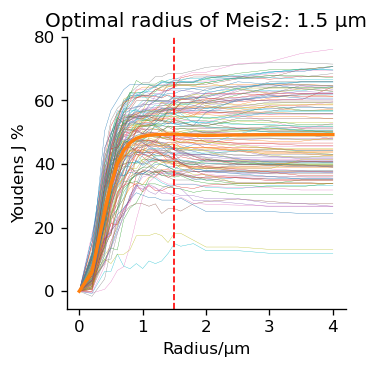

<Figure size 432x288 with 0 Axes>

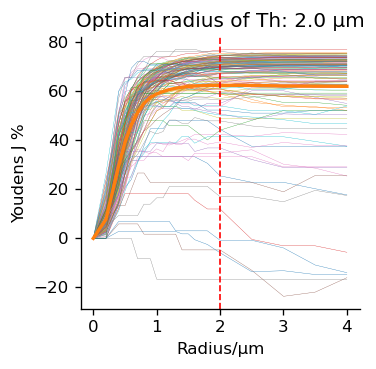

<Figure size 432x288 with 0 Axes>

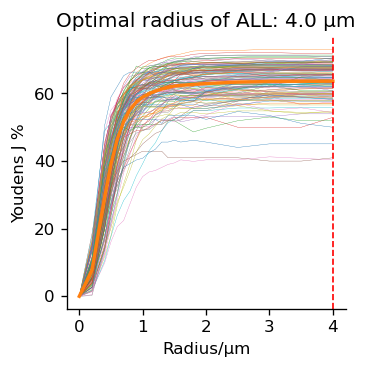

<Figure size 432x288 with 0 Axes>

In [129]:
# Decoding_YoudenJ_plot
Decoding_Efficiency = pd.DataFrame(Decoding_Efficiency, columns = ['Radius','Num_c0','FP_c0%','Efficiency_c0%','FN_c0%',
                                                                  'Num_c1','FP_c1%','Efficiency_c1%','FN_c1%',
                                                                  'Num_ALL','FP_ALL%','Efficiency_ALL%','FN_ALL%'])

fig=plt.figure(dpi=120,figsize=(3,3))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_YoudenJ_c0.T,linewidth=0.2)
plt.plot(Decoding_Efficiency['Radius'].values,np.mean(Decoding_YoudenJ_c0,axis=0),linewidth=2)
Opt_r = Decoding_Efficiency['Radius'].values[np.argmax(np.mean(Decoding_YoudenJ_c0,axis=0))]
plt.axvline(x = Opt_r , color='r', linestyle='--', lw=1,)
sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('Youdens J %')
plt.title('Optimal radius of ' + Gene[0] + ': ' + str(Opt_r) + ' μm')
plt.show()
plt.tight_layout()

fig=plt.figure(dpi=120,figsize=(3,3))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_YoudenJ_c1.T,linewidth=0.2)
plt.plot(Decoding_Efficiency['Radius'].values,np.mean(Decoding_YoudenJ_c1,axis=0),linewidth=2)
Opt_r = Decoding_Efficiency['Radius'].values[np.argmax(np.mean(Decoding_YoudenJ_c1,axis=0))]
plt.axvline(x = Opt_r , color='r', linestyle='--', lw=1,)
sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('Youdens J %')
plt.title('Optimal radius of ' + Gene[1] + ': ' + str(Opt_r) + ' μm')
plt.show()
plt.tight_layout()

fig=plt.figure(dpi=120,figsize=(3,3))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_YoudenJ_ALL.T,linewidth=0.2)
plt.plot(Decoding_Efficiency['Radius'].values,np.mean(Decoding_YoudenJ_ALL,axis=0),linewidth=2)
Opt_r = Decoding_Efficiency['Radius'].values[np.argmax(np.mean(Decoding_YoudenJ_ALL,axis=0))]
plt.axvline(x = Opt_r , color='r', linestyle='--', lw=1,)
sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('Youdens J %')
plt.title('Optimal radius of ALL: ' + str(Opt_r) + ' μm')
plt.show()
plt.tight_layout()

#### Relationship of the changing radius and decoding results

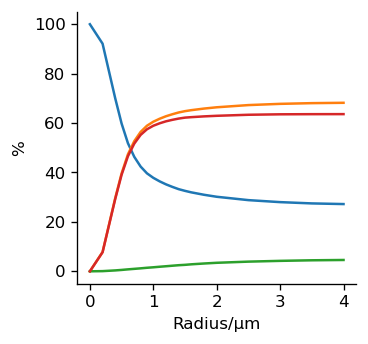

<Figure size 432x288 with 0 Axes>

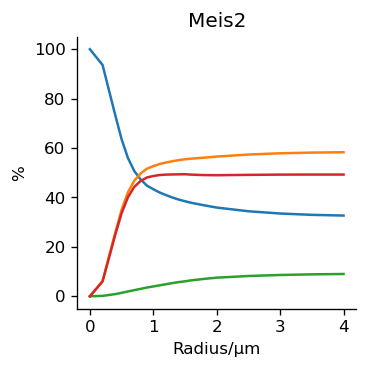

<Figure size 432x288 with 0 Axes>

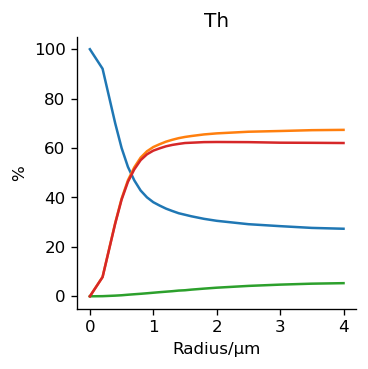

CPU times: total: 312 ms
Wall time: 498 ms


<Figure size 432x288 with 0 Axes>

In [130]:
%%time
Decoding_Efficiency = pd.DataFrame(Decoding_Efficiency, columns = ['Radius','Num_c0','FP_c0%','Efficiency_c0%','FN_c0%',
                                                                  'Num_c1','FP_c1%','Efficiency_c1%','FN_c1%',
                                                                  'Num_ALL','FP_ALL%','Efficiency_ALL%','FN_ALL%'])
Decoding_Efficiency.to_csv(seg_dir + spot_extraction + 'Decoding_Efficiency.csv', index=False)   
fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(cloud_distance(A,B))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_ALL%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_ALL%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_ALL%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,(Decoding_Efficiency['Efficiency_ALL%'].values-Decoding_Efficiency['FP_ALL%'].values))

sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('%')
plt.show()
plt.tight_layout()

fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(cloud_distance(A,B))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_c0%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_c0%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_c0%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,(Decoding_Efficiency['Efficiency_c0%'].values-Decoding_Efficiency['FP_c0%'].values))
sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('%')
# ave=np.average(cloud_distance(A,B))
plt.title(Gene[0])
plt.show()
plt.tight_layout()

fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(cloud_distance(A,B))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_c1%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_c1%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_c1%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,(Decoding_Efficiency['Efficiency_c1%'].values-Decoding_Efficiency['FP_c1%'].values))

sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('%')
# ave=np.average(cloud_distance(A,B))
plt.title(Gene[1])
plt.show()
plt.tight_layout()

### Correlation of the spot numbers with the decoding results

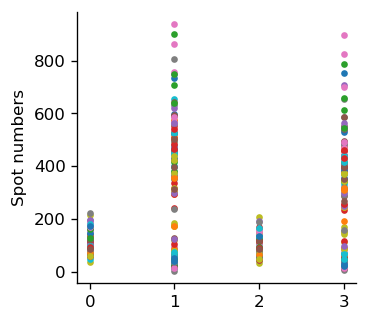

<Figure size 432x288 with 0 Axes>

In [83]:
fig=plt.figure(dpi=120,figsize=(3,3))
x = Count_c3c0
plot=plt.plot(x, '.',label='original values')
# plot=plt.plot(x)
plt.ylabel('Spot numbers')
sns.despine() 
plt.show()
plt.tight_layout()

Estimated coefficients (true, linear regression, RANSAC):


<Figure size 360x360 with 0 Axes>

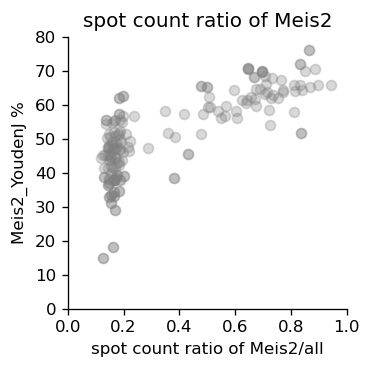

Estimated coefficients (true, linear regression, RANSAC):


<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

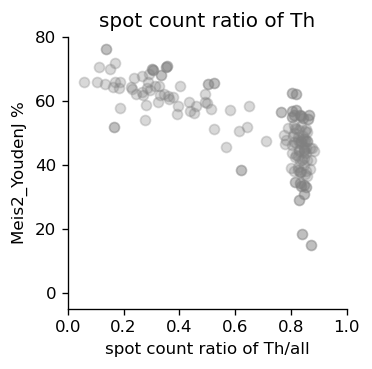

Estimated coefficients (true, linear regression, RANSAC):


<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

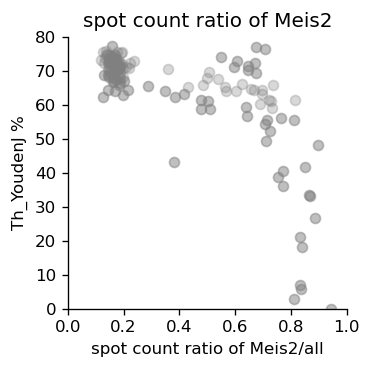

Estimated coefficients (true, linear regression, RANSAC):


<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

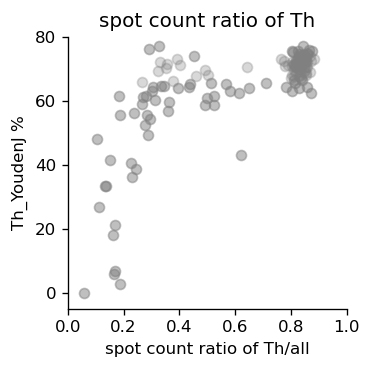

<Figure size 432x288 with 0 Axes>

In [137]:
k = 0
Count_c3c0 = np.zeros((4,len(cell_list))) 
for aa in cell_list:
    fix_c3 = spot_fix_c3_all[spot_fix_c3_all[:,3] == aa][:,:3]
    fix_c0 = spot_fix_c0_all[spot_fix_c0_all[:,3] == aa][:,:3]
    warp_c3 = warp_spots_c3_all[warp_spots_c3_all[:,3]== aa][:,:3]
    warp_c0 = warp_spots_c0_all[warp_spots_c0_all[:,3]== aa][:,:3]
    Count_c3c0[:,k] = [len(fix_c3),len(fix_c0),len(warp_c3),len(warp_c0)]
    k = k +1
    
fig=plt.figure(dpi=120,figsize=(3,3))
# x = (Count_c3c0[0,:] + Count_c3c0[2,:])/(Count_c3c0[1,:] + Count_c3c0[3,:])
x = (Count_c3c0[0,:] + Count_c3c0[2,:])/(Count_c3c0[0,:] + Count_c3c0[2,:] + Count_c3c0[1,:] + Count_c3c0[3,:])
y = np.amax(Decoding_YoudenJ_c0, axis=1)
ransac_linearplot(x,y)
plt.xlabel('spot count ratio of ' + Gene[0] + '/all')
plt.ylabel(Gene[0] + '_YoudenJ %')
plt.title('spot count ratio of ' + Gene[0])
plt.xlim([0,1])
plt.ylim([0,80])
plt.show()
plt.tight_layout()

fig=plt.figure(dpi=120,figsize=(3,3))
x = (Count_c3c0[0,:] + Count_c3c0[2,:])/(Count_c3c0[1,:] + Count_c3c0[3,:])
x = (Count_c3c0[1,:] + Count_c3c0[3,:])/(Count_c3c0[0,:] + Count_c3c0[2,:] + Count_c3c0[1,:] + Count_c3c0[3,:])
y = np.amax(Decoding_YoudenJ_c0, axis=1)
ransac_linearplot(x,y)
plt.xlim([0,1])
plt.ylim([-5,80])
plt.xlabel('spot count ratio of ' + Gene[1] + '/all')
plt.ylabel(Gene[0] + '_YoudenJ %')
plt.title('spot count ratio of ' + Gene[1])
plt.show()
plt.tight_layout()    

fig=plt.figure(dpi=120,figsize=(3,3))
# x = (Count_c3c0[0,:] + Count_c3c0[2,:])/(Count_c3c0[1,:] + Count_c3c0[3,:])
x = (Count_c3c0[0,:] + Count_c3c0[2,:])/(Count_c3c0[0,:] + Count_c3c0[2,:] + Count_c3c0[1,:] + Count_c3c0[3,:])
y = np.amax(Decoding_YoudenJ_c1, axis=1)
ransac_linearplot(x,y)
plt.xlabel('spot count ratio of ' + Gene[0] + '/all')
plt.ylabel(Gene[1] + '_YoudenJ %')
plt.title('spot count ratio of ' + Gene[0])
plt.xlim([0,1])
plt.ylim([0,80])
plt.show()
plt.tight_layout()

fig=plt.figure(dpi=120,figsize=(3,3))
x = (Count_c3c0[0,:] + Count_c3c0[2,:])/(Count_c3c0[1,:] + Count_c3c0[3,:])
x = (Count_c3c0[1,:] + Count_c3c0[3,:])/(Count_c3c0[0,:] + Count_c3c0[2,:] + Count_c3c0[1,:] + Count_c3c0[3,:])
y = np.amax(Decoding_YoudenJ_c1, axis=1)
ransac_linearplot(x,y)
plt.xlim([0,1])
plt.ylim([-5,80])
plt.xlabel('spot count ratio of ' + Gene[1] + '/all')
plt.ylabel(Gene[1] + '_YoudenJ %')
plt.title('spot count ratio of ' + Gene[1])
plt.show()
plt.tight_layout()  

Estimated coefficients (true, linear regression, RANSAC):


<Figure size 360x360 with 0 Axes>

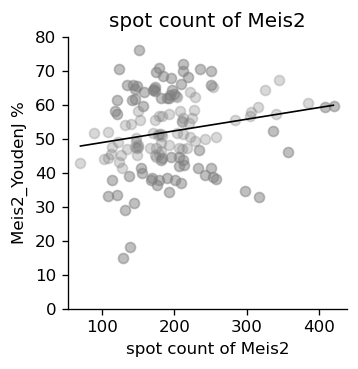

Estimated coefficients (true, linear regression, RANSAC):


<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

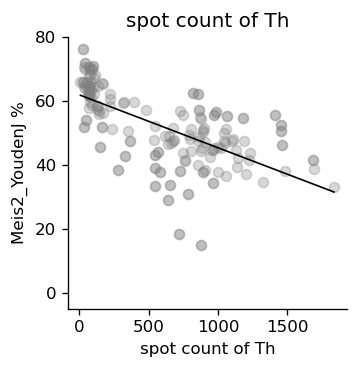

Estimated coefficients (true, linear regression, RANSAC):


<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

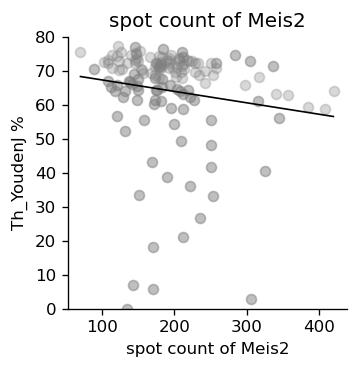

Estimated coefficients (true, linear regression, RANSAC):


<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

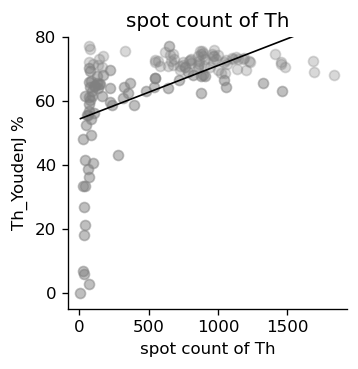

<Figure size 432x288 with 0 Axes>

In [131]:
fig=plt.figure(dpi=120,figsize=(3,3))
# x = (Count_c3c0[0,:] + Count_c3c0[2,:])/(Count_c3c0[1,:] + Count_c3c0[3,:])
x = (Count_c3c0[0,:] + Count_c3c0[2,:])
y = np.amax(Decoding_YoudenJ_c0, axis=1)
ransac_linearplot(x,y)
plt.xlabel('spot count of ' + Gene[0])
plt.ylabel(Gene[0] + '_YoudenJ %')
plt.title('spot count of ' + Gene[0])

# plt.xlim([0,1])
plt.ylim([0,80])
plt.show()
plt.tight_layout()

fig=plt.figure(dpi=120,figsize=(3,3))
x = (Count_c3c0[0,:] + Count_c3c0[2,:])/(Count_c3c0[1,:] + Count_c3c0[3,:])
x = (Count_c3c0[1,:] + Count_c3c0[3,:])
y = np.amax(Decoding_YoudenJ_c0, axis=1)
ransac_linearplot(x,y)
# plt.xlim([0,1])
plt.ylim([-5,80])
plt.xlabel('spot count of ' + Gene[1])
plt.ylabel(Gene[0] + '_YoudenJ %')
plt.title('spot count of ' + Gene[1])
plt.show()
plt.tight_layout()


fig=plt.figure(dpi=120,figsize=(3,3))
# x = (Count_c3c0[0,:] + Count_c3c0[2,:])/(Count_c3c0[1,:] + Count_c3c0[3,:])
x = (Count_c3c0[0,:] + Count_c3c0[2,:])
y = np.amax(Decoding_YoudenJ_c1, axis=1)
ransac_linearplot(x,y)
plt.xlabel('spot count of ' + Gene[0])
plt.ylabel(Gene[1] + '_YoudenJ %')
plt.title('spot count of ' + Gene[0])

# plt.xlim([0,1])
plt.ylim([0,80])
plt.show()
plt.tight_layout()

fig=plt.figure(dpi=120,figsize=(3,3))
x = (Count_c3c0[0,:] + Count_c3c0[2,:])/(Count_c3c0[1,:] + Count_c3c0[3,:])
x = (Count_c3c0[1,:] + Count_c3c0[3,:])
y = np.amax(Decoding_YoudenJ_c1, axis=1)
ransac_linearplot(x,y)
# plt.xlim([0,1])
plt.ylim([-5,80])
plt.xlabel('spot count of ' + Gene[1])
plt.ylabel(Gene[1] + '_YoudenJ %')
plt.title('spot count of ' + Gene[1])
plt.show()
plt.tight_layout()

#### Decoding results for vglut1 green and red channels

In [115]:
%%time
seg_dir='E:/Maxprobe_analysis/LHA_R2_R10/'
fix_spacing=np.array([0.42,0.23,0.23])
spot_extraction = ['hAir/','RS-FISH/'][1] # image_seperate_fish
Rounds = ['R2','R10']
chn = ['c0','c1']

vglut1_list = [1,4,6,7,10,17,18,19,28,29,31,34,35,38,39,42,43,44,49,50]
 
spot_fix_c3_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[0] + '_spots.txt',delimiter=',')
spot_fix_c0_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[0] + '_' + chn[1] + '_spots.txt',delimiter=',')
warp_spots_c3_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[1] + '_' + chn[0] + '_spots.txt',delimiter=',')
warp_spots_c0_all = np.loadtxt (seg_dir + spot_extraction + 'ROIaffine_'+ Rounds[1] + '_' + chn[1] + '_spots.txt',delimiter=',')
# Dist_sum_1 = np.zeros((len(cell_list), 14)) # directory to file containing the registration stats
Decoding_results = np.zeros((len(vglut1_list), 14))
# radius = 1 # in 4 px / 1 um
# radius_list = [0,0.25,0.5,0.75,1,1.5,2,2.5,3,3.5,4]
radius_list = [0,0.2,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.8,2,2.5,3,3.5,4]
Decoding_Efficiency = np.zeros((len(radius_list), 13))
Decoding_YoudenJ_c3 = np.zeros((len(vglut1_list), len(radius_list)))
Decoding_YoudenJ_c0 = np.zeros((len(vglut1_list), len(radius_list)))
Decoding_YoudenJ_ALL = np.zeros((len(vglut1_list), len(radius_list)))  

k = 0
for radius in radius_list:
# radius = 1
################# 1.2 True positive when separated
    j = 0
#     aa = 5
    for aa in vglut1_list:
#     if aa == 5:
        print('ROI: #' + str(aa))
        fix_c3 = spot_fix_c3_all[spot_fix_c3_all[:,3] == aa][:,:3]*fix_spacing
        fix_c0 = spot_fix_c0_all[spot_fix_c0_all[:,3] == aa][:,:3]*fix_spacing
        warp_c3 = warp_spots_c3_all[warp_spots_c3_all[:,3]== aa][:,:3]*fix_spacing
        warp_c0 = warp_spots_c0_all[warp_spots_c0_all[:,3]== aa][:,:3]*fix_spacing
        # fix_c3 = fix_spots_3
        # fix_c0 = fix_spots_0
        # warp_c3 = warp_spots_new_3
        # warp_c0 = warp_spots_new_0
        all_n = len(fix_c3) + len(fix_c0) + len(warp_c3)+ len(warp_c0)
        print("Total c3 spots: " + str(len(fix_c3) + len(warp_c3)))
        print("Total c0 spots: " + str(len(fix_c0) + len(warp_c0)))
        Num_c3 = len(fix_c3) + len(warp_c3)
        Num_c0 = len(fix_c0) + len(warp_c0)
        Num_All = all_n
        
        #         ################# 1.0 False positive inside the round after registration
# #         # R2 
#         lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(fix_c0,fix_c3,radius)
#         e3 = len(lipo_c0)*2
# #         print("False positive_R2: % " + str(100*(e3)/(len(fix_c0) + len(fix_c3))))
# #         # R1  
#         lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(warp_c0,warp_c3,radius)
#         e4 = len(lipo_c0)*2
# #         print("False positive_R1: % " + str(100*(e4)/(len(warp_c0) + len(warp_c3))))
#         print("% Decoding error for crowding inside each run: " + str(100*(e3+e4)/all_n))

        ################# 1.1 False positive when separated
        # R2 GAD1 align with R1 lamp5    
        lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(fix_c3,warp_c0,radius)
        e1 = len(lipo_c0)
        #  R1 GAD1 align with R2 lamp5   
        lipo_c0,lipo_c1,_,_,_,p1,p2, = colocalization(warp_c3,fix_c0,radius)
        e2 = len(lipo_c0)
        
        FP_c3 = 100*(e1)/(2*len(fix_c3)) + 100*(e2)/(2*len(warp_c3))  
        print("% FP of c3: " + str(FP_c3))
        FP_c0 = 100*(e1)/(2*len(warp_c0)) + 100*(e2)/(2*len(fix_c0))
        print("% FP of c0: " + str(FP_c0))
        
        FP_All = 100*2*(e1+e2)/all_n
        print("% False positive for two rounds: " + str(FP_All))
        
        ################# 1.2 True positive when separated
        # R1 c3 align with R2 c3
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(fix_c3,warp_c3,radius)
        aaa = len(lipo_c0)*2
#         ave1 = violin_distance(lipo_c0,lipo_c1)
        TP_c3 = 100*(aaa)/(len(fix_c3) + len(warp_c3))
        print("% True positive of c3: " + str(TP_c3))    
        # R1 c0 align with R2 c0
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(fix_c0,warp_c0,radius)
        bbb = len(lipo_c0)*2
#         ave2 =violin_distance(lipo_c0,lipo_c1)
        TP_c0 = 100*(bbb)/(len(fix_c0) + len(warp_c0))
        print("% True positive of c0: " + str(TP_c0))
    
        ################# 1.2 True positive when grouping
        # R1 GAD1 + lamp5 align with R2 GAD1 + lamp5
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(np.vstack([fix_c3, fix_c0]),np.vstack([warp_c3,warp_c0]),radius)
        drop = len(true_pos_c0) + len(true_pos_c1)
        TP_All = 100*(len(lipo_c0) + len(lipo_c1))/all_n
        print("% Decoding efficiency for two rounds: " + str(TP_All))
#         ave0 = violin_distance(lipo_c0,lipo_c1)

        ################# 1.3 Dropout when separated
        # R2 c3 NOT aligned to R1  and R1 c3 NOT aligned to R2        
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(fix_c3,np.vstack([warp_c3,warp_c0]),radius)
        e1 = len(true_pos_c0)
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(warp_c3,np.vstack([fix_c3,fix_c0]),radius)
        e2 = len(true_pos_c0)
        FN_c3 = 100*(e1+e2)/(len(fix_c3) + len(warp_c3))
        print("% Dropout of c3: " + str(FN_c3))   
              
        # R2 c3 NOT aligned to R1  and R1 c3 NOT aligned to R2       
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(fix_c0,np.vstack([warp_c3,warp_c0]),radius)
        e3 = len(true_pos_c0)      
        lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization(warp_c0,np.vstack([fix_c3,fix_c0]),radius)
        e4 = len(true_pos_c0)
        FN_c0 = 100*(e3+e4)/(len(fix_c0) + len(warp_c0))
        print("% Dropout of c0: " + str(FN_c0)) 
        FN_All = 100*(e1+e2+e3+e4)/all_n
        print("% Dropout for two rounds: " + str(FN_All))               
              
    #         print(all_n)
    #         print(e1+e2+e3+e4+aa+bb)

        Decoding_results[j,:] = [radius,aa,Num_c3,Num_c0,Num_All,FP_c3,FP_c0,FP_All,TP_c3,TP_c0,TP_All,FN_c3,FN_c0,FN_All] #ave1,ave2
        j = j + 1
        
#     Decoding_results = pd.DataFrame(Decoding_results, columns = ['Radius','ROI','Num_c3','Num_c0','Num_All','FP_c3',
#                                                                  'FP_c0','FP_All','TP_c3','TP_c0','TP_All',
#                                                                     'FN_c3','FN_c0','FN_All','Dist_c3','Dist_c0'])  

#     Decoding_results.to_csv(seg_dir + spot_extraction + 'Decoding_results.csv', index=False)

    Decoding_Efficiency[k,:] = [radius,np.mean(Decoding_results[:,2]),np.mean(Decoding_results[:,5]),
                                np.mean(Decoding_results[:,8]),np.mean(Decoding_results[:,11]),
                               np.mean(Decoding_results[:,3]),np.mean(Decoding_results[:,6]),
                                np.mean(Decoding_results[:,9]),np.mean(Decoding_results[:,12]),
                                np.mean(Decoding_results[:,4]),np.mean(Decoding_results[:,7]),
                                np.mean(Decoding_results[:,10]),np.mean(Decoding_results[:,13]),] 
    
    Decoding_YoudenJ_c0[:,k] = Decoding_results[:,8] - Decoding_results[:,5]
    Decoding_YoudenJ_c3[:,k] = Decoding_results[:,9] - Decoding_results[:,6]
    Decoding_YoudenJ_ALL[:,k] = Decoding_results[:,10] - Decoding_results[:,7]
    k = k + 1  
    
# Decoding_Efficiency = pd.DataFrame(Decoding_Efficiency, columns = ['Radius','Num','FP%','Efficiency%','FN%'])
# Decoding_Efficiency.to_csv(seg_dir + spot_extraction + 'Decoding_Efficiency.csv', index=False)    

ROI: #1
Total c3 spots: 1926
Total c0 spots: 1574
% FP of c3: 0.0
% FP of c0: 0.0
% False positive for two rounds: 0.0
% True positive of c3: 0.0
% True positive of c0: 0.0
% Decoding efficiency for two rounds: 0.0


C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\zhenggang\Anaconda3\envs\easifish\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% Dropout of c3: 100.0
% Dropout of c0: 100.0
% Dropout for two rounds: 100.0
ROI: #4
Total c3 spots: 906
Total c0 spots: 1308
% FP of c3: 0.0
% FP of c0: 0.0
% False positive for two rounds: 0.0
% True positive of c3: 0.0
% True positive of c0: 0.0
% Decoding efficiency for two rounds: 0.0
% Dropout of c3: 100.0
% Dropout of c0: 100.0
% Dropout for two rounds: 100.0
ROI: #6
Total c3 spots: 1077
Total c0 spots: 1130
% FP of c3: 0.0
% FP of c0: 0.0
% False positive for two rounds: 0.0
% True positive of c3: 0.0
% True positive of c0: 0.0
% Decoding efficiency for two rounds: 0.0
% Dropout of c3: 100.0
% Dropout of c0: 100.0
% Dropout for two rounds: 100.0
ROI: #7
Total c3 spots: 1053
Total c0 spots: 1114
% FP of c3: 0.0
% FP of c0: 0.0
% False positive for two rounds: 0.0
% True positive of c3: 0.0
% True positive of c0: 0.0
% Decoding efficiency for two rounds: 0.0
% Dropout of c3: 100.0
% Dropout of c0: 100.0
% Dropout for two rounds: 100.0
ROI: #10
Total c3 spots: 1052
Total c0 spots

% True positive of c0: 7.835051546391752
% Decoding efficiency for two rounds: 11.366006256517206
% Dropout of c3: 87.34177215189874
% Dropout of c0: 88.55670103092784
% Dropout for two rounds: 87.95620437956204
ROI: #19
Total c3 spots: 776
Total c0 spots: 790
% FP of c3: 4.130781499202552
% FP of c0: 4.113053997580557
% False positive for two rounds: 4.086845466155811
% True positive of c3: 7.474226804123711
% True positive of c0: 5.569620253164557
% Decoding efficiency for two rounds: 8.42911877394636
% Dropout of c3: 89.43298969072166
% Dropout of c0: 91.77215189873418
% Dropout for two rounds: 90.61302681992338
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 5.238095238095238
% FP of c0: 4.196755625327054
% False positive for two rounds: 4.645574689627553
% True positive of c3: 8.88888888888889
% True positive of c0: 4.810495626822157
% Decoding efficiency for two rounds: 9.050861033239888
% Dropout of c3: 87.82222222222222
% Dropout of c0: 91.76384839650146
% Dropou

% Dropout of c3: 62.447257383966246
% Dropout of c0: 66.3917525773196
% Dropout for two rounds: 64.44212721584984
ROI: #19
Total c3 spots: 776
Total c0 spots: 790
% FP of c3: 16.64407230196704
% FP of c0: 16.543106850130354
% False positive for two rounds: 16.47509578544061
% True positive of c3: 25.257731958762886
% True positive of c0: 22.025316455696203
% Decoding efficiency for two rounds: 24.521072796934867
% Dropout of c3: 68.4278350515464
% Dropout of c0: 70.63291139240506
% Dropout for two rounds: 69.54022988505747
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 22.833333333333332
% FP of c0: 18.623757195185767
% False positive for two rounds: 20.424509411293553
% True positive of c3: 27.377777777777776
% True positive of c0: 26.239067055393587
% Decoding efficiency for two rounds: 28.354024829795755
% Dropout of c3: 64.71111111111111
% Dropout of c0: 65.3061224489796
% Dropout for two rounds: 65.03804565478575
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% 

% Dropout of c3: 53.586497890295355
% Dropout of c0: 58.65979381443299
% Dropout for two rounds: 56.152241918665275
ROI: #19
Total c3 spots: 776
Total c0 spots: 790
% FP of c3: 22.821637426900587
% FP of c0: 22.62664881194972
% False positive for two rounds: 22.60536398467433
% True positive of c3: 29.63917525773196
% True positive of c0: 29.873417721518987
% Decoding efficiency for two rounds: 29.757343550446997
% Dropout of c3: 62.371134020618555
% Dropout of c0: 61.89873417721519
% Dropout for two rounds: 62.132822477650066
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 29.833333333333336
% FP of c0: 24.45839874411303
% False positive for two rounds: 26.752102523027634
% True positive of c3: 34.13333333333333
% True positive of c0: 35.714285714285715
% Decoding efficiency for two rounds: 33.720464557468965
% Dropout of c3: 58.044444444444444
% Dropout of c0: 56.70553935860058
% Dropout for two rounds: 57.30877052462956
ROI: #29
Total c3 spots: 858
Total c0 spots: 123

% True positive of c0: 35.05154639175258
% Decoding efficiency for two rounds: 38.06047966631908
% Dropout of c3: 47.9957805907173
% Dropout of c0: 52.47422680412371
% Dropout for two rounds: 50.260688216892596
ROI: #19
Total c3 spots: 776
Total c0 spots: 790
% FP of c3: 26.58426368952685
% FP of c0: 26.44244764880548
% False positive for two rounds: 26.309067688378033
% True positive of c3: 32.7319587628866
% True positive of c0: 35.949367088607595
% Decoding efficiency for two rounds: 32.95019157088122
% Dropout of c3: 58.50515463917526
% Dropout of c0: 55.949367088607595
% Dropout for two rounds: 57.215836526181356
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 35.75
% FP of c0: 29.424385138670857
% False positive for two rounds: 32.11854225070084
% True positive of c3: 40.17777777777778
% True positive of c0: 41.690962099125365
% Decoding efficiency for two rounds: 37.965558670404484
% Dropout of c3: 52.53333333333333
% Dropout of c0: 50.80174927113703
% Dropout for

% True positive of c0: 38.96907216494845
% Decoding efficiency for two rounds: 40.980187695516165
% Dropout of c3: 43.67088607594937
% Dropout of c0: 47.628865979381445
% Dropout for two rounds: 45.6725755995829
ROI: #19
Total c3 spots: 776
Total c0 spots: 790
% FP of c3: 29.92025518341308
% FP of c0: 29.69058293063184
% False positive for two rounds: 29.62962962962963
% True positive of c3: 37.88659793814433
% True positive of c0: 40.0
% Decoding efficiency for two rounds: 34.48275862068966
% Dropout of c3: 54.7680412371134
% Dropout of c0: 53.29113924050633
% Dropout for two rounds: 54.02298850574713
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 40.45238095238095
% FP of c0: 33.333333333333336
% False positive for two rounds: 36.36363636363637
% True positive of c3: 44.44444444444444
% True positive of c0: 47.37609329446064
% Decoding efficiency for two rounds: 40.608730476571886
% Dropout of c3: 48.977777777777774
% Dropout of c0: 46.20991253644315
% Dropout for two

% Dropout of c0: 44.02061855670103
% Dropout for two rounds: 42.12721584984359
ROI: #19
Total c3 spots: 776
Total c0 spots: 790
% FP of c3: 32.740563530037214
% FP of c0: 32.427659285423175
% False positive for two rounds: 32.43933588761175
% True positive of c3: 40.4639175257732
% True positive of c0: 41.0126582278481
% Decoding efficiency for two rounds: 35.50446998722861
% Dropout of c3: 52.44845360824742
% Dropout of c0: 51.392405063291136
% Dropout for two rounds: 51.91570881226053
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 43.41666666666667
% FP of c0: 35.88697017268446
% False positive for two rounds: 39.08690428514217
% True positive of c3: 47.46666666666667
% True positive of c0: 50.583090379008745
% Decoding efficiency for two rounds: 42.050460552663196
% Dropout of c3: 46.13333333333333
% Dropout of c0: 44.24198250728863
% Dropout for two rounds: 45.094112935522624
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 43.35664335664336
% FP of c0:

% Decoding efficiency for two rounds: 43.7956204379562
% Dropout of c3: 38.81856540084388
% Dropout of c0: 40.51546391752577
% Dropout for two rounds: 39.67674661105318
ROI: #19
Total c3 spots: 776
Total c0 spots: 790
% FP of c3: 36.06592238171186
% FP of c0: 35.626629404648696
% False positive for two rounds: 35.759897828863345
% True positive of c3: 42.52577319587629
% True positive of c0: 42.53164556962025
% Decoding efficiency for two rounds: 36.65389527458493
% Dropout of c3: 50.0
% Dropout of c0: 49.36708860759494
% Dropout for two rounds: 49.68071519795658
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 46.023809523809526
% FP of c0: 38.14756671899529
% False positive for two rounds: 41.48978774529435
% True positive of c3: 50.84444444444444
% True positive of c0: 51.74927113702624
% Decoding efficiency for two rounds: 43.49219062875451
% Dropout of c3: 43.733333333333334
% Dropout of c0: 42.201166180758015
% Dropout for two rounds: 42.89146976371646
ROI: #29
Tota

% Decoding efficiency for two rounds: 44.42127215849844
% Dropout of c3: 37.0253164556962
% Dropout of c0: 39.27835051546392
% Dropout for two rounds: 38.16475495307612
ROI: #19
Total c3 spots: 776
Total c0 spots: 790
% FP of c3: 38.8755980861244
% FP of c0: 38.314540596839194
% False positive for two rounds: 38.569604086845466
% True positive of c3: 44.07216494845361
% True positive of c0: 43.54430379746835
% Decoding efficiency for two rounds: 37.93103448275862
% Dropout of c3: 48.45360824742268
% Dropout of c0: 46.32911392405063
% Dropout for two rounds: 47.381864623243935
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 48.26190476190476
% FP of c0: 39.9738356881214
% False positive for two rounds: 43.49219062875451
% True positive of c3: 51.91111111111111
% True positive of c0: 53.79008746355685
% Decoding efficiency for two rounds: 44.45334401281538
% Dropout of c3: 42.22222222222222
% Dropout of c0: 40.01457725947522
% Dropout for two rounds: 41.00921105326392
ROI:

% Decoding efficiency for two rounds: 45.56830031282586
% Dropout of c3: 35.232067510548525
% Dropout of c0: 37.422680412371136
% Dropout for two rounds: 36.339937434827945
ROI: #19
Total c3 spots: 776
Total c0 spots: 790
% FP of c3: 41.32243487506645
% FP of c0: 40.729779209605326
% False positive for two rounds: 40.99616858237548
% True positive of c3: 45.36082474226804
% True positive of c0: 44.81012658227848
% Decoding efficiency for two rounds: 38.31417624521073
% Dropout of c3: 46.77835051546392
% Dropout of c0: 44.68354430379747
% Dropout for two rounds: 45.721583652618136
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 49.964285714285715
% FP of c0: 41.36054421768708
% False positive for two rounds: 45.014016820184224
% True positive of c3: 53.333333333333336
% True positive of c0: 55.393586005830905
% Decoding efficiency for two rounds: 45.89507408890669
% Dropout of c3: 40.53333333333333
% Dropout of c0: 38.0466472303207
% Dropout for two rounds: 39.16700040048

% Dropout of c0: 35.05154639175258
% Dropout for two rounds: 34.41084462982273
ROI: #19
Total c3 spots: 776
Total c0 spots: 790
% FP of c3: 43.495481127060074
% FP of c0: 42.81574061495268
% False positive for two rounds: 43.16730523627076
% True positive of c3: 47.422680412371136
% True positive of c0: 45.56962025316456
% Decoding efficiency for two rounds: 39.46360153256705
% Dropout of c3: 44.845360824742265
% Dropout of c0: 42.91139240506329
% Dropout for two rounds: 43.86973180076628
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 51.58333333333333
% FP of c0: 42.66875981161695
% False positive for two rounds: 46.45574689627553
% True positive of c3: 54.22222222222222
% True positive of c0: 56.41399416909621
% Decoding efficiency for two rounds: 46.61593912695234
% Dropout of c3: 39.2
% Dropout of c0: 36.44314868804665
% Dropout for two rounds: 37.68522226672006
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 52.214452214452216
% FP of c0: 36.519594894

Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 52.964285714285715
% FP of c0: 43.73103087388802
% False positive for two rounds: 47.65718862635162
% True positive of c3: 54.93333333333333
% True positive of c0: 57.5801749271137
% Decoding efficiency for two rounds: 47.49699639567481
% Dropout of c3: 37.51111111111111
% Dropout of c0: 35.204081632653065
% Dropout for two rounds: 36.24349219062876
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 53.72960372960373
% FP of c0: 37.56551002726062
% False positive for two rounds: 44.13595021541408
% True positive of c3: 55.01165501165501
% True positive of c0: 54.42729488220959
% Decoding efficiency for two rounds: 47.00813786500718
% Dropout of c3: 36.36363636363637
% Dropout of c0: 38.18034118602762
% Dropout for two rounds: 37.434179033030155
ROI: #31
Total c3 spots: 897
Total c0 spots: 1054
% FP of c3: 50.080704621086824
% FP of c0: 42.188311688311686
% False positive for two rounds: 45.72014351614557
% True positive o

% Dropout of c3: 41.108247422680414
% Dropout of c0: 40.0
% Dropout for two rounds: 40.549169859514684
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 54.85714285714286
% FP of c0: 45.2537938252224
% False positive for two rounds: 49.33920704845815
% True positive of c3: 55.82222222222222
% True positive of c0: 59.03790087463557
% Decoding efficiency for two rounds: 48.778534241089304
% Dropout of c3: 35.46666666666667
% Dropout of c0: 33.16326530612245
% Dropout for two rounds: 34.2010412494994
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 55.5944055944056
% FP of c0: 38.87055958242641
% False positive for two rounds: 45.667783628530394
% True positive of c3: 56.41025641025641
% True positive of c0: 55.239642567018684
% Decoding efficiency for two rounds: 48.15701292484442
% Dropout of c3: 34.38228438228438
% Dropout of c0: 36.79935012185215
% Dropout for two rounds: 35.806606031594065
ROI: #31
Total c3 spots: 897
Total c0 spots: 1054
% FP of c3: 51.6243

% True positive of c0: 48.607594936708864
% Decoding efficiency for two rounds: 41.123882503192846
% Dropout of c3: 39.81958762886598
% Dropout of c0: 37.9746835443038
% Dropout for two rounds: 38.888888888888886
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 55.92857142857143
% FP of c0: 46.13291470434328
% False positive for two rounds: 50.30036043251902
% True positive of c3: 56.888888888888886
% True positive of c0: 60.204081632653065
% Decoding efficiency for two rounds: 49.81978374048859
% Dropout of c3: 34.044444444444444
% Dropout of c0: 31.778425655976676
% Dropout for two rounds: 32.79935923107729
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 56.526806526806524
% FP of c0: 39.50782950487098
% False positive for two rounds: 46.43370033508856
% True positive of c3: 57.10955710955711
% True positive of c0: 56.05199025182778
% Decoding efficiency for two rounds: 48.92292963140258
% Dropout of c3: 32.98368298368298
% Dropout of c0: 35.49959382615759

% True positive of c0: 50.88607594936709
% Decoding efficiency for two rounds: 42.1455938697318
% Dropout of c3: 38.01546391752577
% Dropout of c0: 36.075949367088604
% Dropout for two rounds: 37.03703703703704
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 57.45238095238095
% FP of c0: 47.3731030873888
% False positive for two rounds: 51.661994393271925
% True positive of c3: 57.422222222222224
% True positive of c0: 60.78717201166181
% Decoding efficiency for two rounds: 50.14016820184221
% Dropout of c3: 32.62222222222222
% Dropout of c0: 31.122448979591837
% Dropout for two rounds: 31.798157789347215
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 58.39160839160839
% FP of c0: 40.79980346991822
% False positive for two rounds: 47.965533748204884
% True positive of c3: 57.57575757575758
% True positive of c0: 57.51421608448416
% Decoding efficiency for two rounds: 49.68884633796075
% Dropout of c3: 31.585081585081586
% Dropout of c0: 33.79366368805849
%

% Dropout of c3: 35.30927835051546
% Dropout of c0: 34.177215189873415
% Dropout for two rounds: 34.73818646232439
ROI: #28
Total c3 spots: 1125
Total c0 spots: 1372
% FP of c3: 59.67857142857143
% FP of c0: 49.20983778126635
% False positive for two rounds: 53.66439727673208
% True positive of c3: 58.48888888888889
% True positive of c0: 62.39067055393586
% Decoding efficiency for two rounds: 51.421706047256706
% Dropout of c3: 29.77777777777778
% Dropout of c0: 28.717201166180757
% Dropout for two rounds: 29.19503404084902
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 61.3053613053613
% FP of c0: 42.83431246169776
% False positive for two rounds: 50.35902345619914
% True positive of c3: 58.74125874125874
% True positive of c0: 60.27619821283509
% Decoding efficiency for two rounds: 51.22067975107707
% Dropout of c3: 28.554778554778554
% Dropout of c0: 31.194151096669376
% Dropout for two rounds: 30.110100526567734
ROI: #31
Total c3 spots: 897
Total c0 spots: 1054
% FP

% FP of c3: 61.19047619047619
% FP of c0: 50.46049188906332
% False positive for two rounds: 55.02603123748498
% True positive of c3: 59.022222222222226
% True positive of c0: 62.97376093294461
% Decoding efficiency for two rounds: 52.382859431317584
% Dropout of c3: 28.0
% Dropout of c0: 26.96793002915452
% Dropout for two rounds: 27.432919503404086
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 63.752913752913756
% FP of c0: 44.53493163711671
% False positive for two rounds: 52.369554810914316
% True positive of c3: 60.13986013986014
% True positive of c0: 62.06336311941511
% Decoding efficiency for two rounds: 52.65677357587362
% Dropout of c3: 25.524475524475523
% Dropout of c0: 28.75710804224208
% Dropout for two rounds: 27.42939205361417
ROI: #31
Total c3 spots: 897
Total c0 spots: 1054
% FP of c3: 58.00744275950023
% FP of c0: 48.94155844155844
% False positive for two rounds: 52.99846232701179
% True positive of c3: 58.63991081382386
% True positive of c0: 56.736

% True positive of c3: 60.977777777777774
% True positive of c0: 65.59766763848397
% Decoding efficiency for two rounds: 54.785742891469766
% Dropout of c3: 23.822222222222223
% Dropout of c0: 23.396501457725947
% Dropout for two rounds: 23.588305967160593
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 69.23076923076923
% FP of c0: 48.37096637856343
% False positive for two rounds: 56.869315461943515
% True positive of c3: 62.93706293706294
% True positive of c0: 64.98781478472786
% Decoding efficiency for two rounds: 55.14600287218765
% Dropout of c3: 20.396270396270396
% Dropout of c0: 24.45166531275386
% Dropout for two rounds: 22.786022020105314
ROI: #31
Total c3 spots: 897
Total c0 spots: 1054
% FP of c3: 61.2523165215312
% FP of c0: 51.694083694083695
% False positive for two rounds: 55.971296770886724
% True positive of c3: 60.423634336677814
% True positive of c0: 57.685009487666036
% Decoding efficiency for two rounds: 48.6929779600205
% Dropout of c3: 26.198439

% Dropout of c3: 20.88888888888889
% Dropout of c0: 21.355685131195337
% Dropout for two rounds: 21.145374449339208
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 72.37762237762237
% FP of c0: 50.53755203820714
% False positive for two rounds: 59.45428434657731
% True positive of c3: 65.03496503496504
% True positive of c0: 66.77497969130788
% Decoding efficiency for two rounds: 56.39061752034466
% Dropout of c3: 17.715617715617714
% Dropout of c0: 22.258326563769295
% Dropout for two rounds: 20.392532312111058
ROI: #31
Total c3 spots: 897
Total c0 spots: 1054
% FP of c3: 63.476426279815875
% FP of c0: 53.60353535353535
% False positive for two rounds: 58.02152742183495
% True positive of c3: 61.53846153846154
% True positive of c0: 59.77229601518027
% Decoding efficiency for two rounds: 50.4356740133265
% Dropout of c3: 24.08026755852843
% Dropout of c0: 27.32447817836812
% Dropout for two rounds: 25.83290620194772
ROI: #34
Total c3 spots: 1065
Total c0 spots: 1158
% FP

% Dropout of c0: 20.699708454810494
% Dropout for two rounds: 20.26431718061674
ROI: #29
Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 73.42657342657343
% FP of c0: 51.26265294478139
% False positive for two rounds: 60.31594064145524
% True positive of c3: 65.96736596736596
% True positive of c0: 67.42485783915515
% Decoding efficiency for two rounds: 57.060794638583054
% Dropout of c3: 16.666666666666668
% Dropout of c0: 20.877335499593826
% Dropout for two rounds: 19.147917663954043
ROI: #31
Total c3 spots: 897
Total c0 spots: 1054
% FP of c3: 64.71040989976686
% FP of c0: 54.64502164502164
% False positive for two rounds: 59.14915427985648
% True positive of c3: 62.43032329988852
% True positive of c0: 60.72106261859582
% Decoding efficiency for two rounds: 51.358277806253206
% Dropout of c3: 22.74247491638796
% Dropout of c0: 26.091081593927893
% Dropout for two rounds: 24.551512045105074
ROI: #34
Total c3 spots: 1065
Total c0 spots: 1158
% FP of c3: 69.11907937919499
% FP o

Total c3 spots: 858
Total c0 spots: 1231
% FP of c3: 74.24242424242425
% FP of c0: 51.82080894317534
% False positive for two rounds: 60.986117759693634
% True positive of c3: 66.43356643356644
% True positive of c0: 67.58732737611697
% Decoding efficiency for two rounds: 57.34801340354237
% Dropout of c3: 15.85081585081585
% Dropout of c0: 20.471161657189278
% Dropout for two rounds: 18.573480134035425
ROI: #31
Total c3 spots: 897
Total c0 spots: 1054
% FP of c3: 65.25367156208277
% FP of c0: 55.132756132756136
% False positive for two rounds: 59.66171194259354
% True positive of c3: 62.876254180602004
% True positive of c0: 61.10056925996205
% Decoding efficiency for two rounds: 51.56330087134803
% Dropout of c3: 22.40802675585284
% Dropout of c0: 25.426944971537
% Dropout for two rounds: 24.038954382368015
ROI: #34
Total c3 spots: 1065
Total c0 spots: 1158
% FP of c3: 69.87073620021597
% FP of c0: 64.36726685202828
% False positive for two rounds: 66.9365721997301
% True positive of

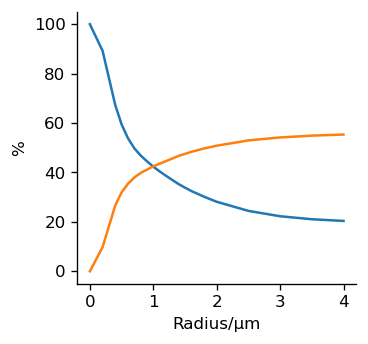

<Figure size 432x288 with 0 Axes>

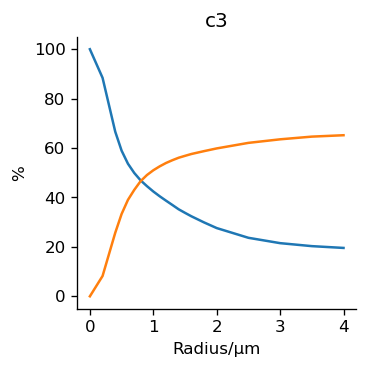

<Figure size 432x288 with 0 Axes>

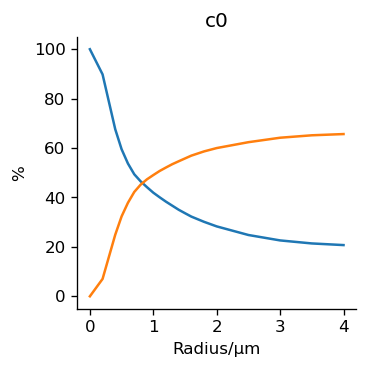

<Figure size 432x288 with 0 Axes>

In [117]:
Decoding_Efficiency = pd.DataFrame(Decoding_Efficiency, columns = ['Radius','Num_c3','FP_c3%','Efficiency_c3%','FN_c3%',
                                                                  'Num_c0','FP_c0%','Efficiency_c0%','FN_c0%',
                                                                  'Num_ALL','FP_ALL%','Efficiency_ALL%','FN_ALL%'])
Decoding_Efficiency.to_csv(seg_dir + spot_extraction + 'Decoding_Efficiency.csv', index=False)   
fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(cloud_distance(A,B))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_ALL%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_ALL%'].values)
# plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_ALL%'].values)
# plt.plot(Decoding_Efficiency['Radius'].values,(Decoding_Efficiency['Efficiency_ALL%'].values-Decoding_Efficiency['FP_ALL%'].values))

sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('%')
# ave=np.average(cloud_distance(A,B))
# plt.title('ALL')
plt.show()
plt.tight_layout()

fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(cloud_distance(A,B))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_c3%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_c3%'].values)
# plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_c3%'].values)
# plt.plot(Decoding_Efficiency['Radius'].values,(Decoding_Efficiency['Efficiency_c3%'].values-Decoding_Efficiency['FP_c3%'].values))
sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('%')
# ave=np.average(cloud_distance(A,B))
plt.title('c3')
plt.show()
plt.tight_layout()


fig=plt.figure(dpi=120,figsize=(3,3))
# plt.violinplot(cloud_distance(A,B))
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_c0%'].values)
plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_c0%'].values)
# plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_c0%'].values)
# plt.plot(Decoding_Efficiency['Radius'].values,(Decoding_Efficiency['Efficiency_c0%'].values-Decoding_Efficiency['FP_c0%'].values))

sns.despine() 
plt.xlabel('Radius/μm')
plt.ylabel('%')
# ave=np.average(cloud_distance(A,B))
plt.title('c0')
plt.show()
plt.tight_layout()

#### Export grouping registration results

In [89]:
# Dist_sum_pre = pd.DataFrame(Dist_sum_1, columns = ['roi_fix','roi_mov','C0_dist','C1_dist','C2_dist','C3_dist'])
Dist_sum_pre = pd.DataFrame(Dist_sum_1, columns = ['roi_fix','roi_mov','C2_dist','C2_p1',
                                    'C2_p2','C013_dist','C013_p1','C013_p2'])
spot_extraction = ['hAir/','RS-FISH/affine_cca/grouping/'][1]
Dist_sum_pre.to_csv(seg_dir + spot_extraction + 'R2R10_colocalization_RS-FISH_affine_cca_0630merge.csv', index=False)

affine_borrow_list = pd.DataFrame(affine_borrow, columns = ['R2_pre','R2_post','R2_dist','R10_pre','R10_post','R10_dist'])
affine_borrow_list.to_csv(seg_dir + spot_extraction + 'R2R1_affine_borrow_list.csv', index=False)

spot_fix_c3_all1 = spot_fix_c3_all1[spot_fix_c3_all1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c3_spots.txt',spot_fix_c3_all1,delimiter=',')
# spot_fix_c2_all = spot_fix_c2_all[spot_fix_c2_all[:,3]!= 0,:]
# np.savetxt(seg_dir + 'ROIaffine_R2_c2_spots.txt',spot_fix_c2_all,delimiter=',') 
spot_fix_c1_all1 = spot_fix_c1_all1[spot_fix_c1_all1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c1_spots.txt',spot_fix_c1_all1,delimiter=',') 
spot_fix_c0_all1 = spot_fix_c0_all1[spot_fix_c0_all1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R2_c0_spots.txt',spot_fix_c0_all1,delimiter=',')

warp_spots_c3_all1 = warp_spots_c3_all1[warp_spots_c3_all1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R10_c3_spots.txt',warp_spots_c3_all1,delimiter=',')
# warp_spots_c2_all = warp_spots_c2_all[warp_spots_c2_all[:,3]!= 0,:]
# np.savetxt(seg_dir + 'ROIaffine_R1_c2_spots.txt',warp_spots_c2_all,delimiter=',')
warp_spots_c1_all1 = warp_spots_c1_all1[warp_spots_c1_all1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R10_c1_spots.txt',warp_spots_c1_all1,delimiter=',')
warp_spots_c0_all1 = warp_spots_c0_all1[warp_spots_c0_all1[:,3]!= 0,:]
np.savetxt(seg_dir + spot_extraction + 'ROIaffine_R10_c0_spots.txt',warp_spots_c0_all1,delimiter=',')